## Setup

Importing required libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle

Importing configuration variables & helper functions from a local file

In [2]:
#importlib code just for debugging : to allow changes in graphing_config to 
#reflect here. It can be removed if you are not making changes to graphing_config

import importlib ##can remove
import graphing_config as GC
importlib.reload(GC) ##can remove

<module 'graphing_config' from '/gpfs/gibbs/pi/reilly/VariantEffects/scripts/noon_scripts/5.graphs/graphing_config.py'>

## Malinois skew & reference activity VS purifying selection. 

First, let's load the data. 

In [3]:
data={}

cell_types=["mean","K562","HepG2","SKNSH"]

for cell_type in cell_types:
    data[cell_type]=pd.read_csv(glob.glob(GC.data_base_path+"malinois_"+cell_type+"/*.csv")[0])


Next, let's get rid of those dumb character substitutions I had to make to appease pyspark

In [4]:
for cell_type in data.keys():
    data[cell_type]=data[cell_type].rename(columns={i:i.replace('^', ',').replace('&','.') for i in data[cell_type].columns})

Currently, whether a given row corresponds to variants that fall within a particular reference activity or skew bin is stored one-hot. 

I want this to be a single column with a categorical value. Let's do that & drop the old one-hot columns.

In [5]:
for cell_type in cell_types:

    current=data[cell_type]

    skew_columns=[]
    ref_columns=[]

    for i in current.columns:
        if "_skew" in i :
            skew_columns.append(i)
        elif "_ref" in i :
            ref_columns.append(i)

    current["ref_bin"]=current.apply(GC.find_true_column, columns=ref_columns, default='Error', axis=1)
    current=current.drop(ref_columns,axis=1)

    current["skew_bin"]=current.apply(GC.find_true_column, columns=skew_columns, default='Error', axis=1)
    current=current.drop(skew_columns,axis=1)
    
    data[cell_type]=current

Next, let's lump the rarity categories. Instead of the granular "singleton, rare, ultrarare..." we want the much more general RARE and COMMON, which each lump multiple categories. 

In [6]:
for cell_type in cell_types:
    current=data[cell_type]
    current["rarity_bin"]=data[cell_type].apply(GC.lump_rarity_categories,axis=1)
    data[cell_type]=current

### heatmap plots

In [7]:
def plot_2d(df,cell_type, genomic_region,x,y,count_or_ratio):
    
    
    #subset based on chosen genomic region
    
    subset_df=None
    
    if genomic_region=="ALL":
        subset_df=df
    else:
        subset_df = df[df[genomic_region]].copy()
    
    #munge the data
    
    total_counts = subset_df.groupby([x,y,'rarity_bin'])['count'].sum().unstack()
    
    if count_or_ratio=="ratio":
        subset_df=subset_df[subset_df["rarity_bin"]!="not_interesting"]
        total_counts["ratio"]=total_counts["RARE"]/total_counts["COMMON"]
    elif count_or_ratio=="count":
        
        total_counts["count"]=total_counts[['COMMON','RARE']].sum(axis=1)
        
    ### Pull the thresholds & their order from disc
    ref_thresh=None
    skew_thresh=None

    with open(glob.glob(GC.pickle_root+cell_type+"*"+"ref.pkl")[0],"rb") as f:
        ref_thresh=pickle.load(f)

    with open(glob.glob(GC.pickle_root+cell_type+"*"+"skew.pkl")[0],"rb") as f:
        skew_thresh=pickle.load(f)
    ###
    
    
    ##munge the data
    
    pivot_table = total_counts.pivot_table(index=x, columns=y, values=count_or_ratio)#, aggfunc='mean'

    # #reorder the data
    
    pivot_table = pivot_table.reindex(skew_thresh, axis=0)
    pivot_table = pivot_table.reindex(ref_thresh, axis=1)
    
    ## plot
    
    plt.figure(figsize=(20, 20))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
    plt.title(f"{cell_type}_{count_or_ratio}_{genomic_region}")
    plt.show()

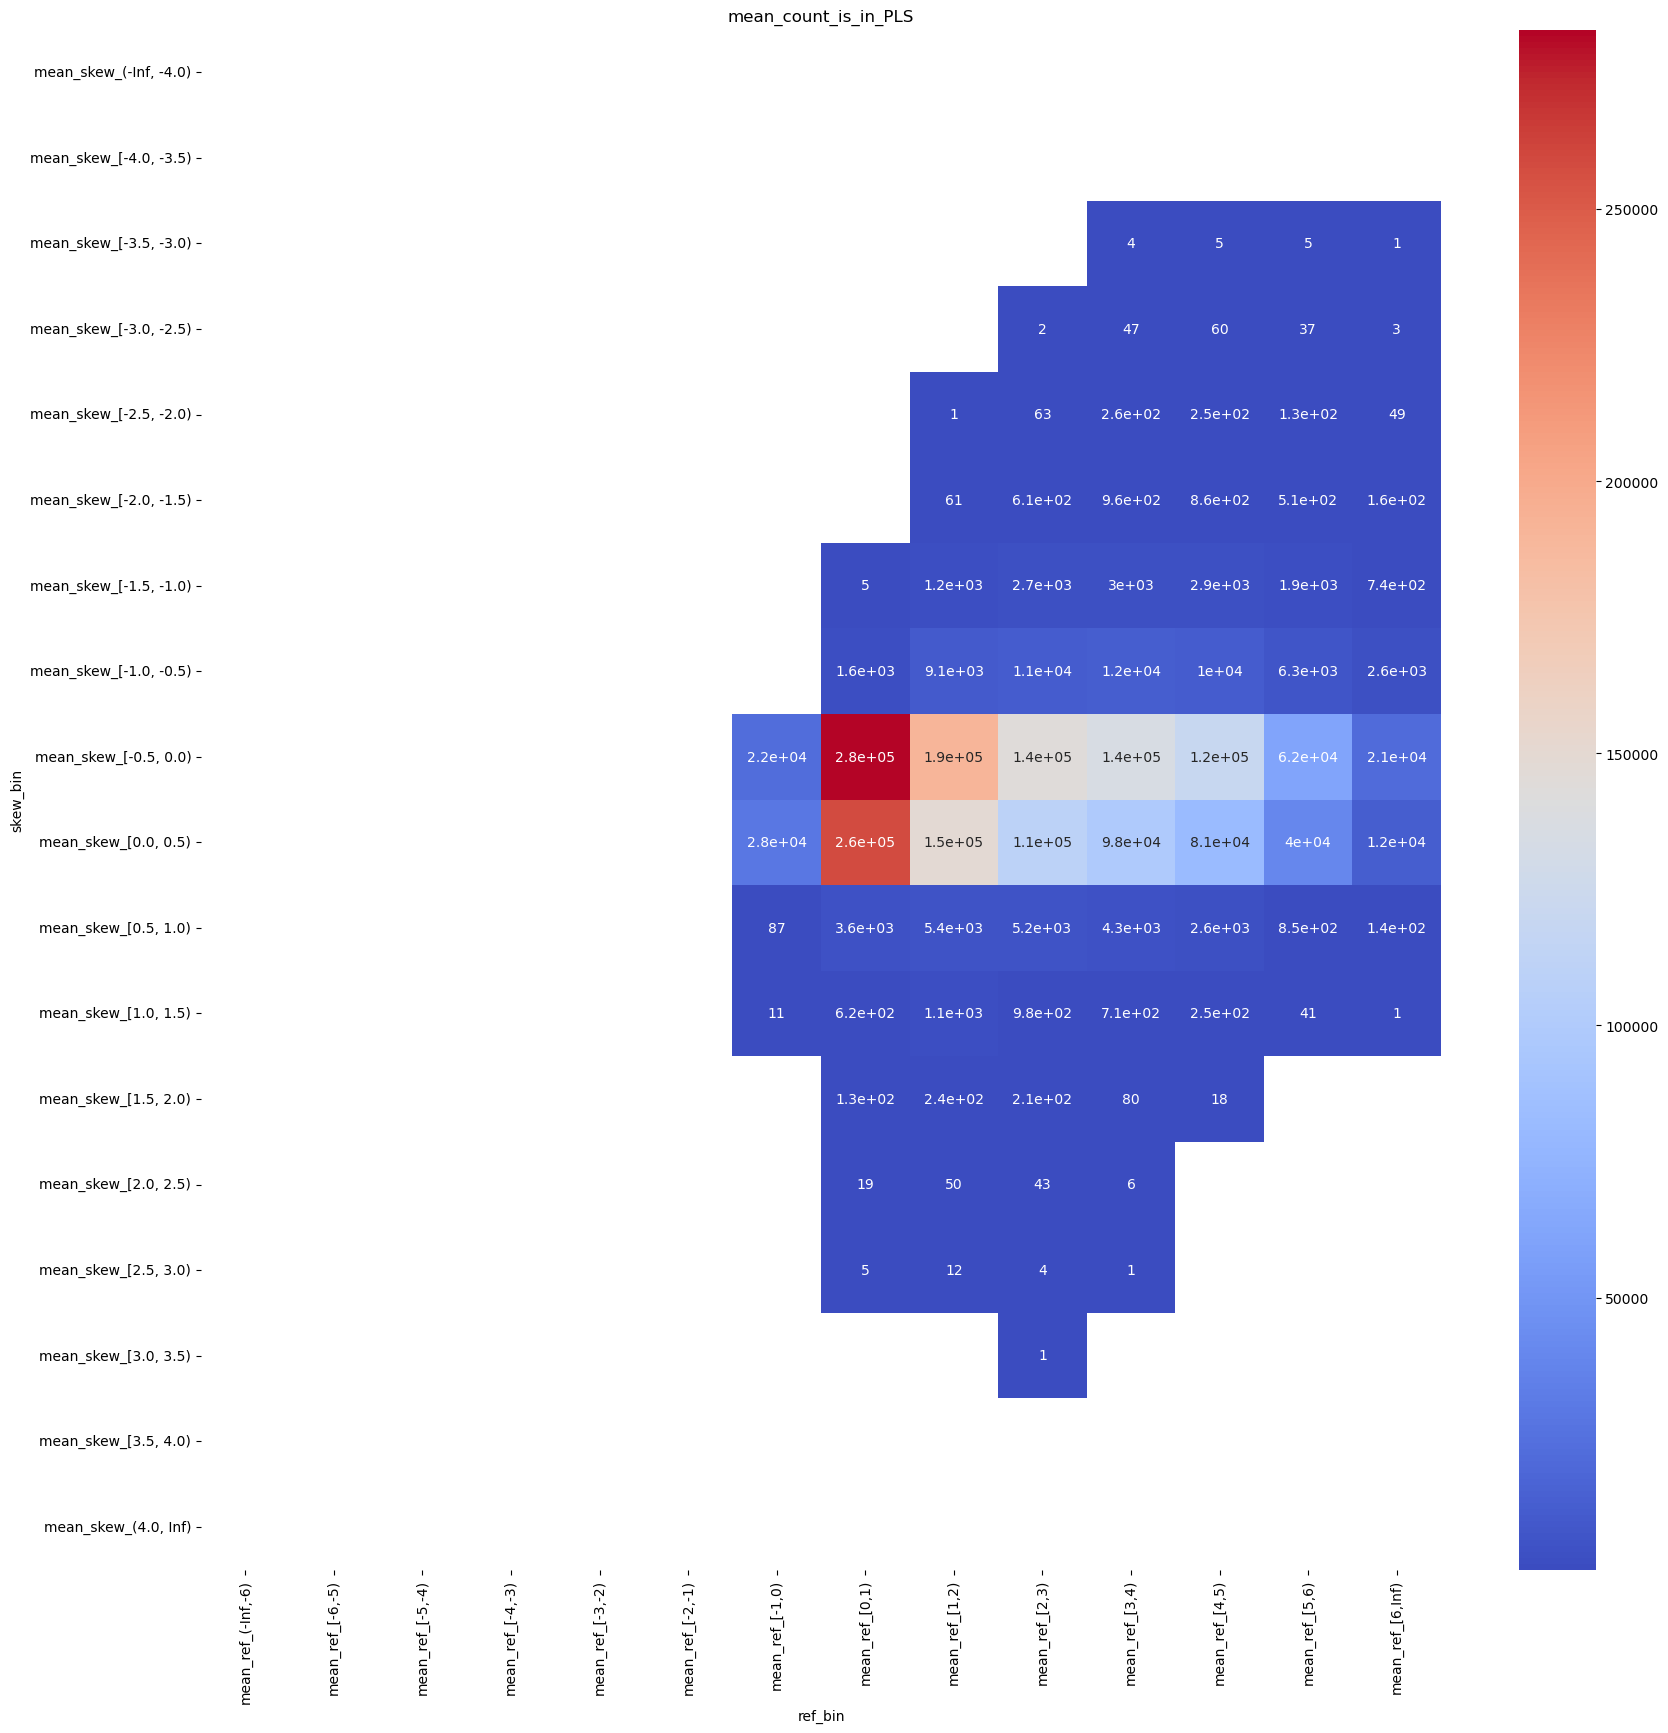

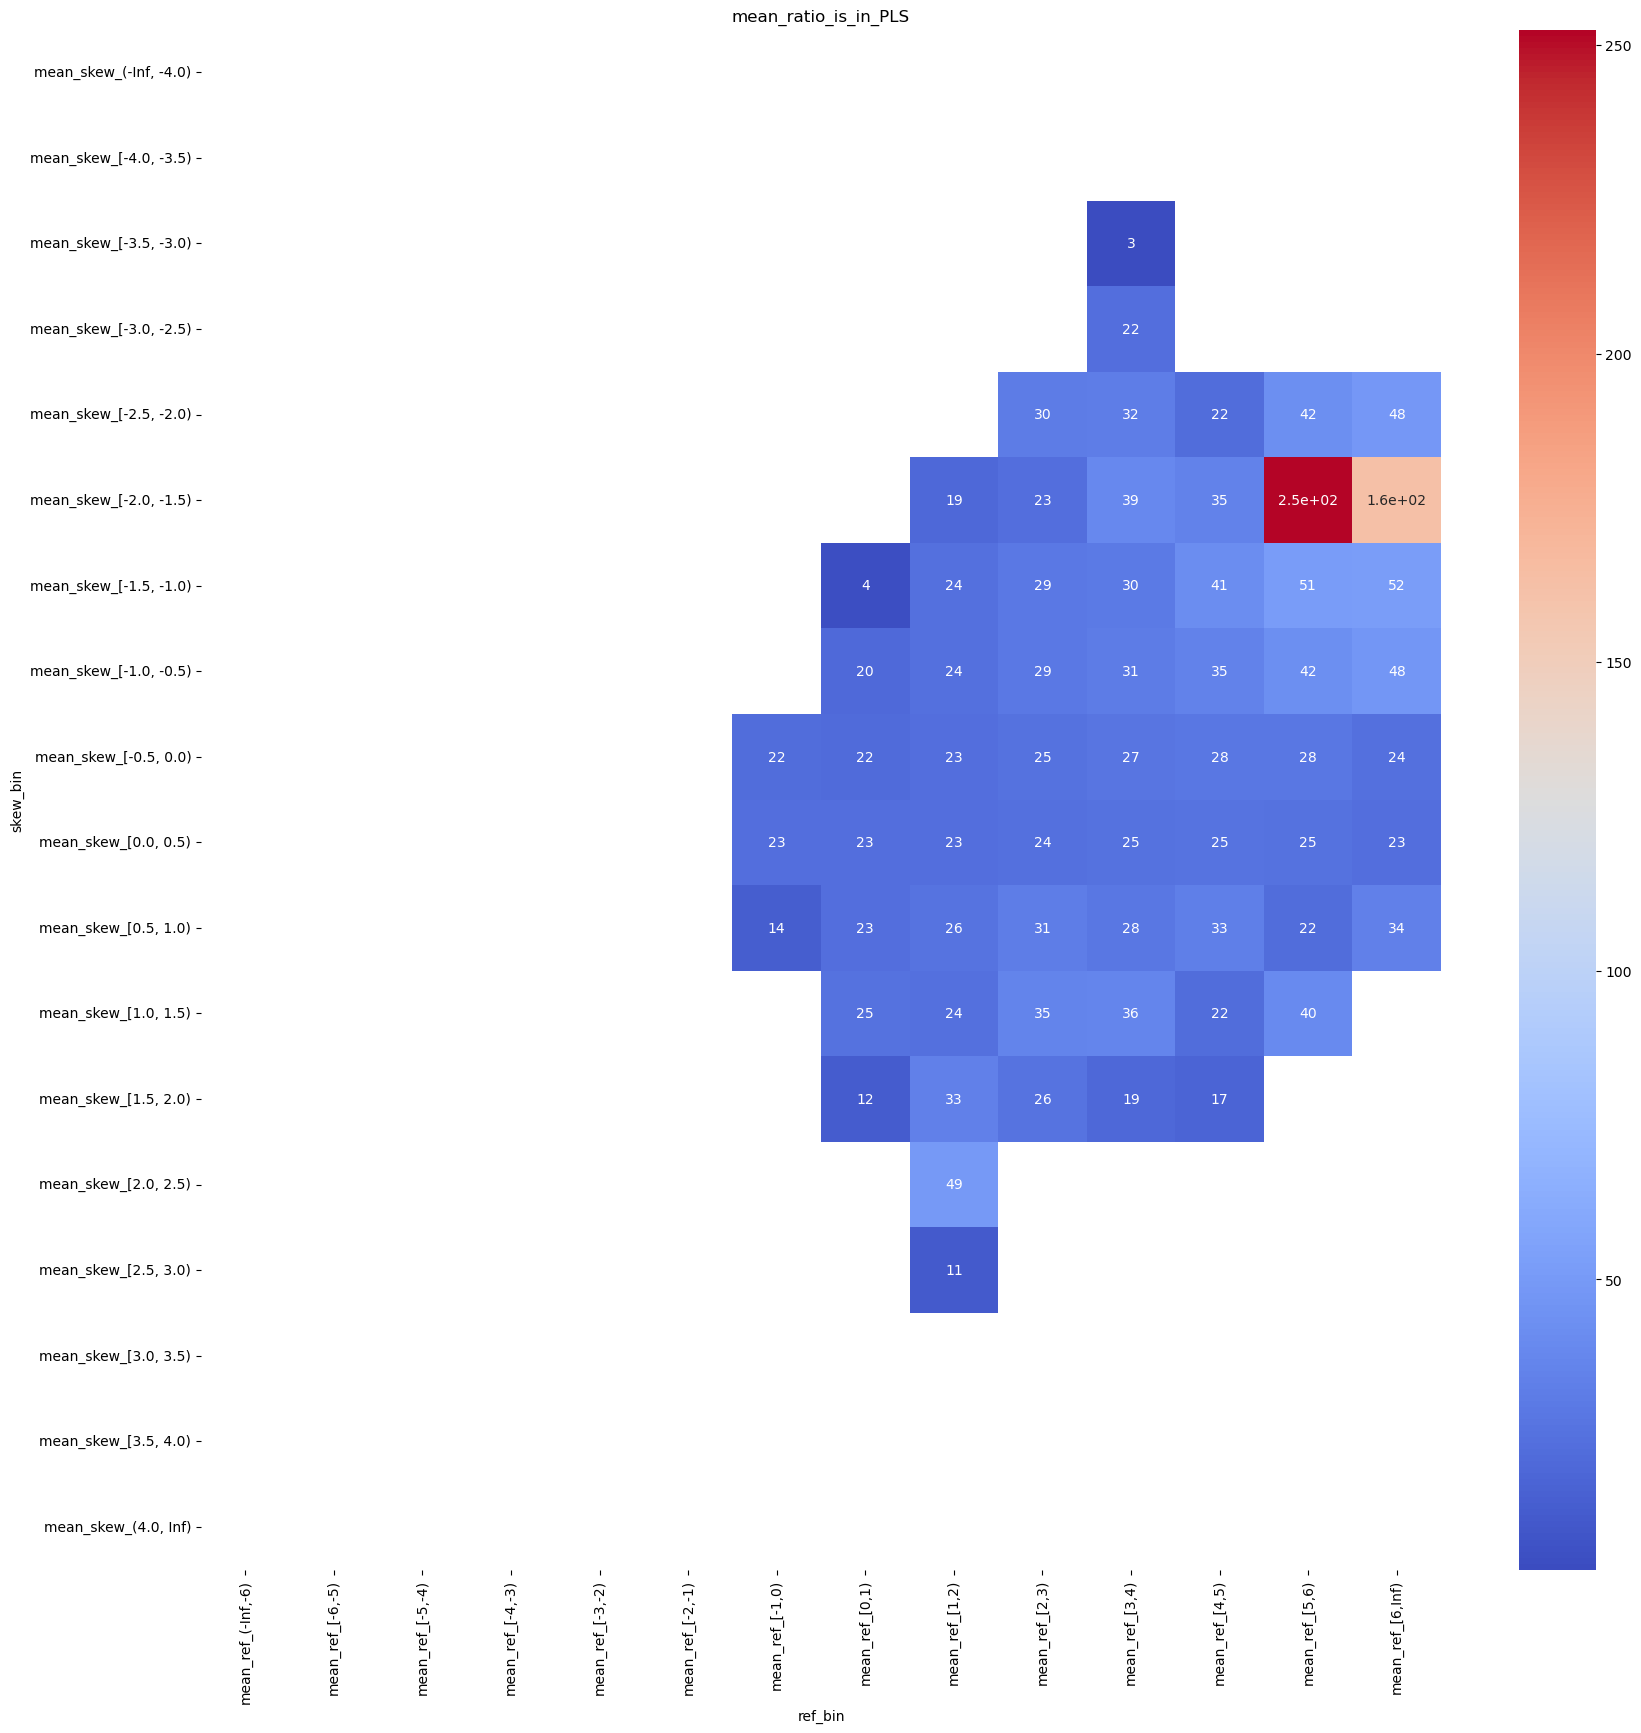

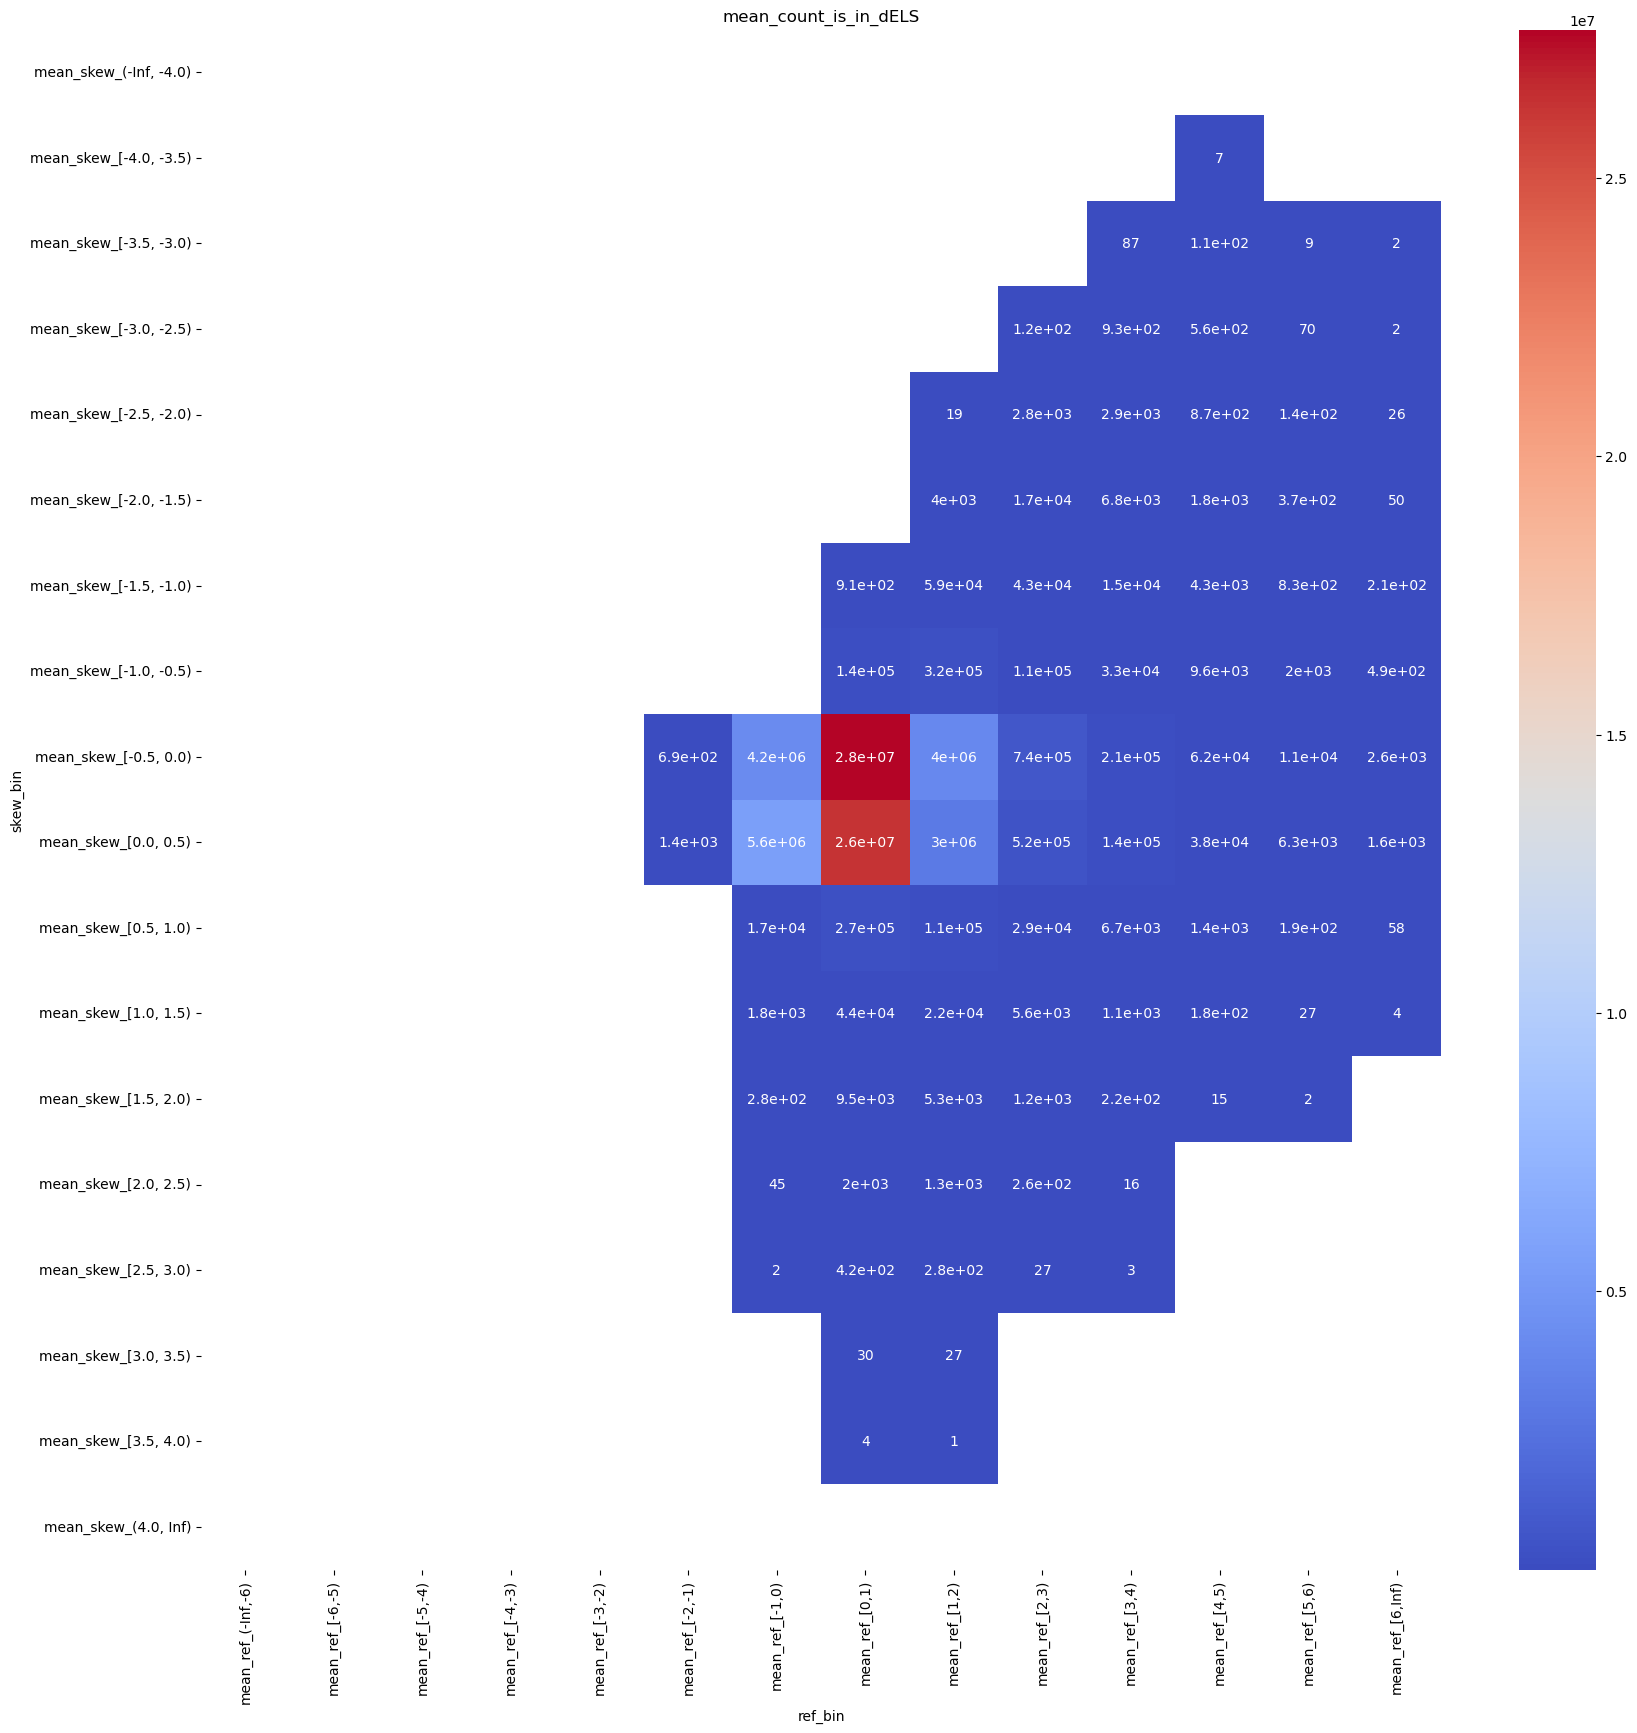

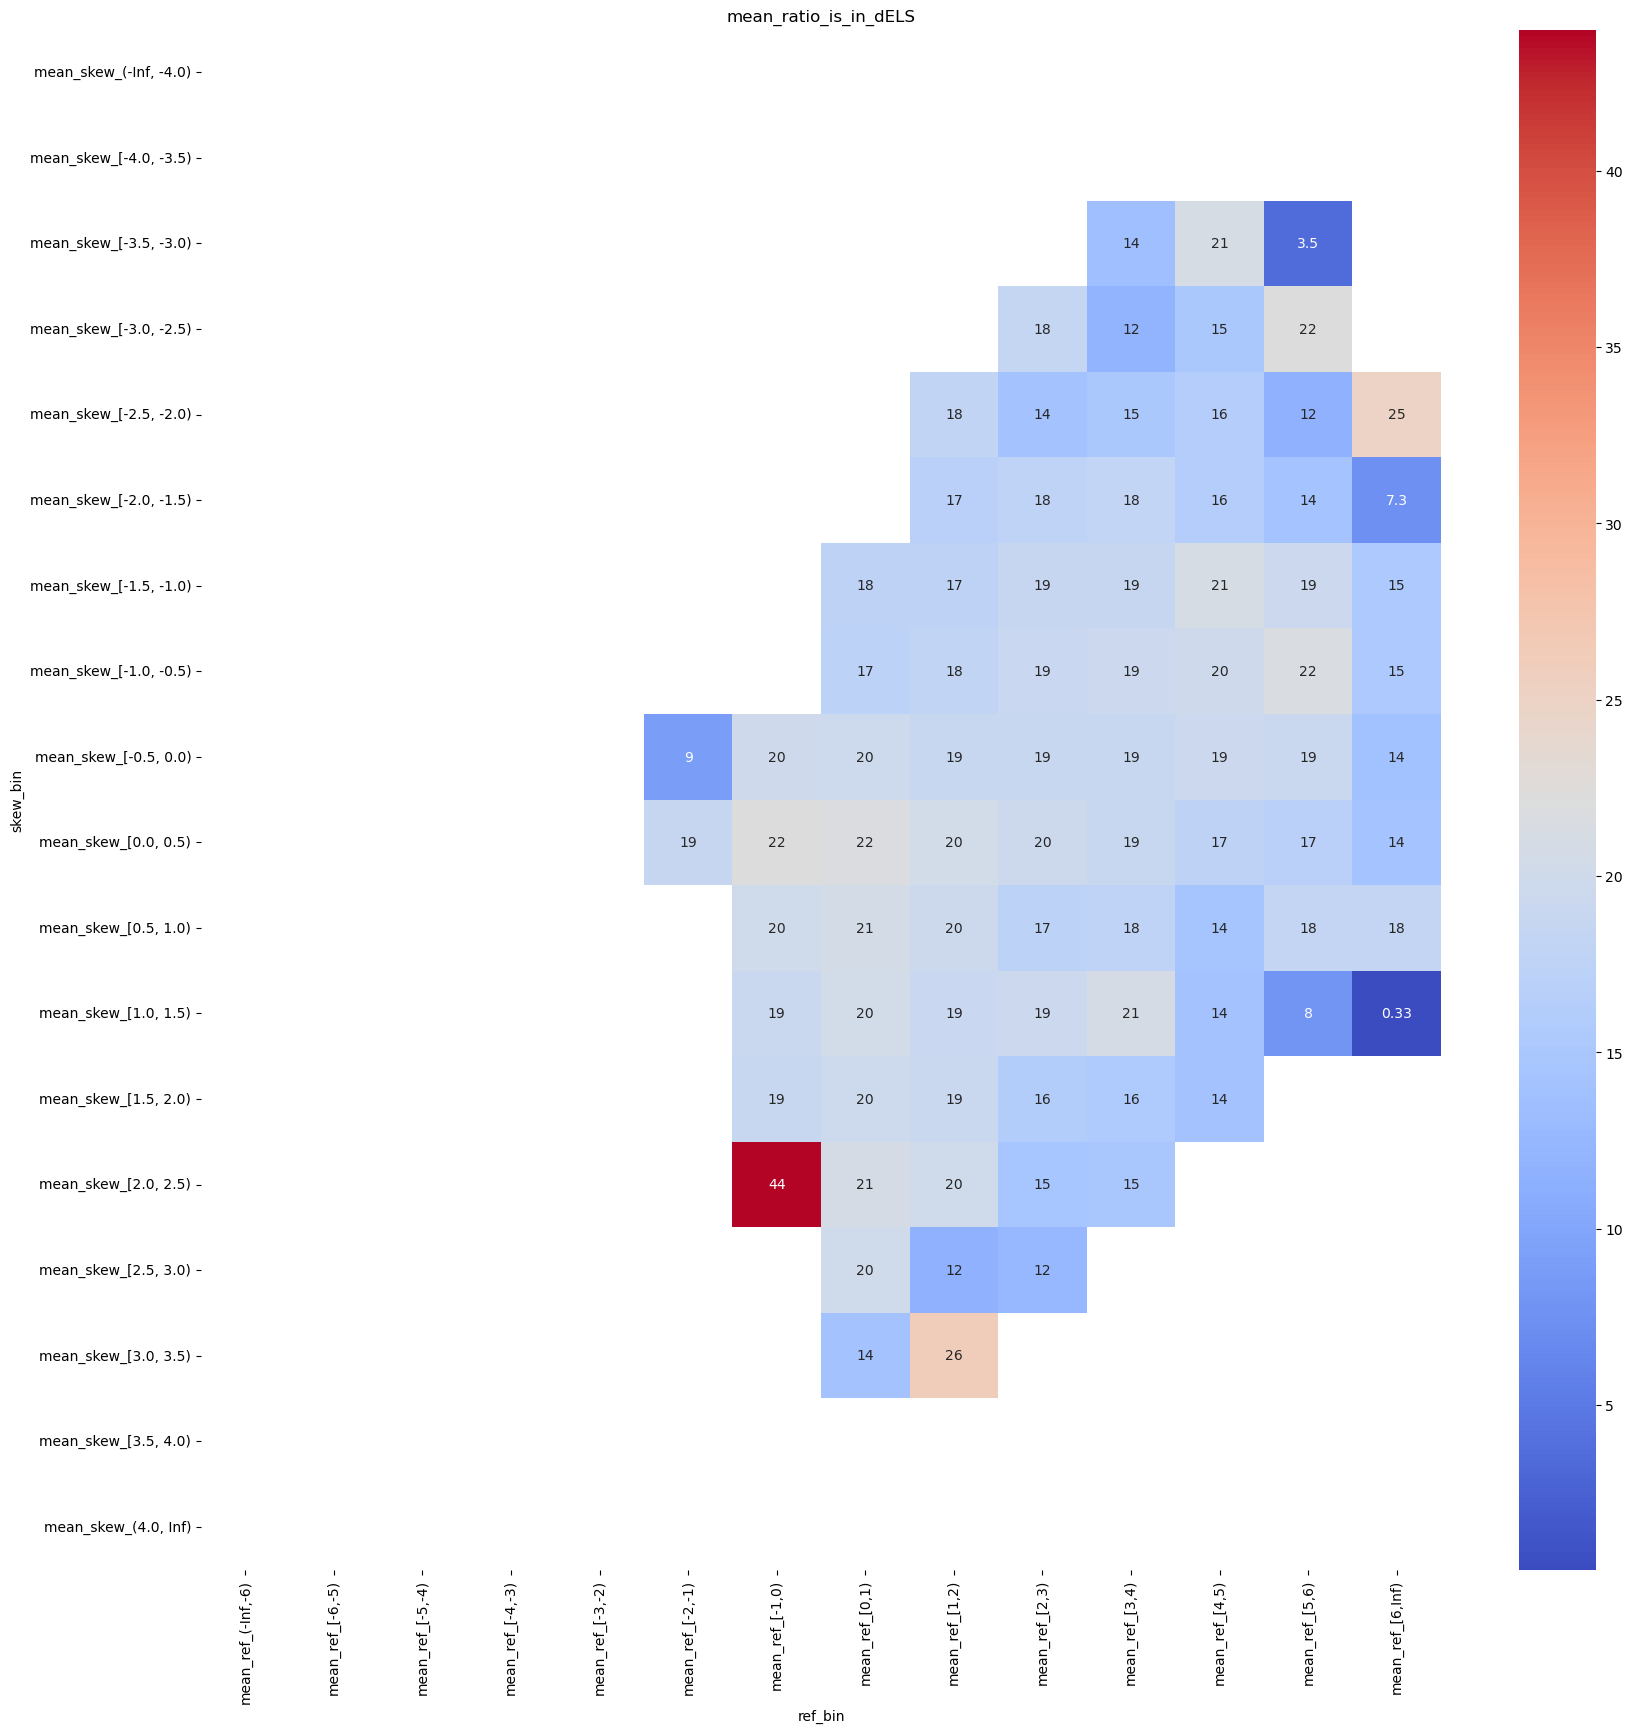

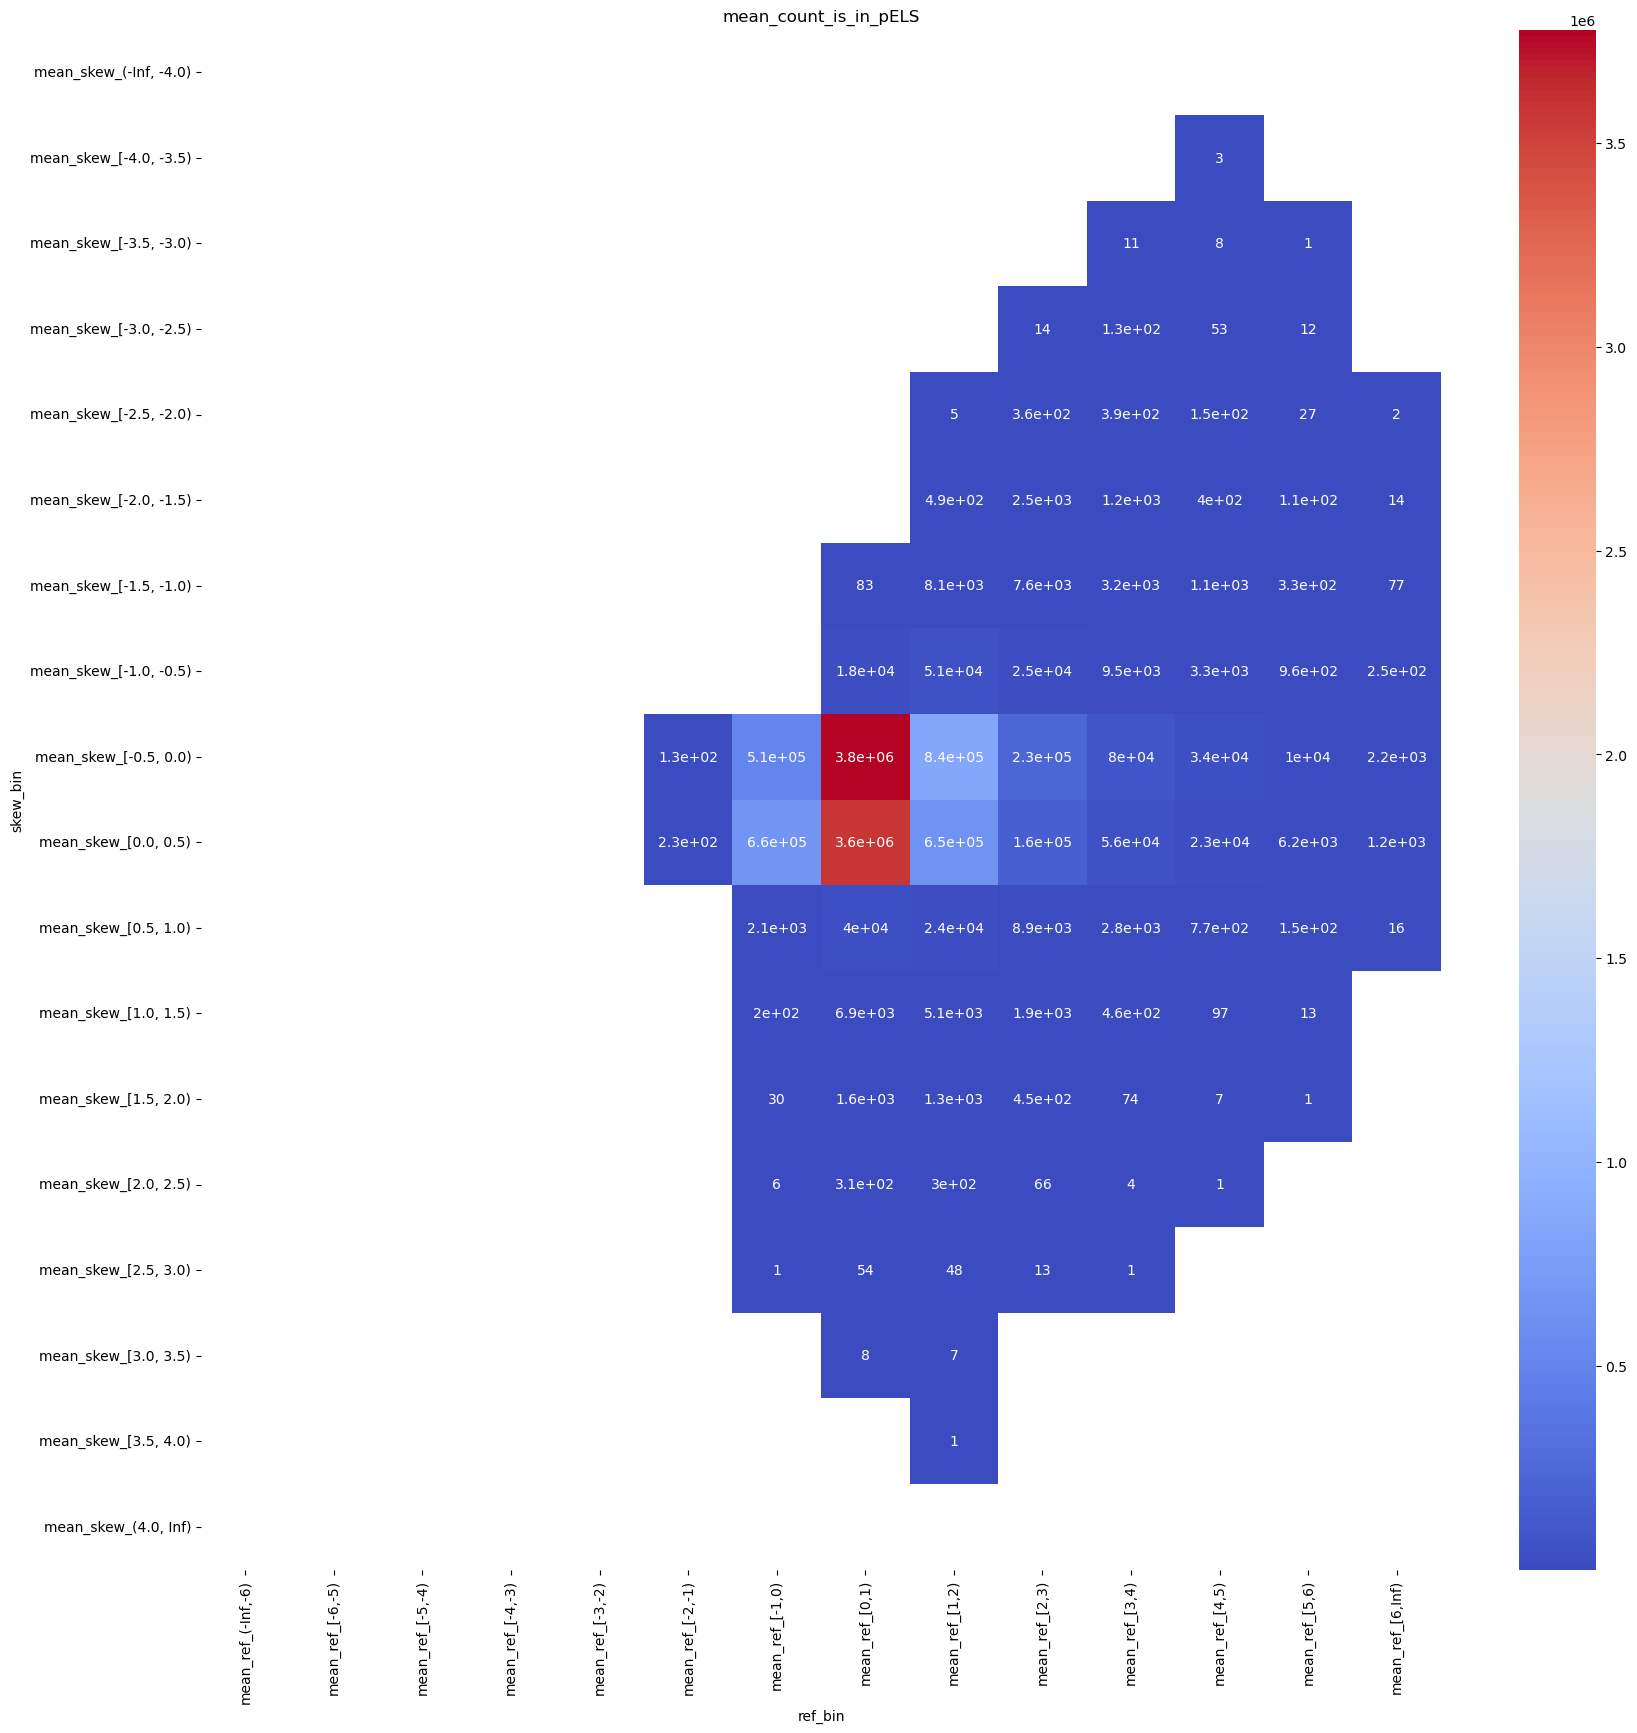

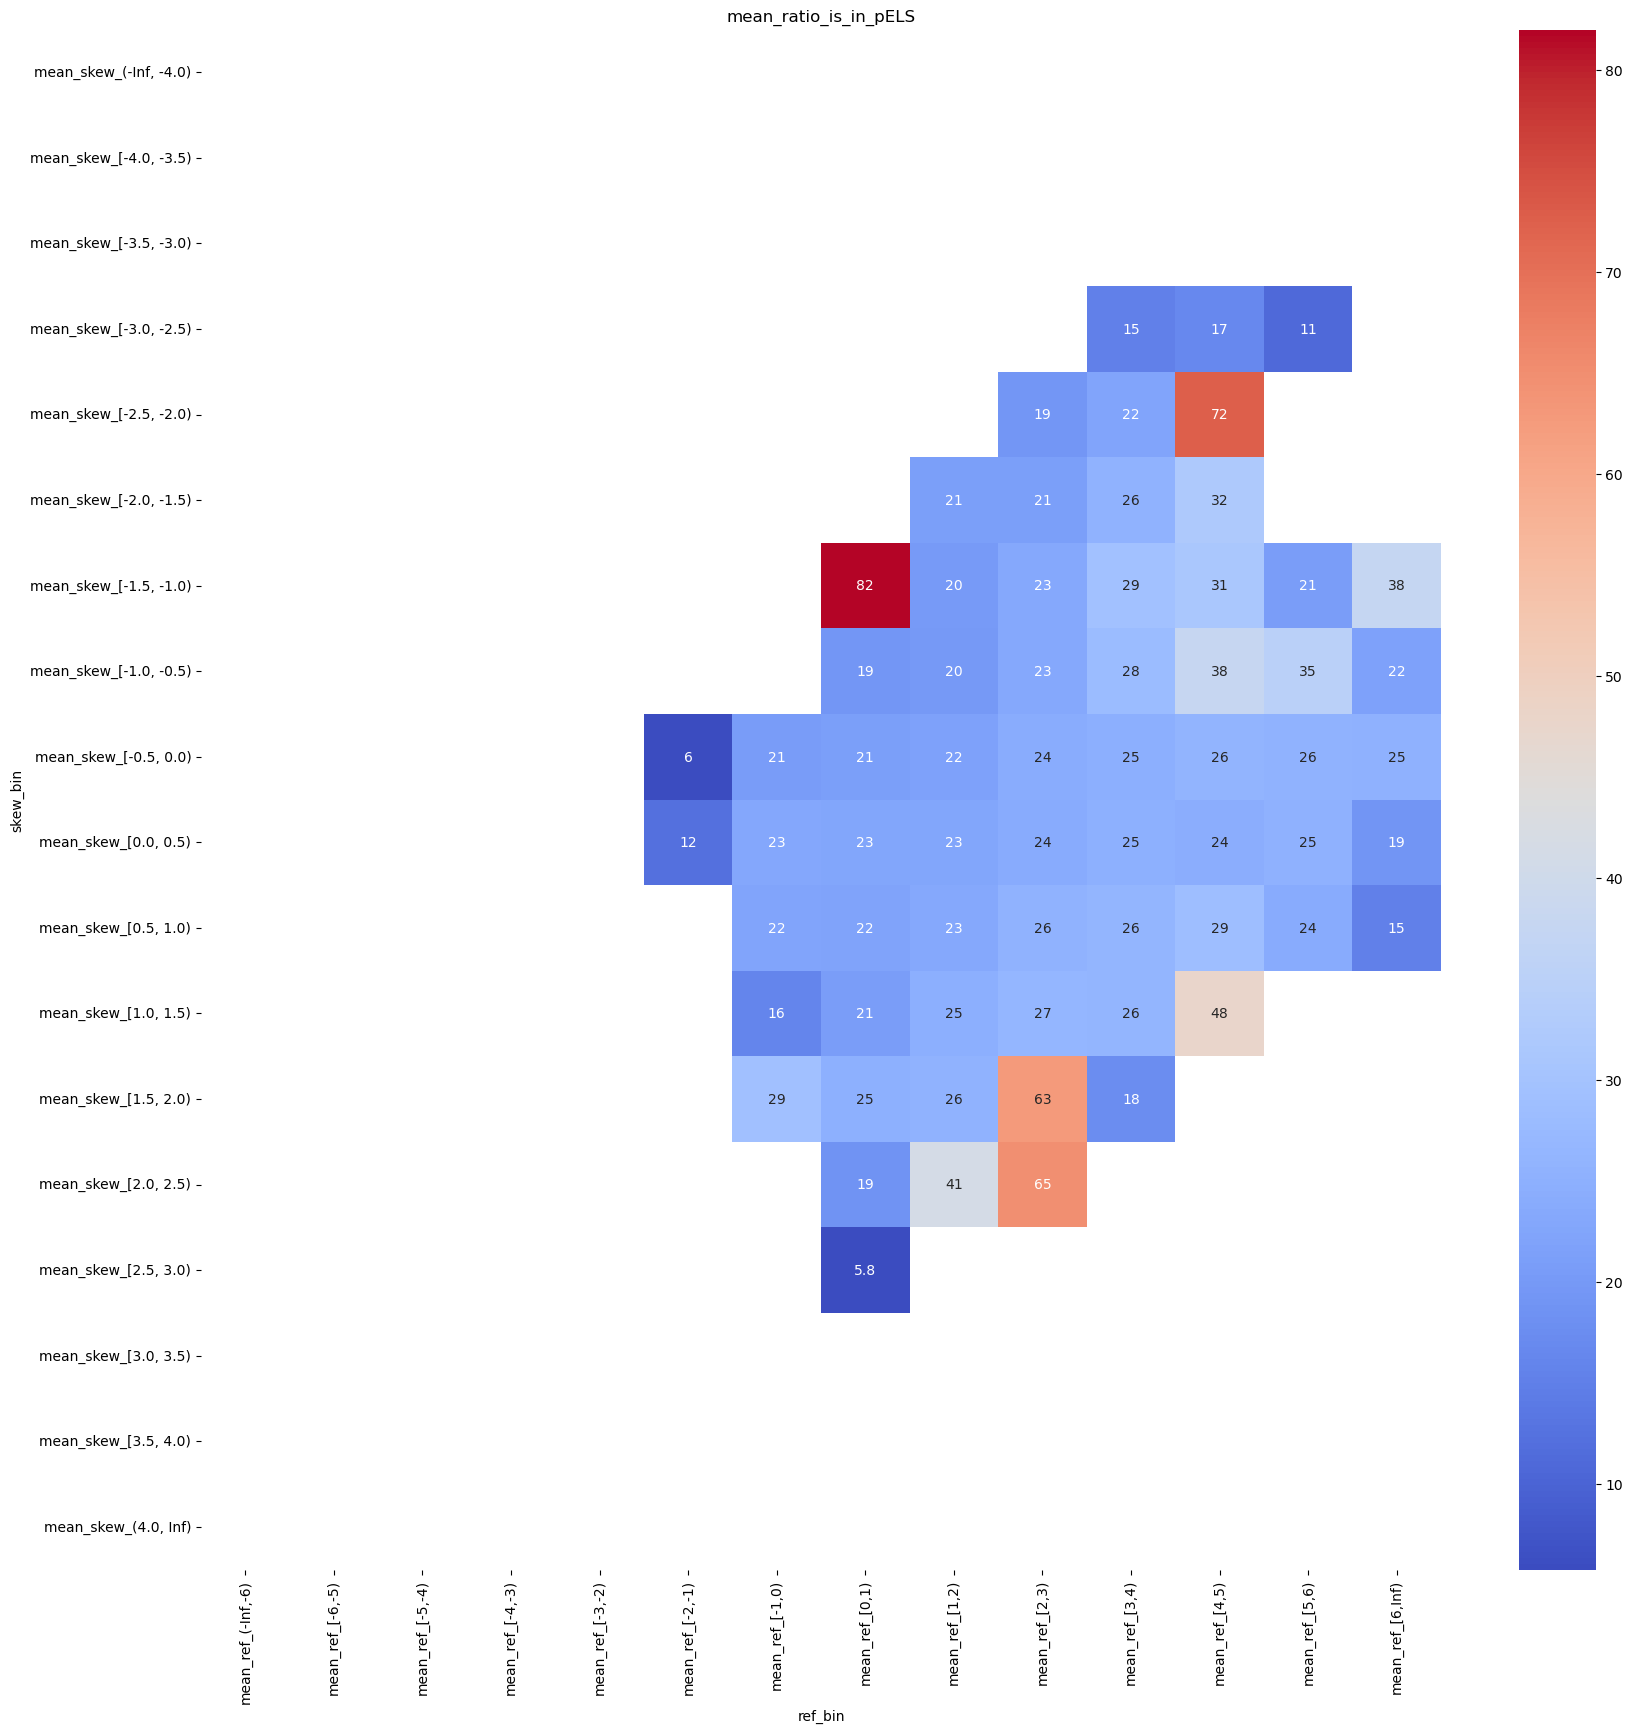

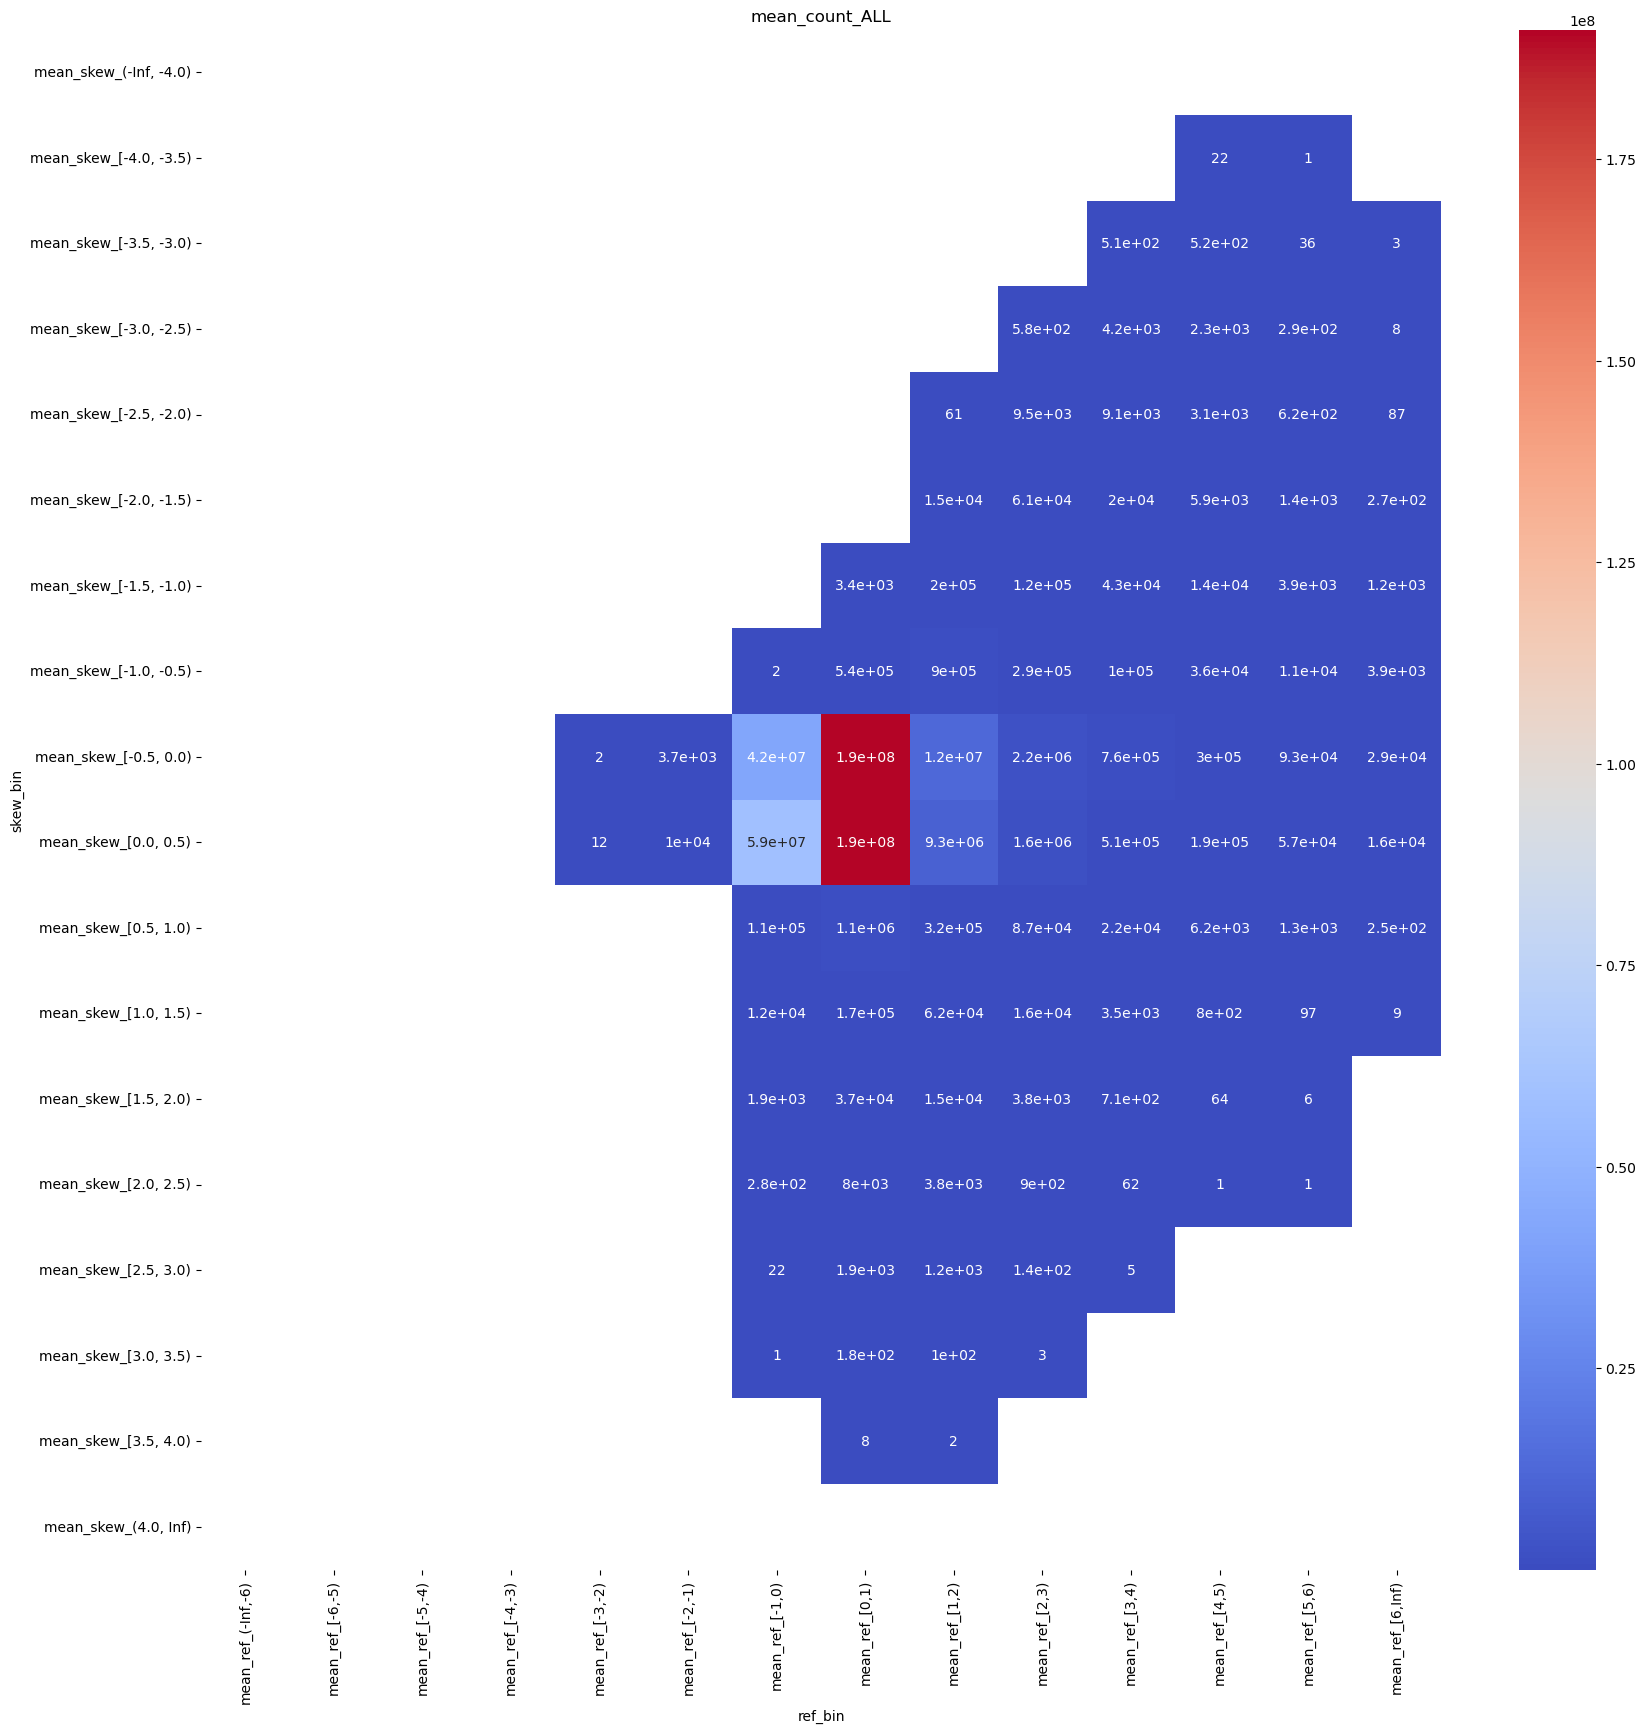

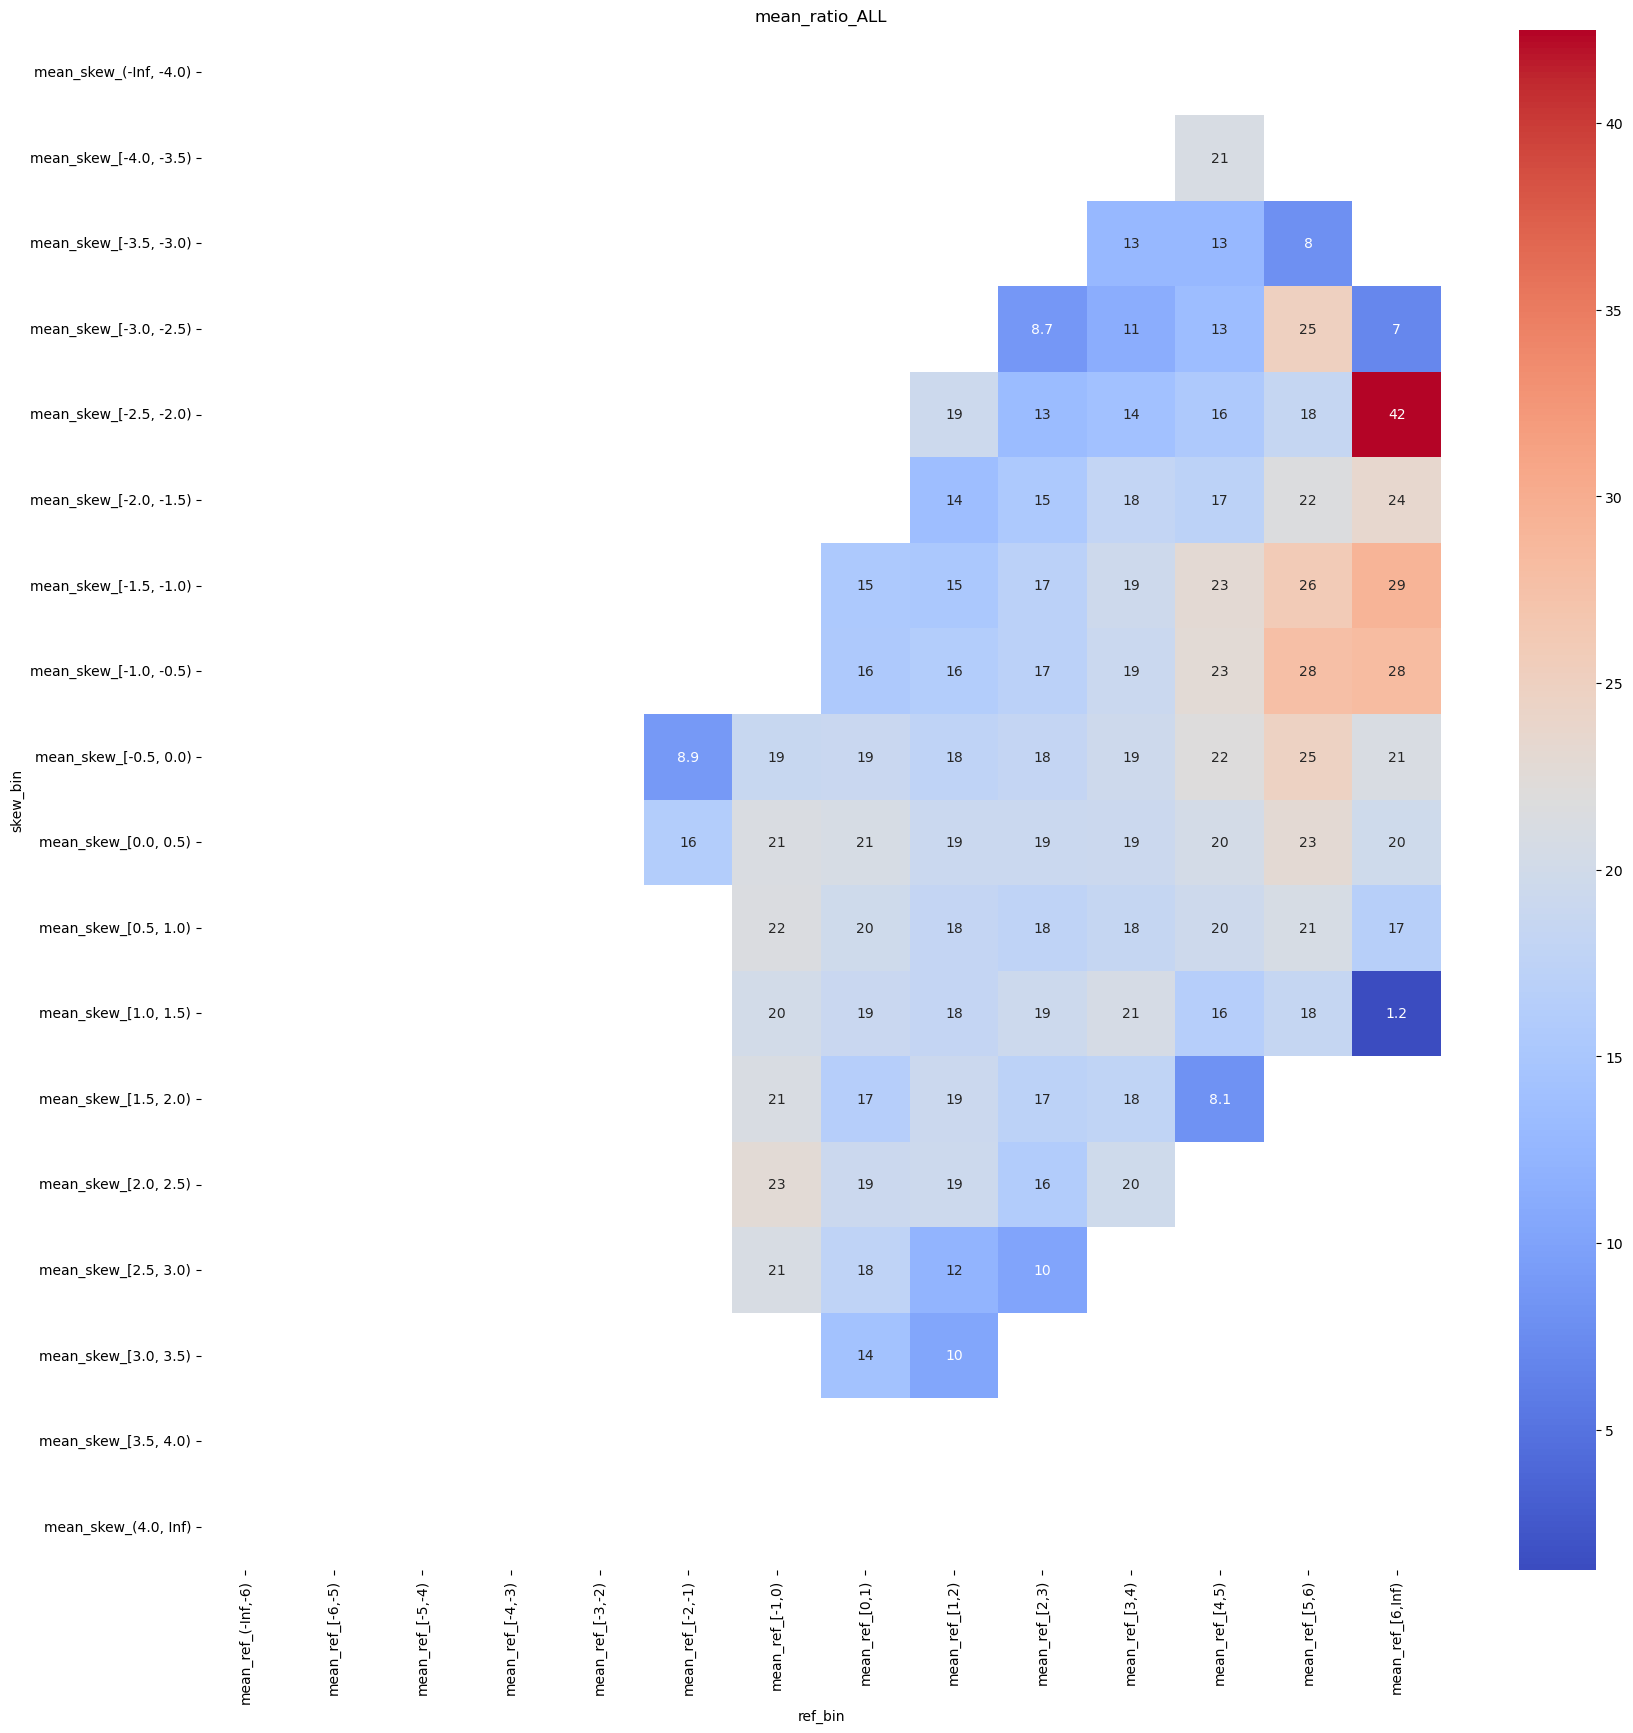

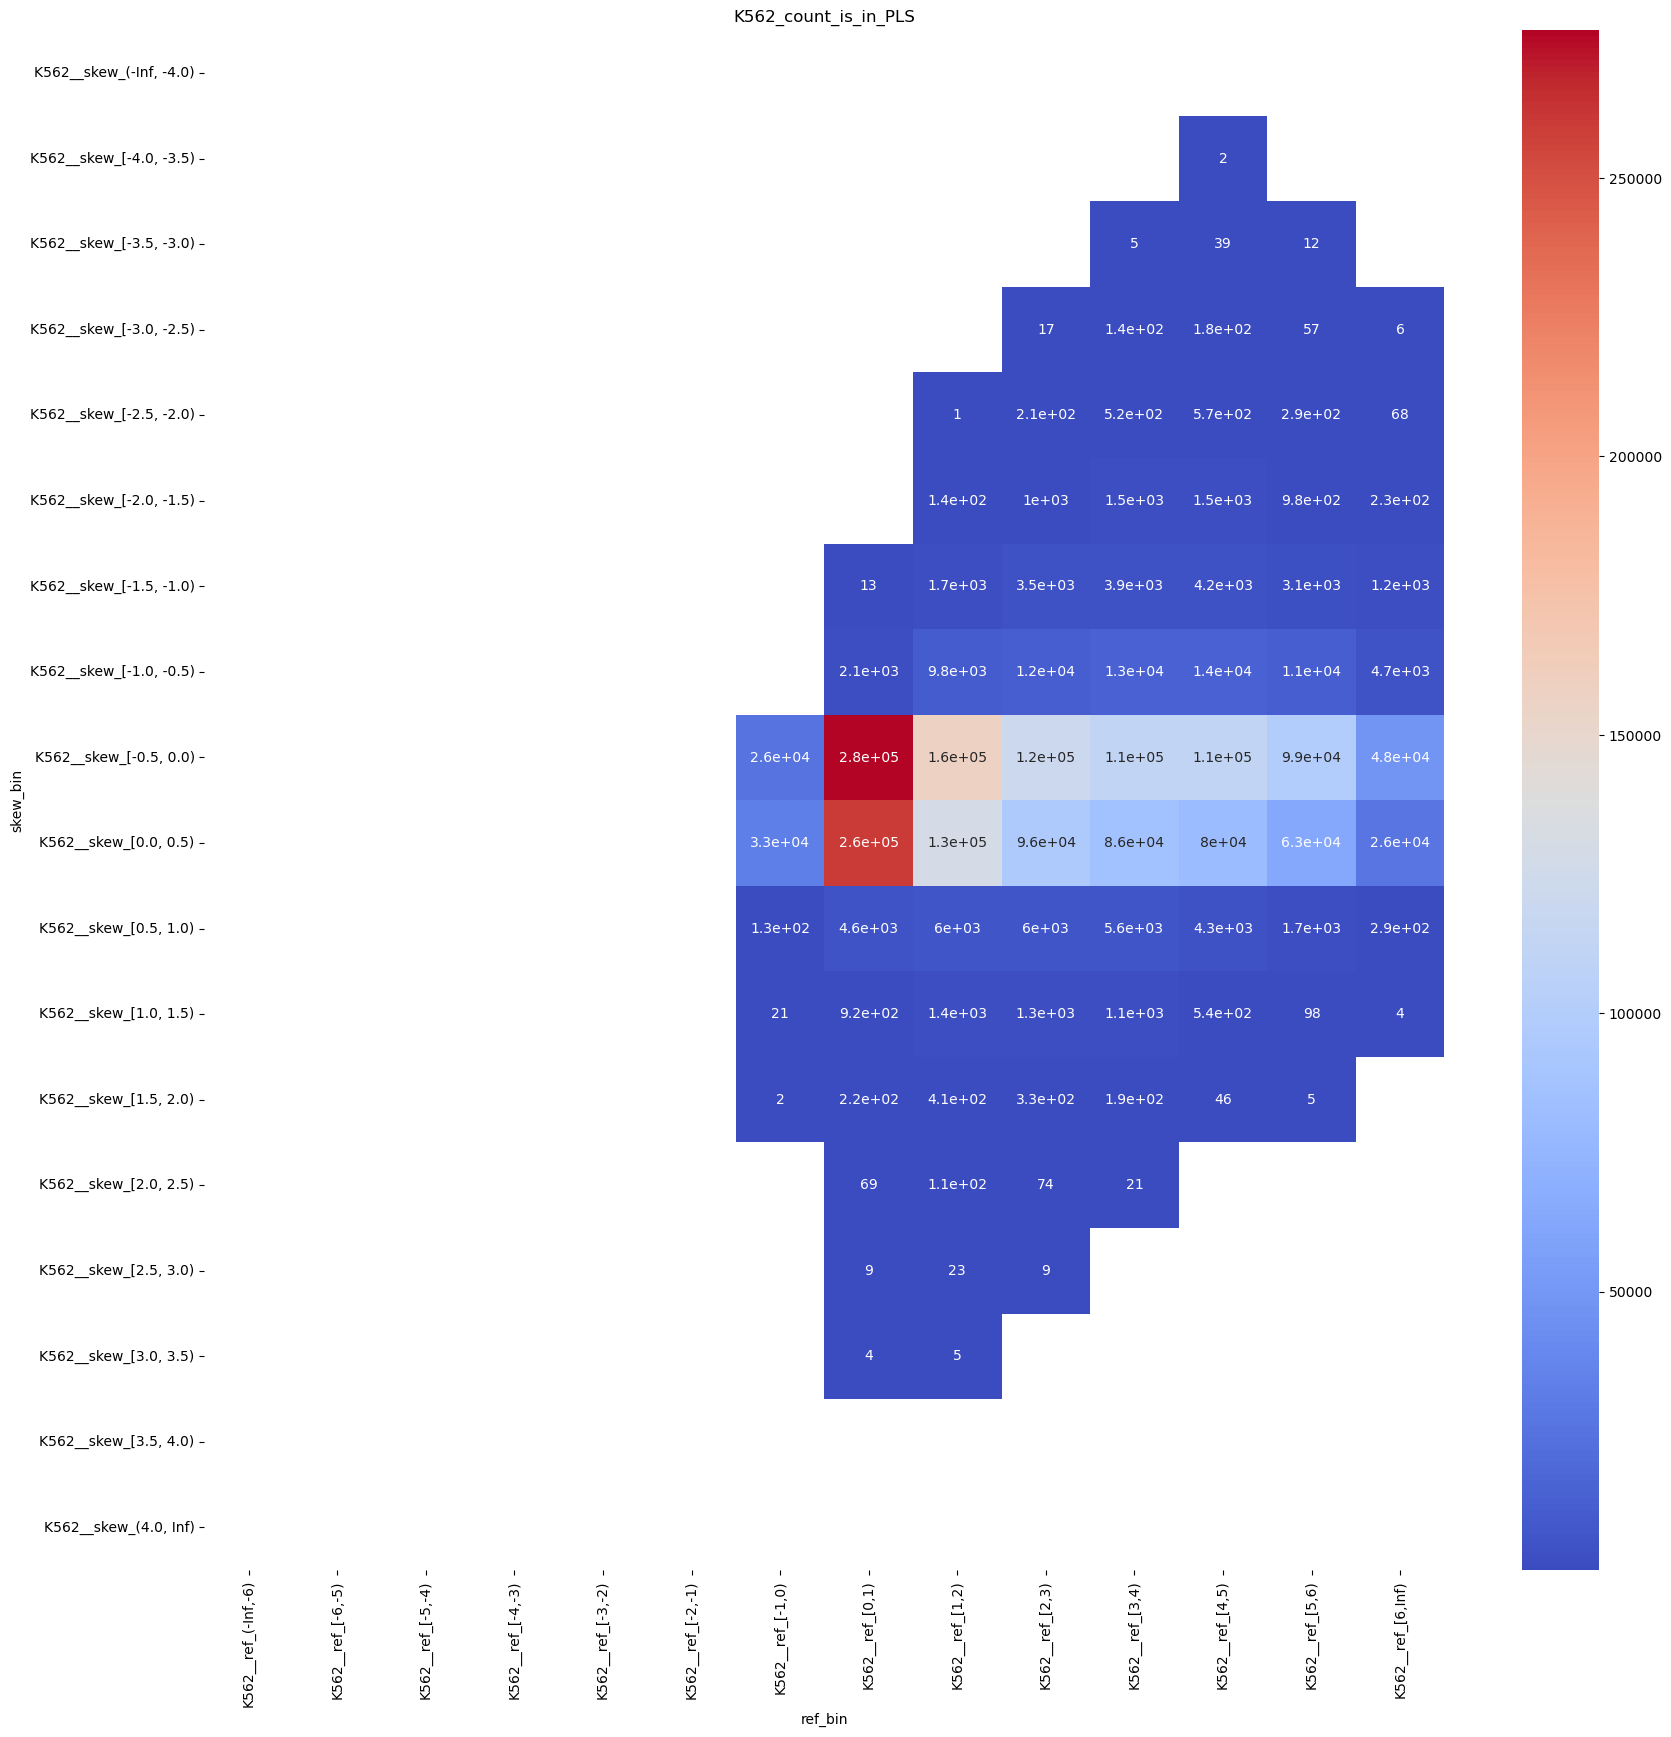

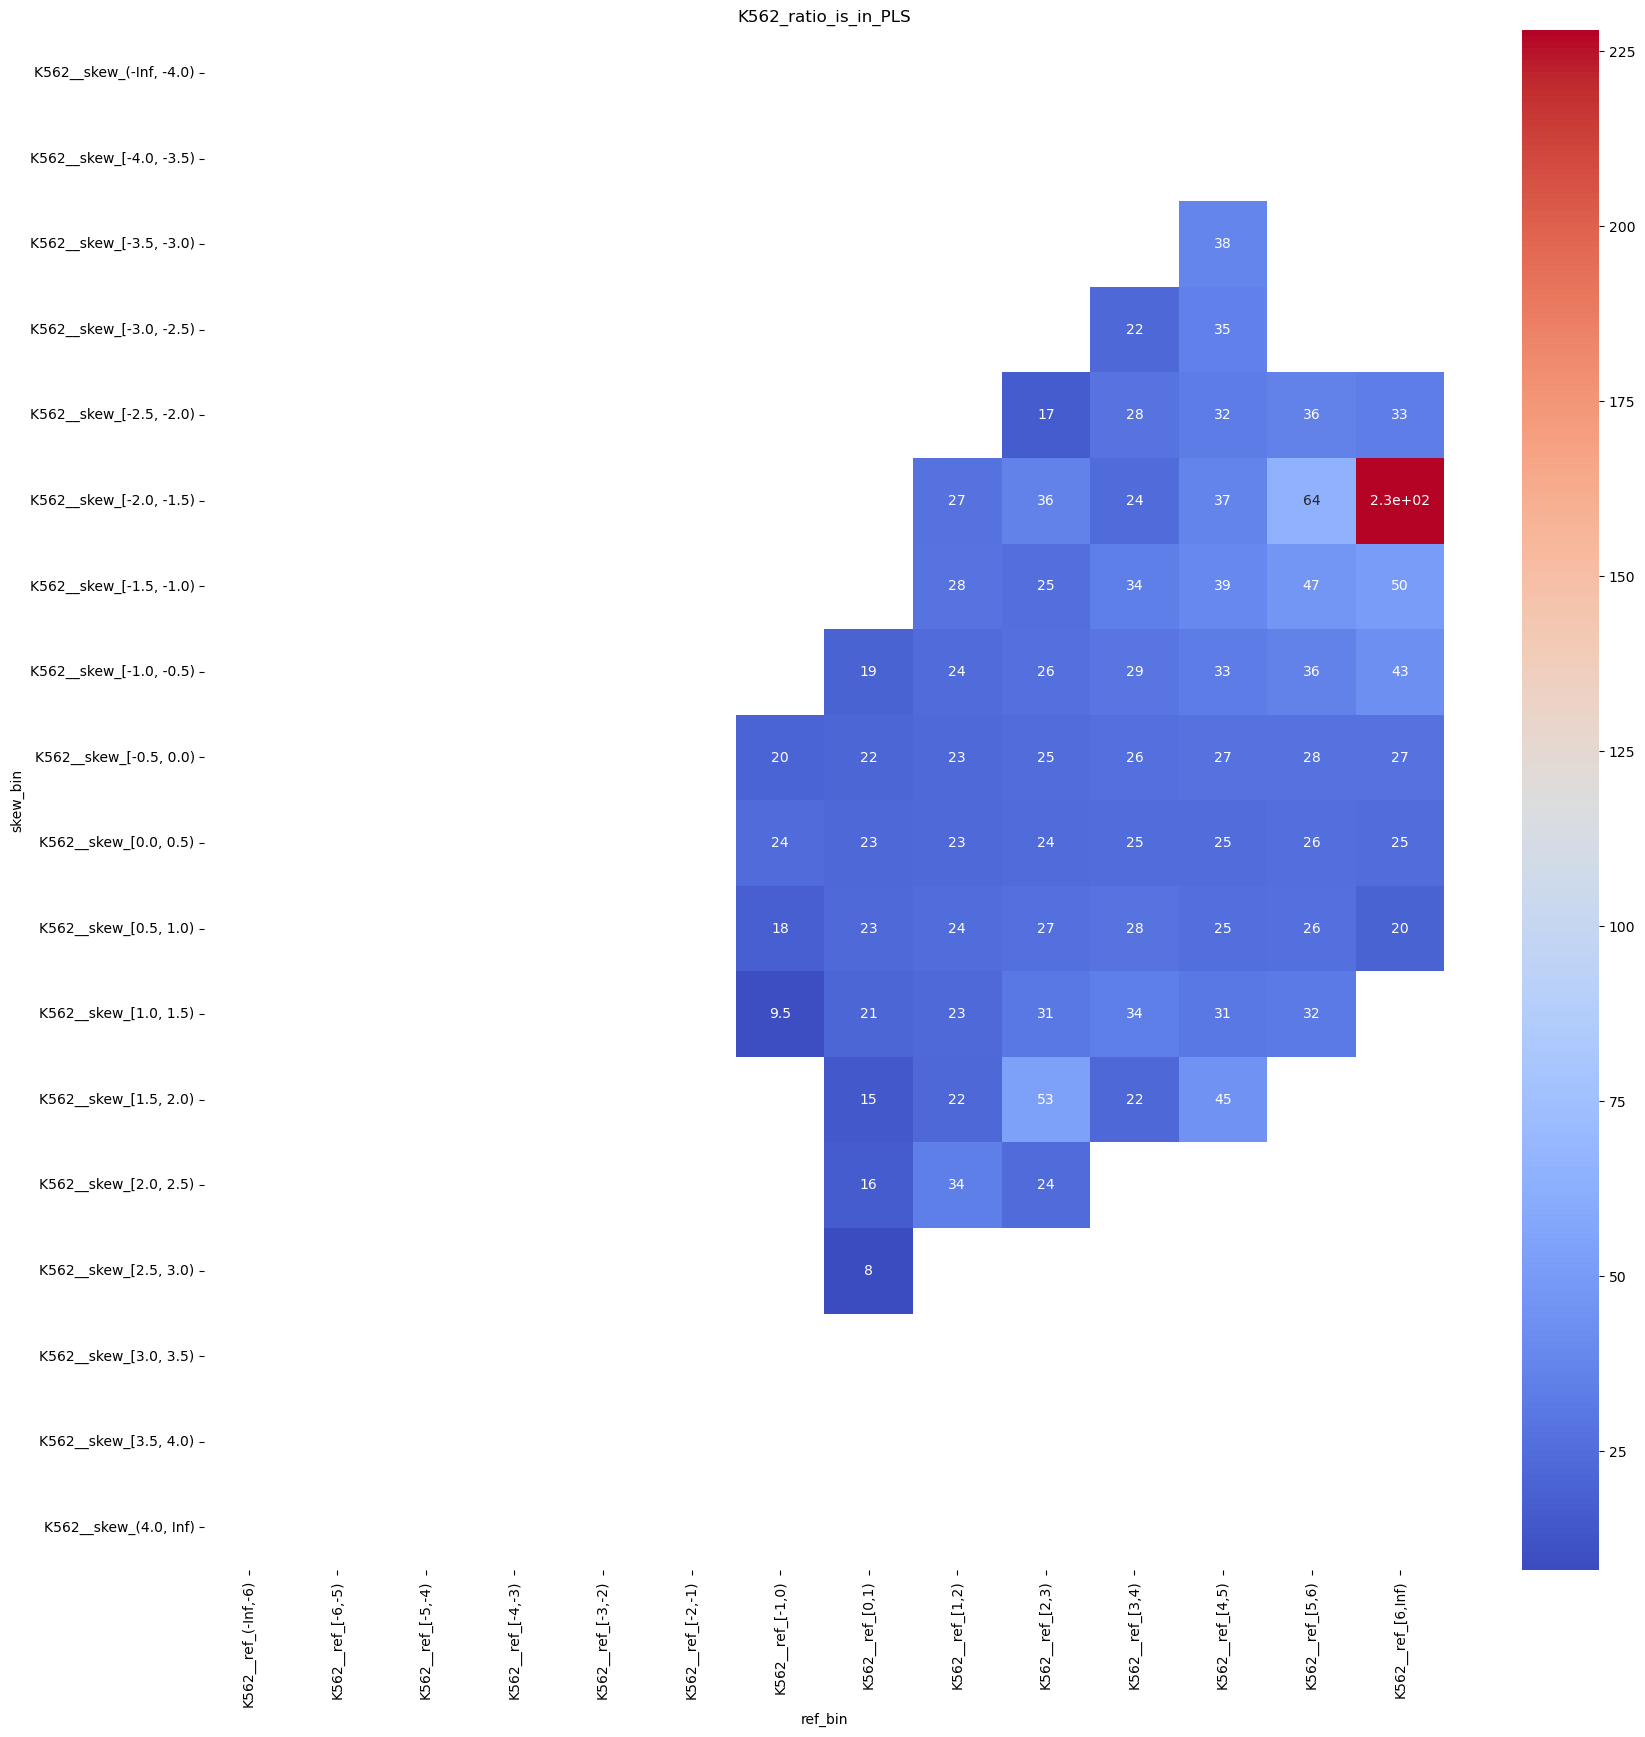

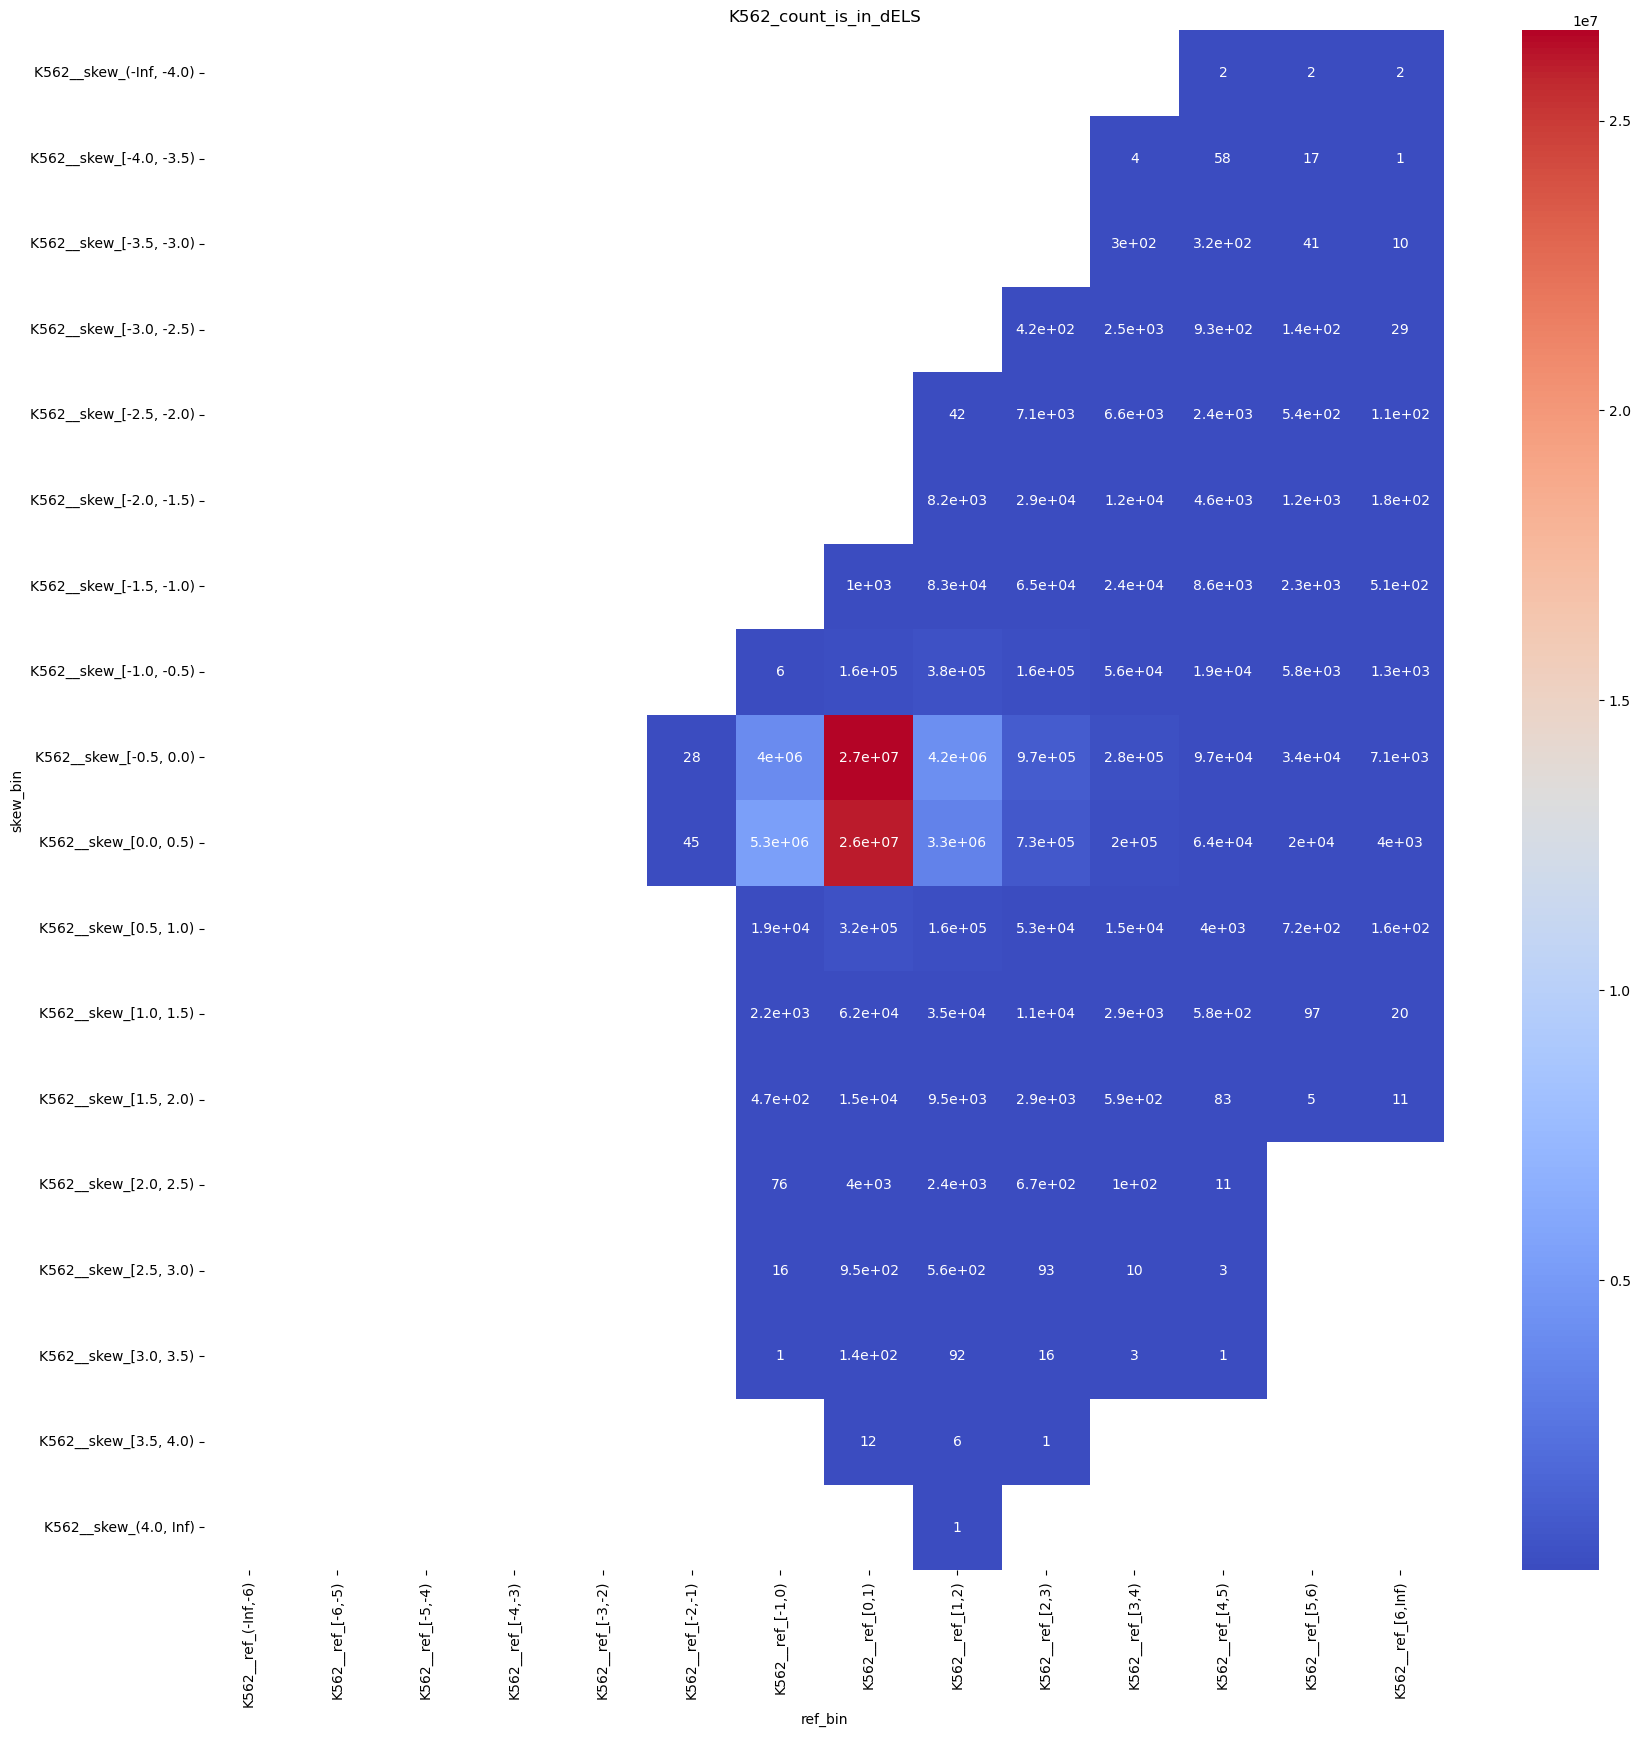

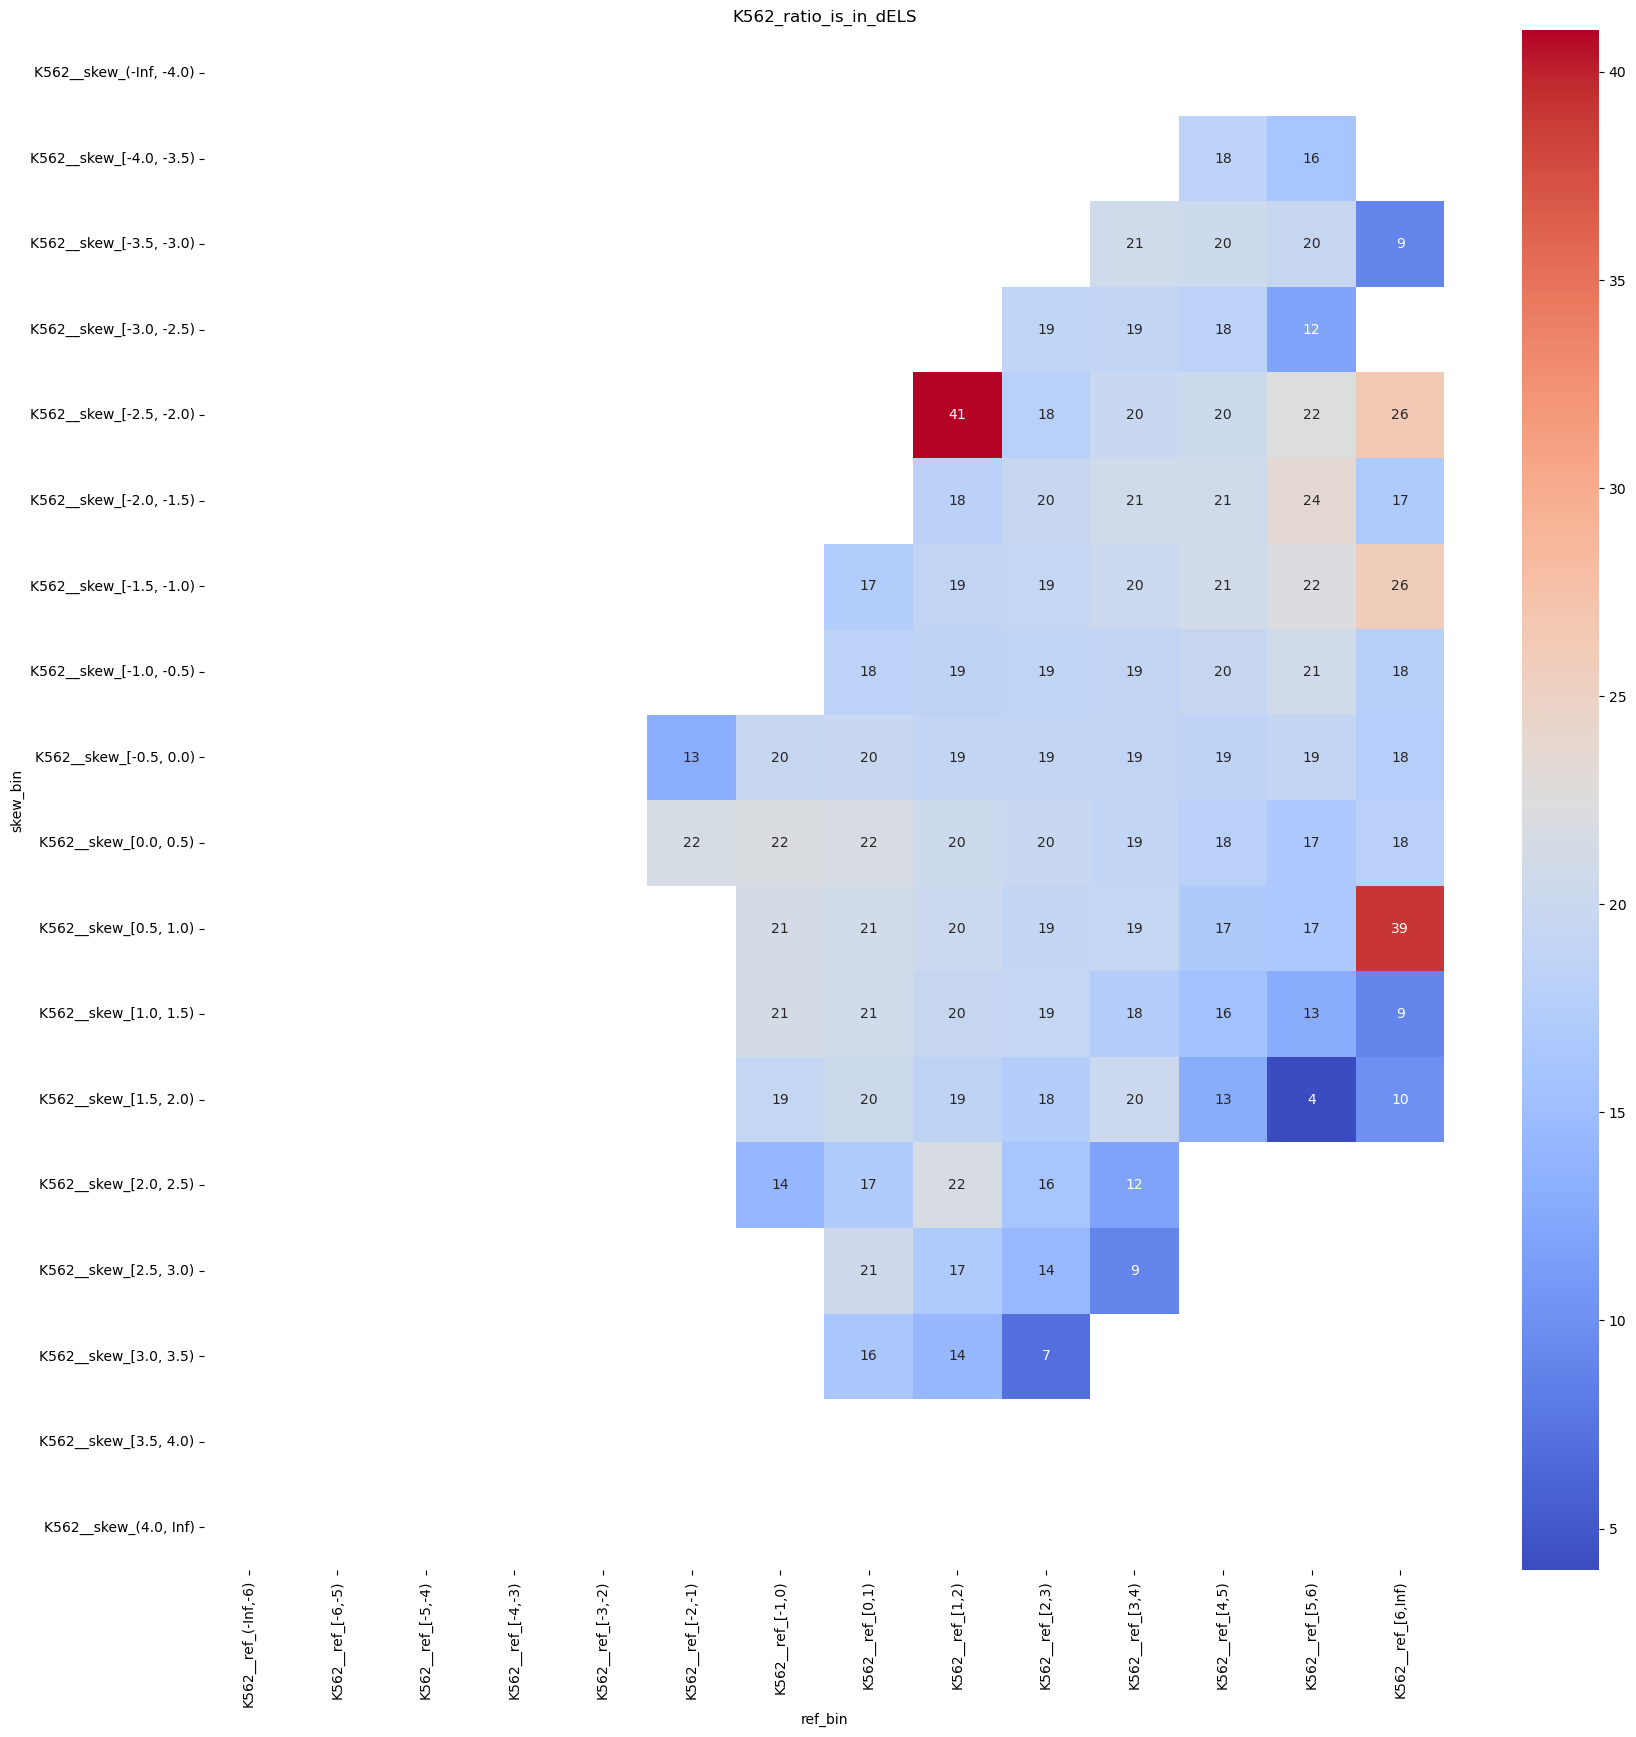

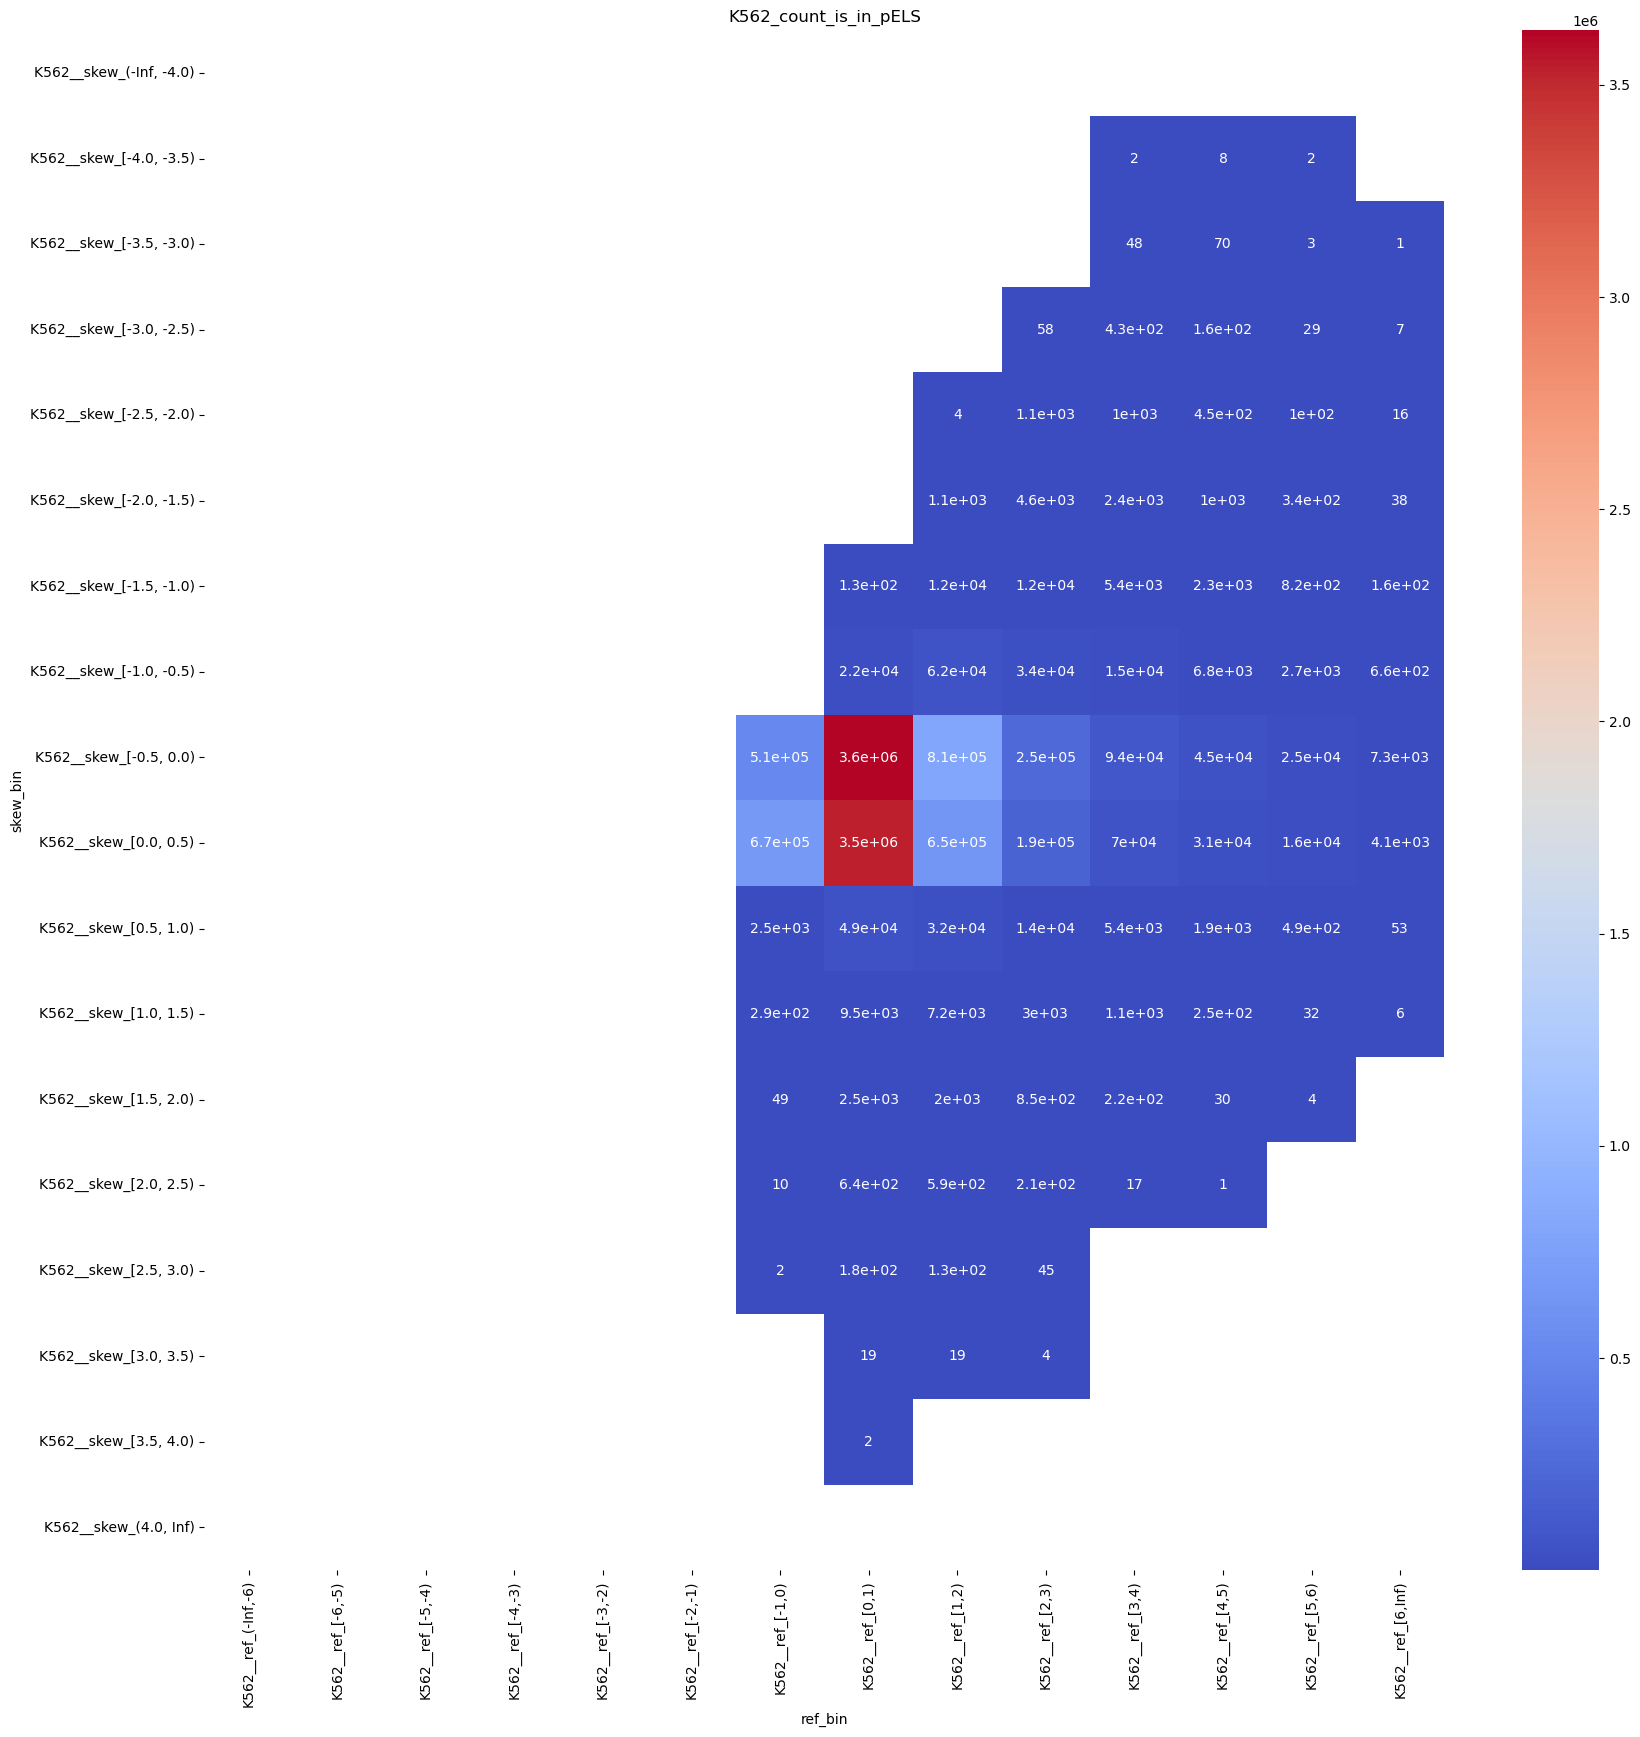

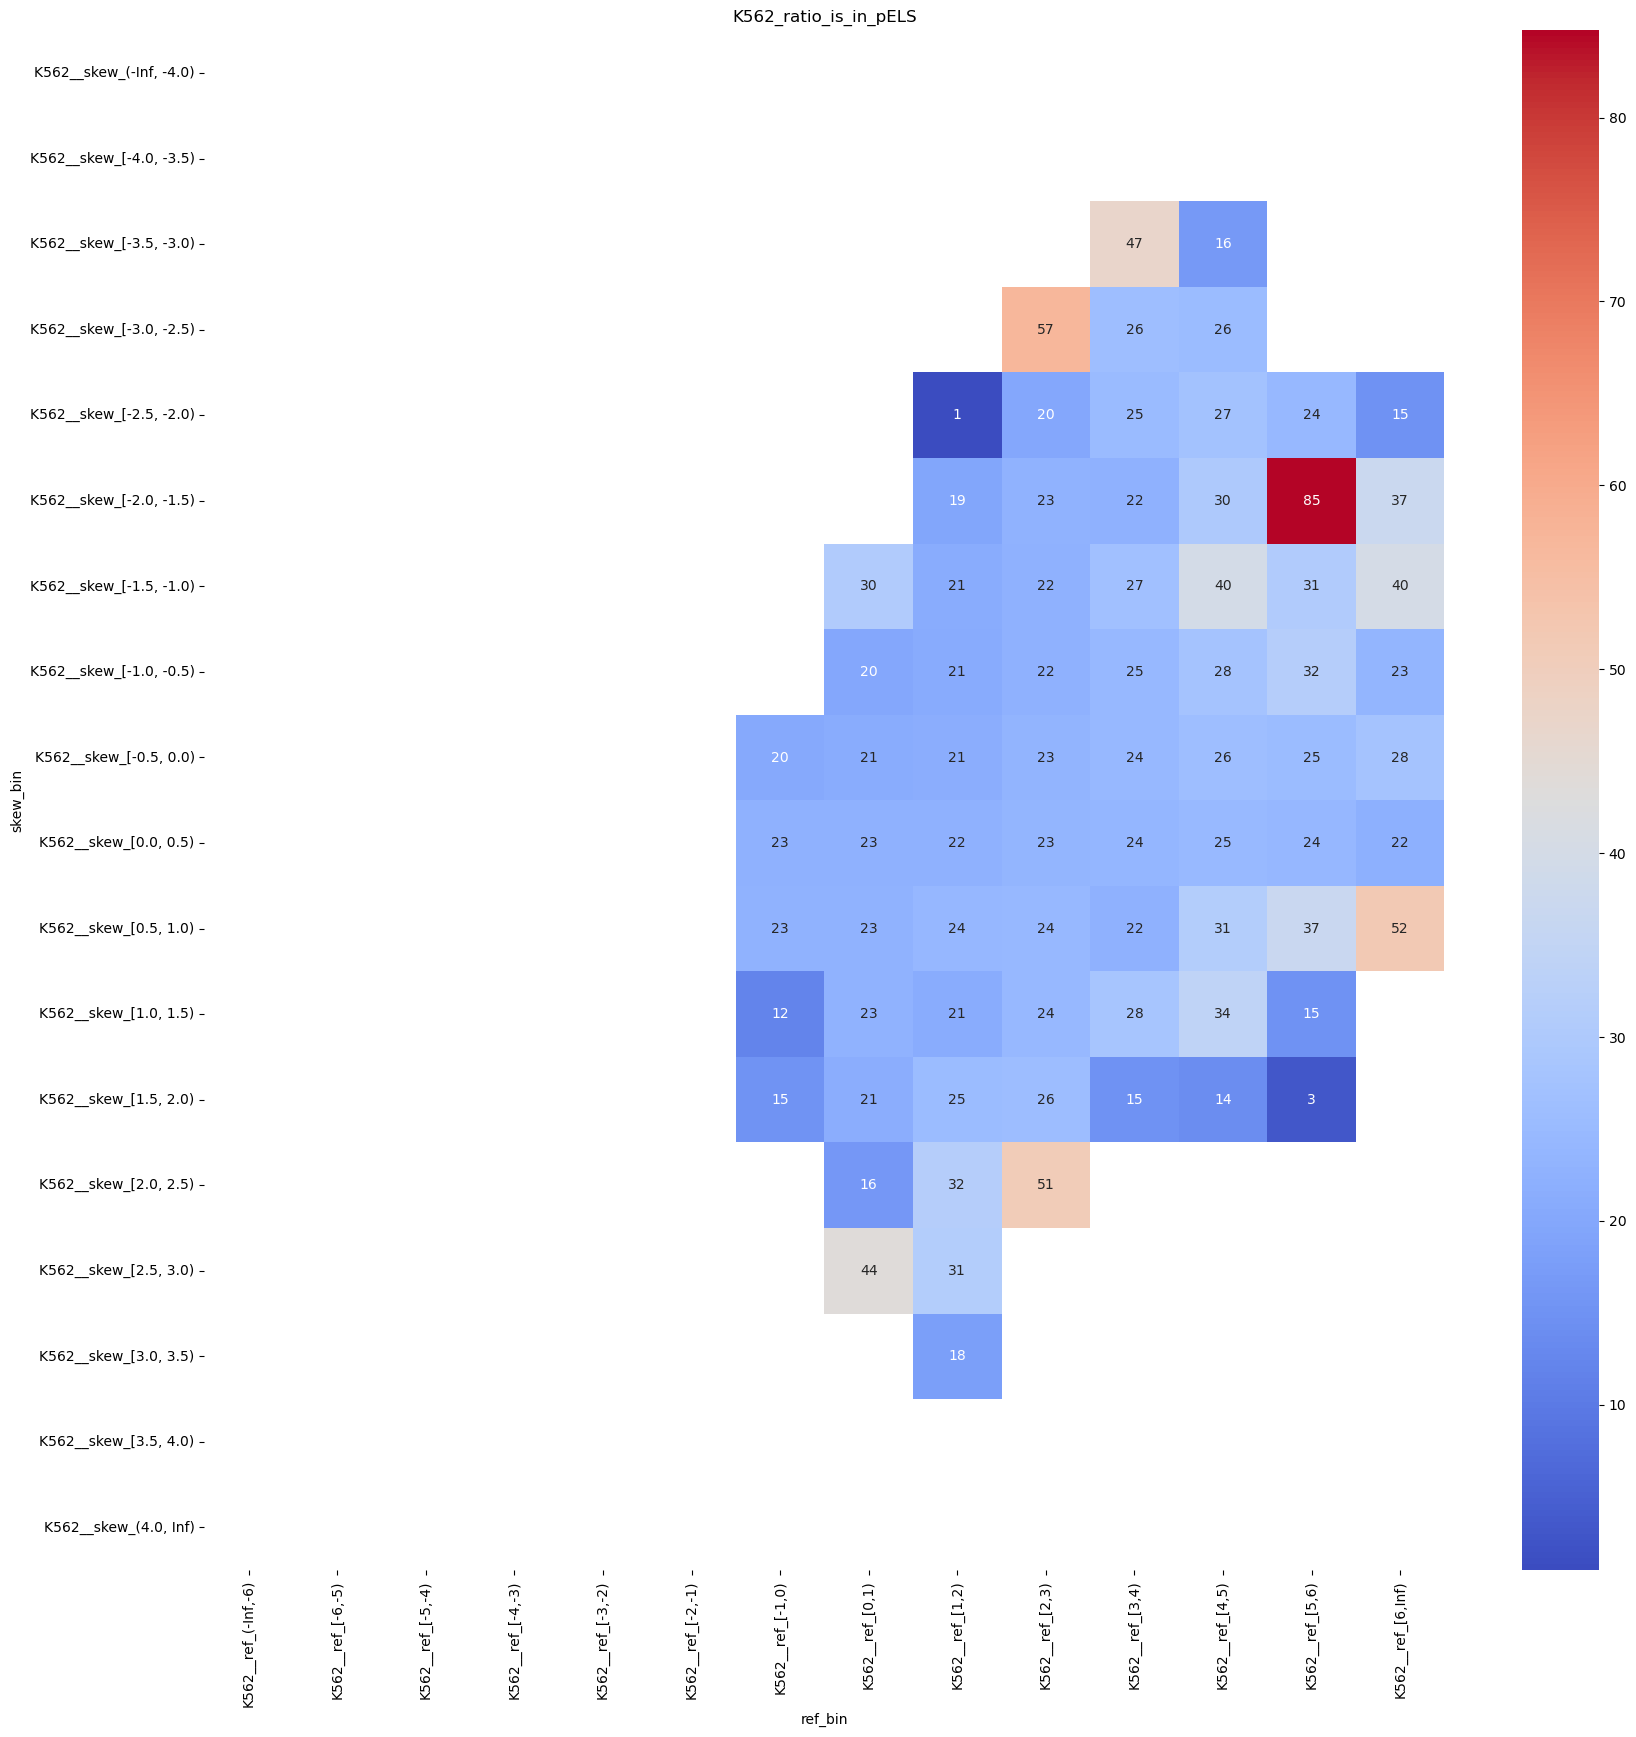

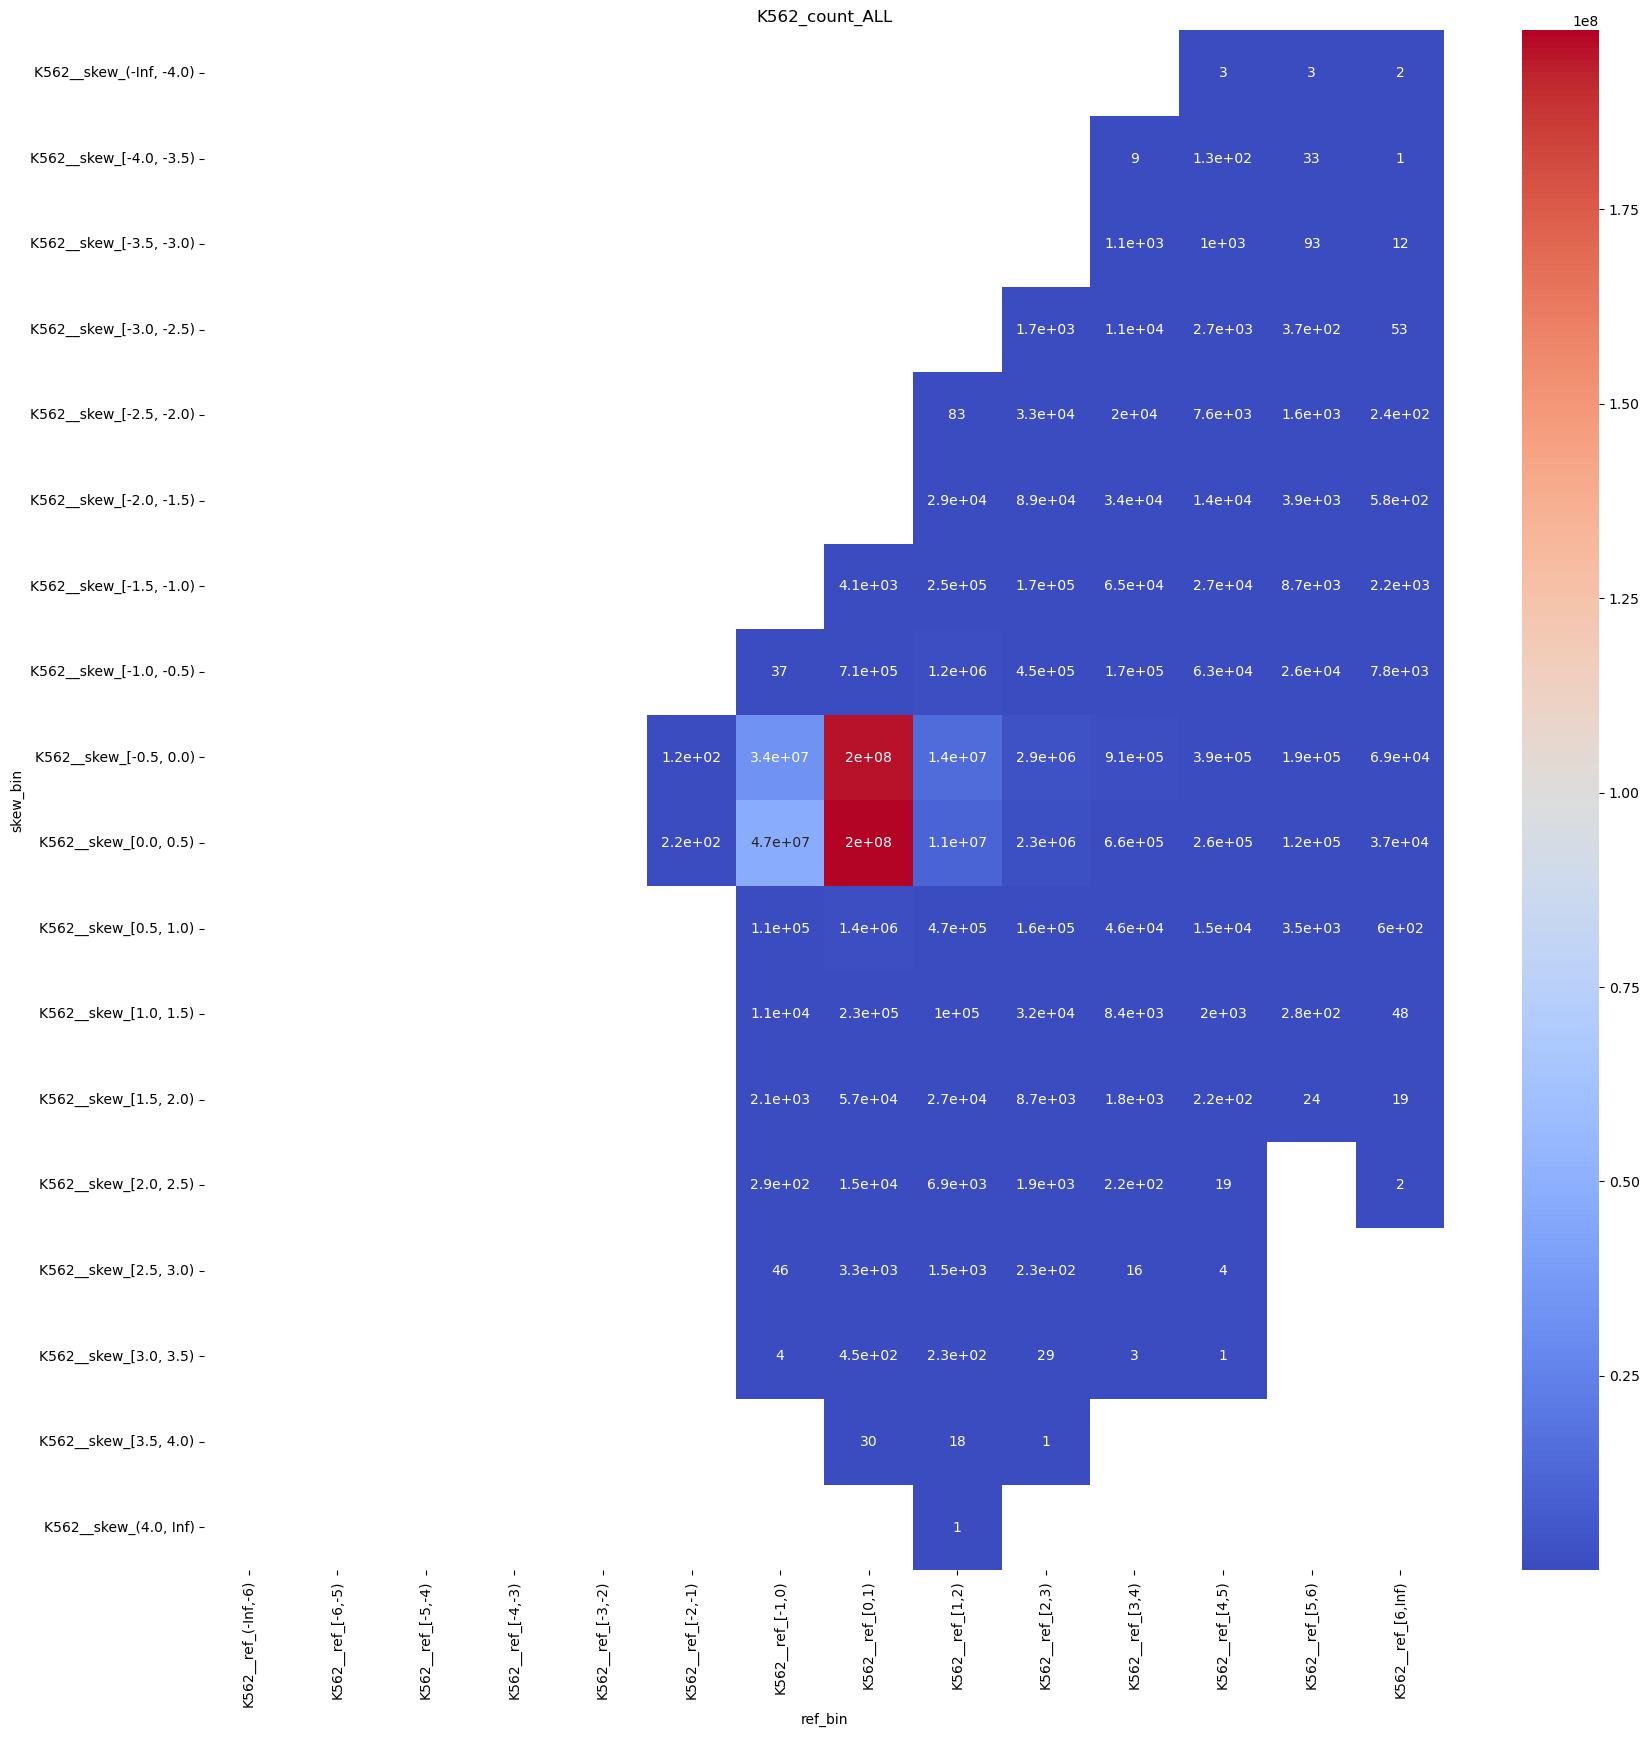

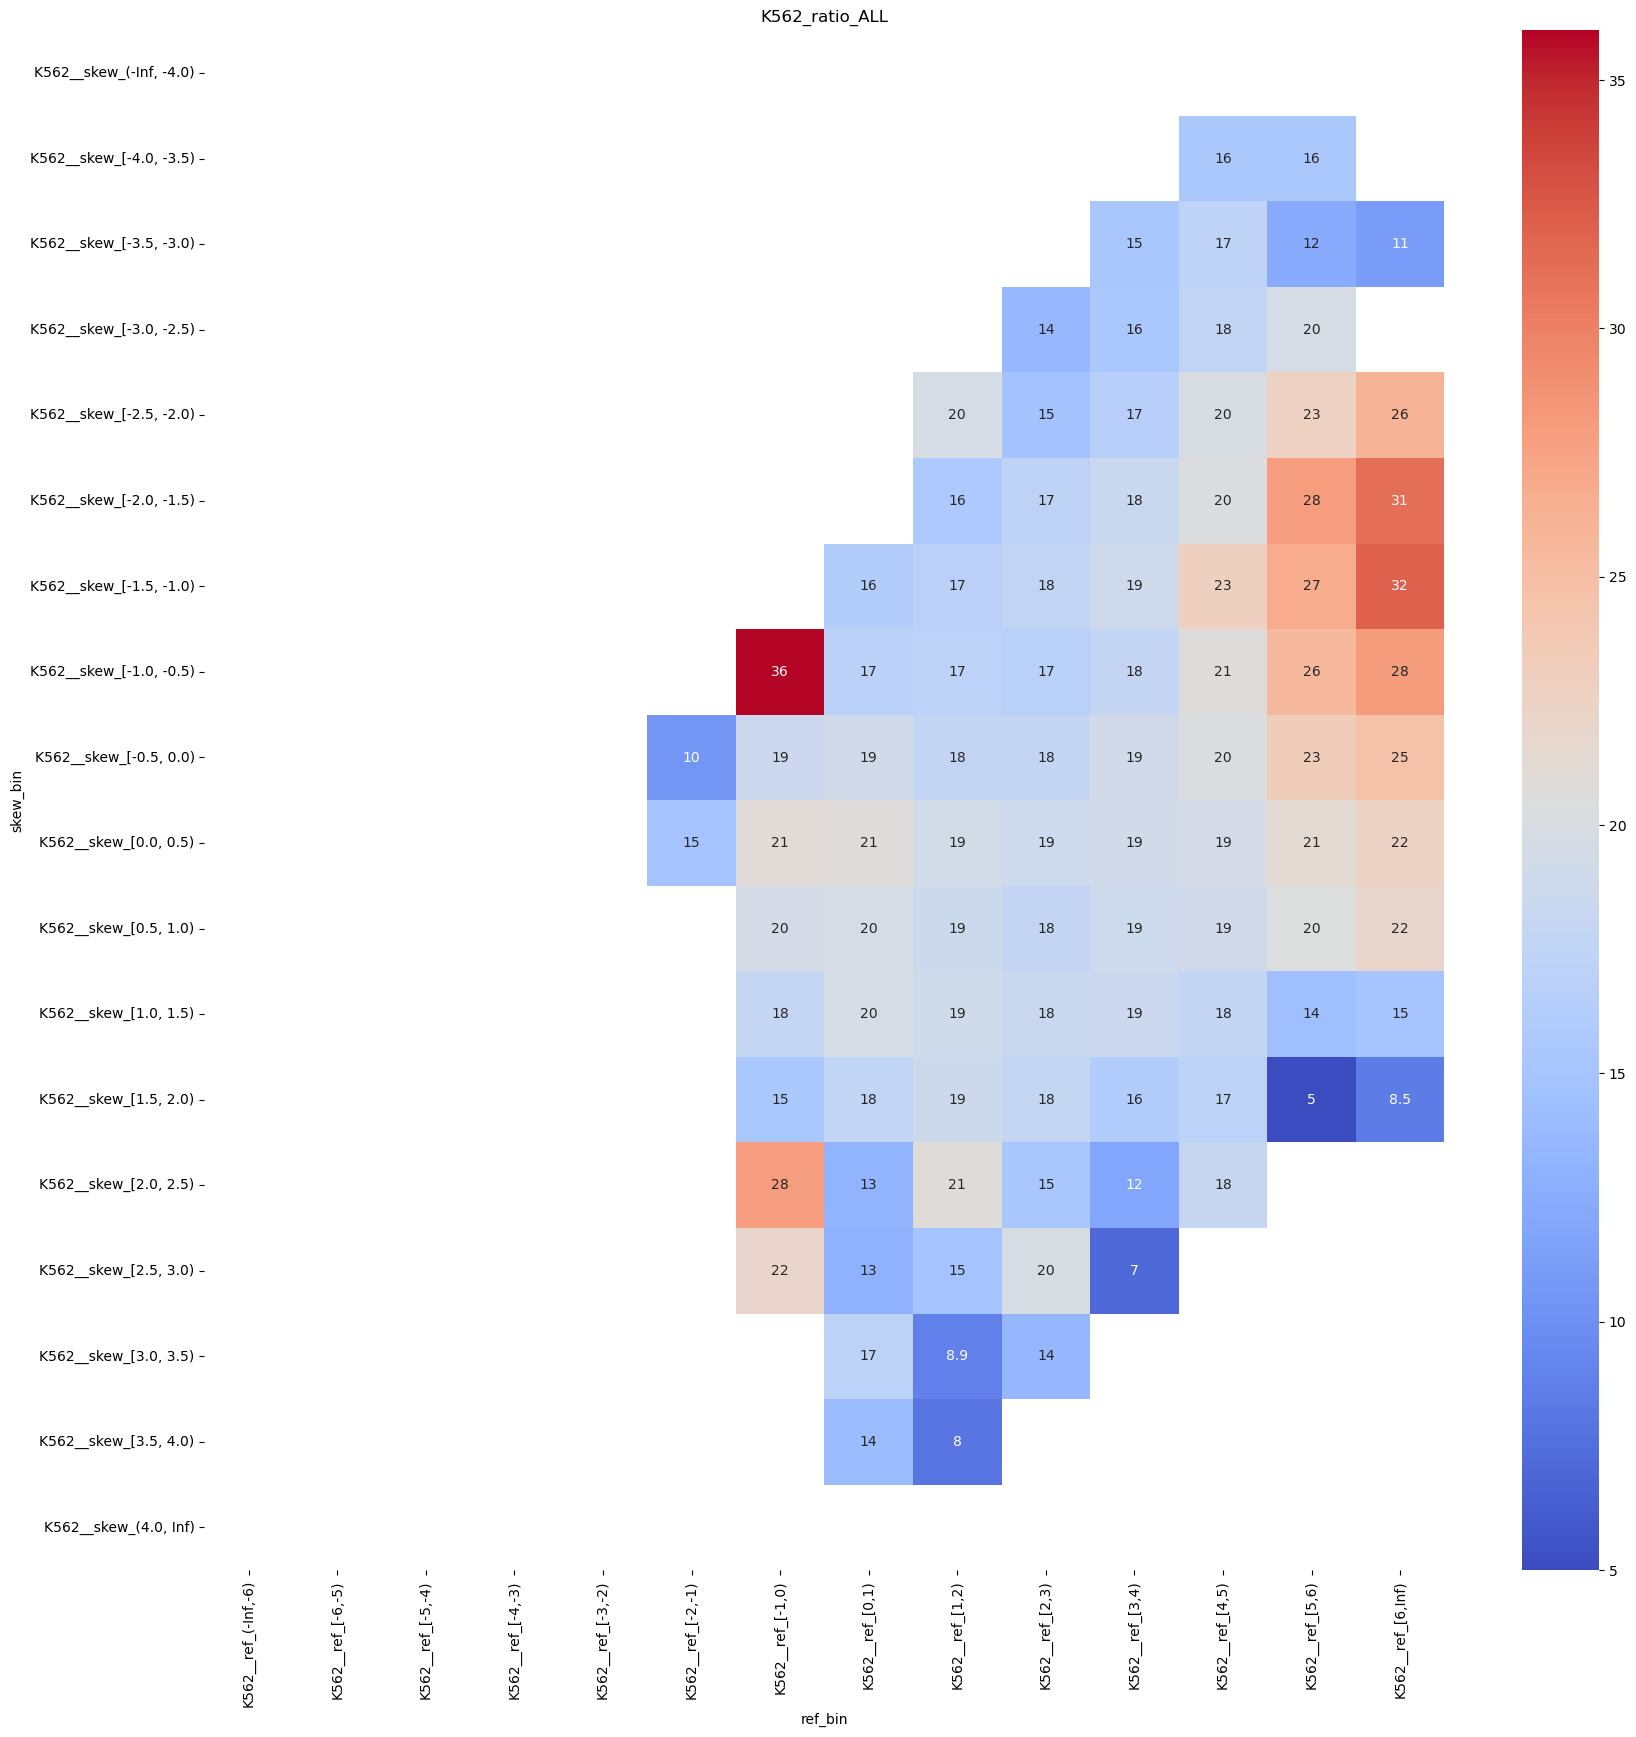

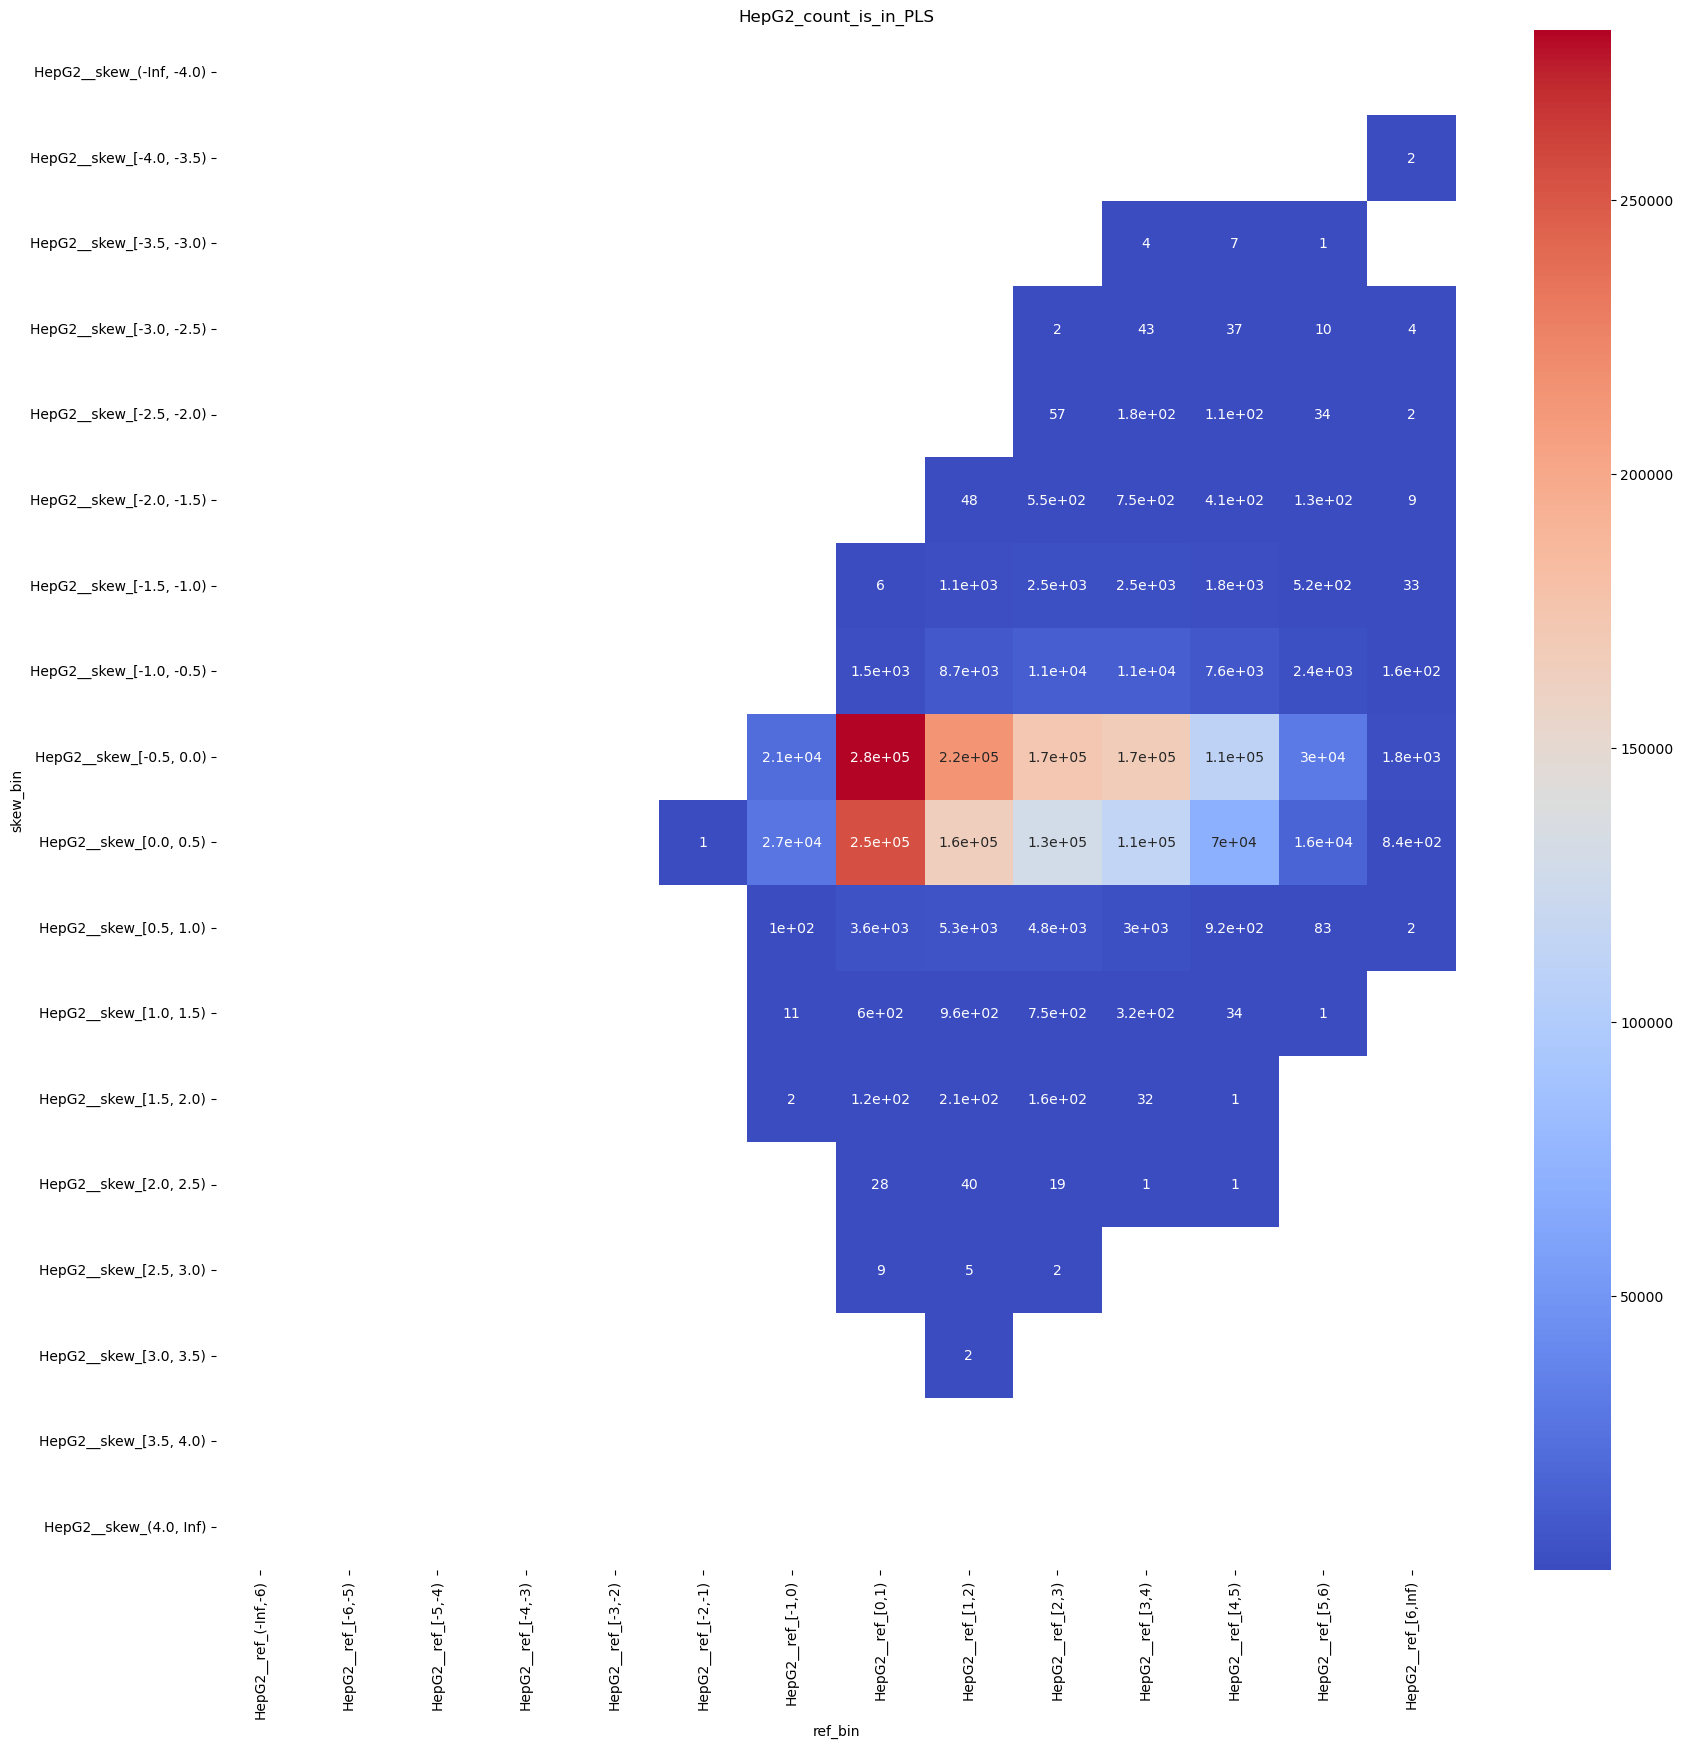

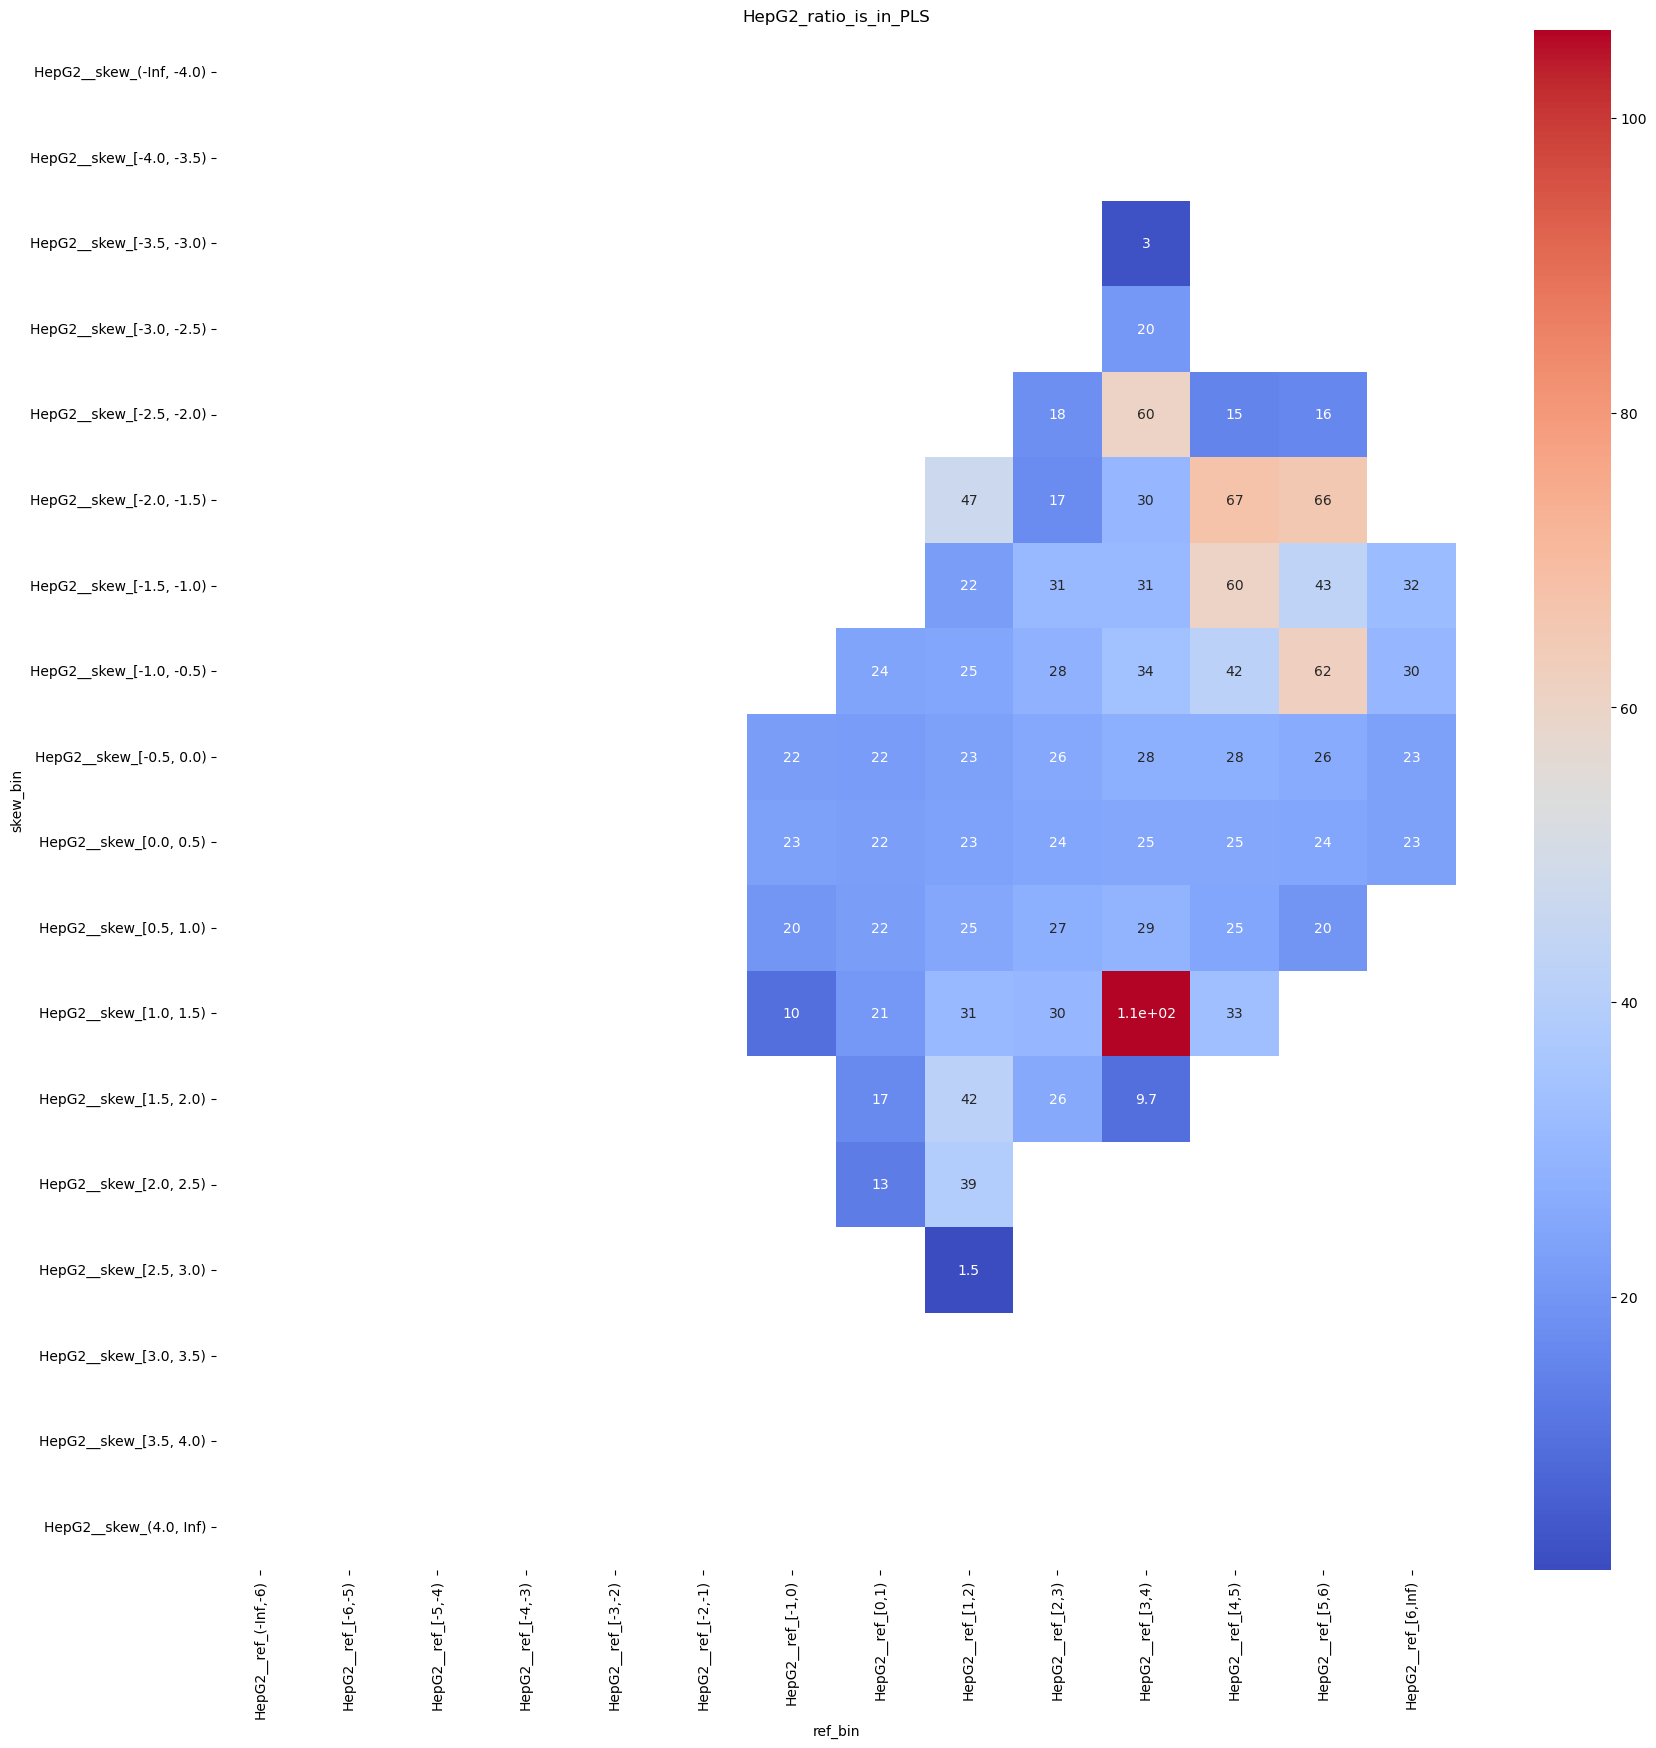

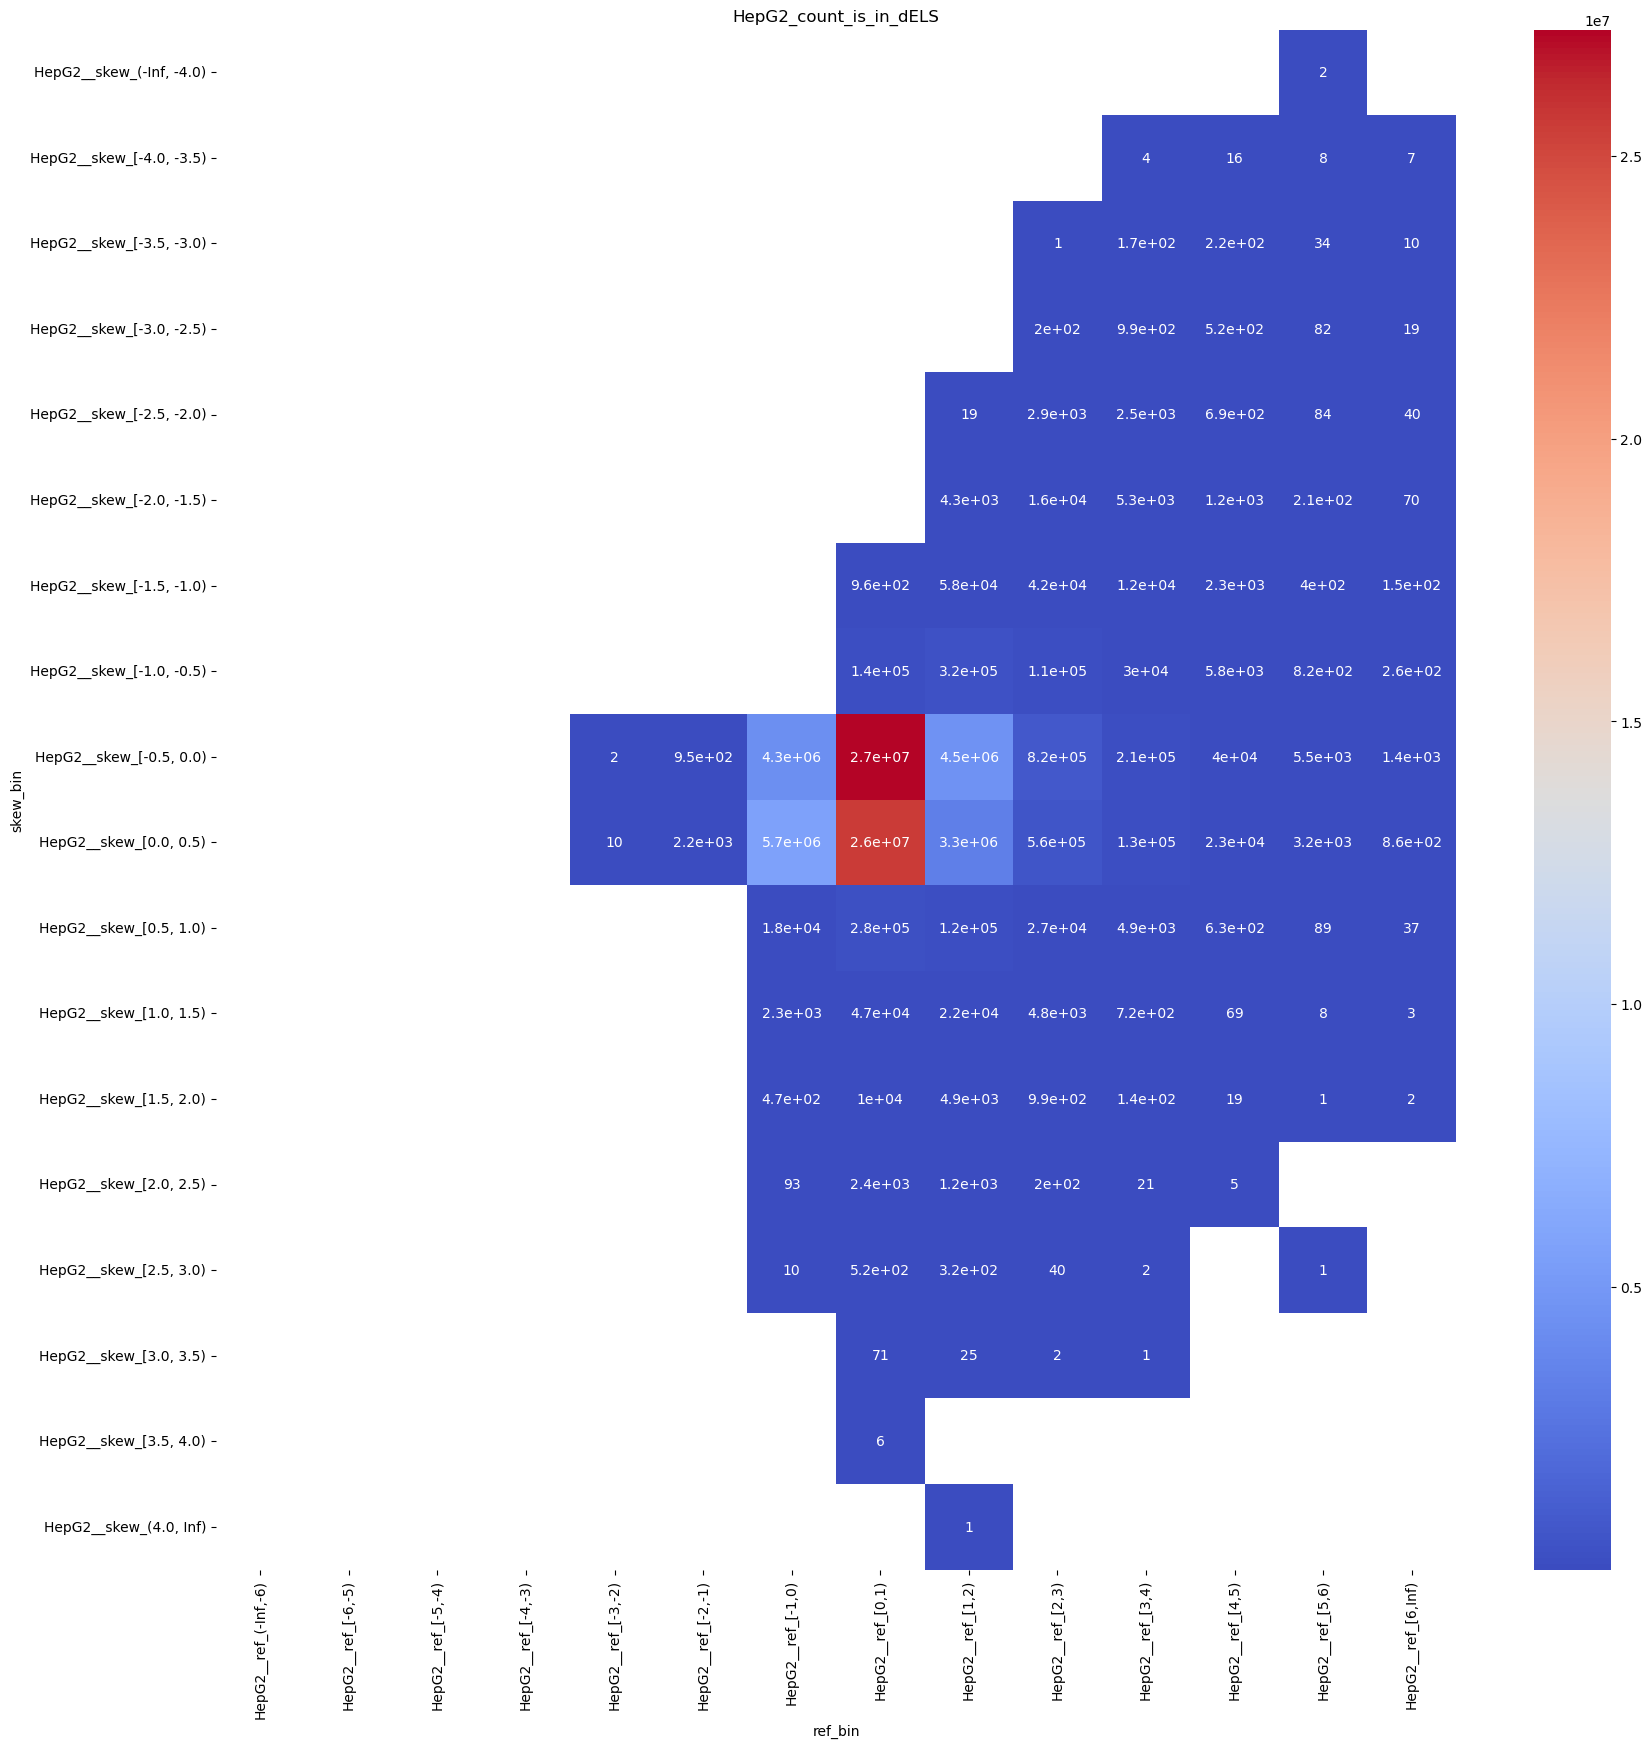

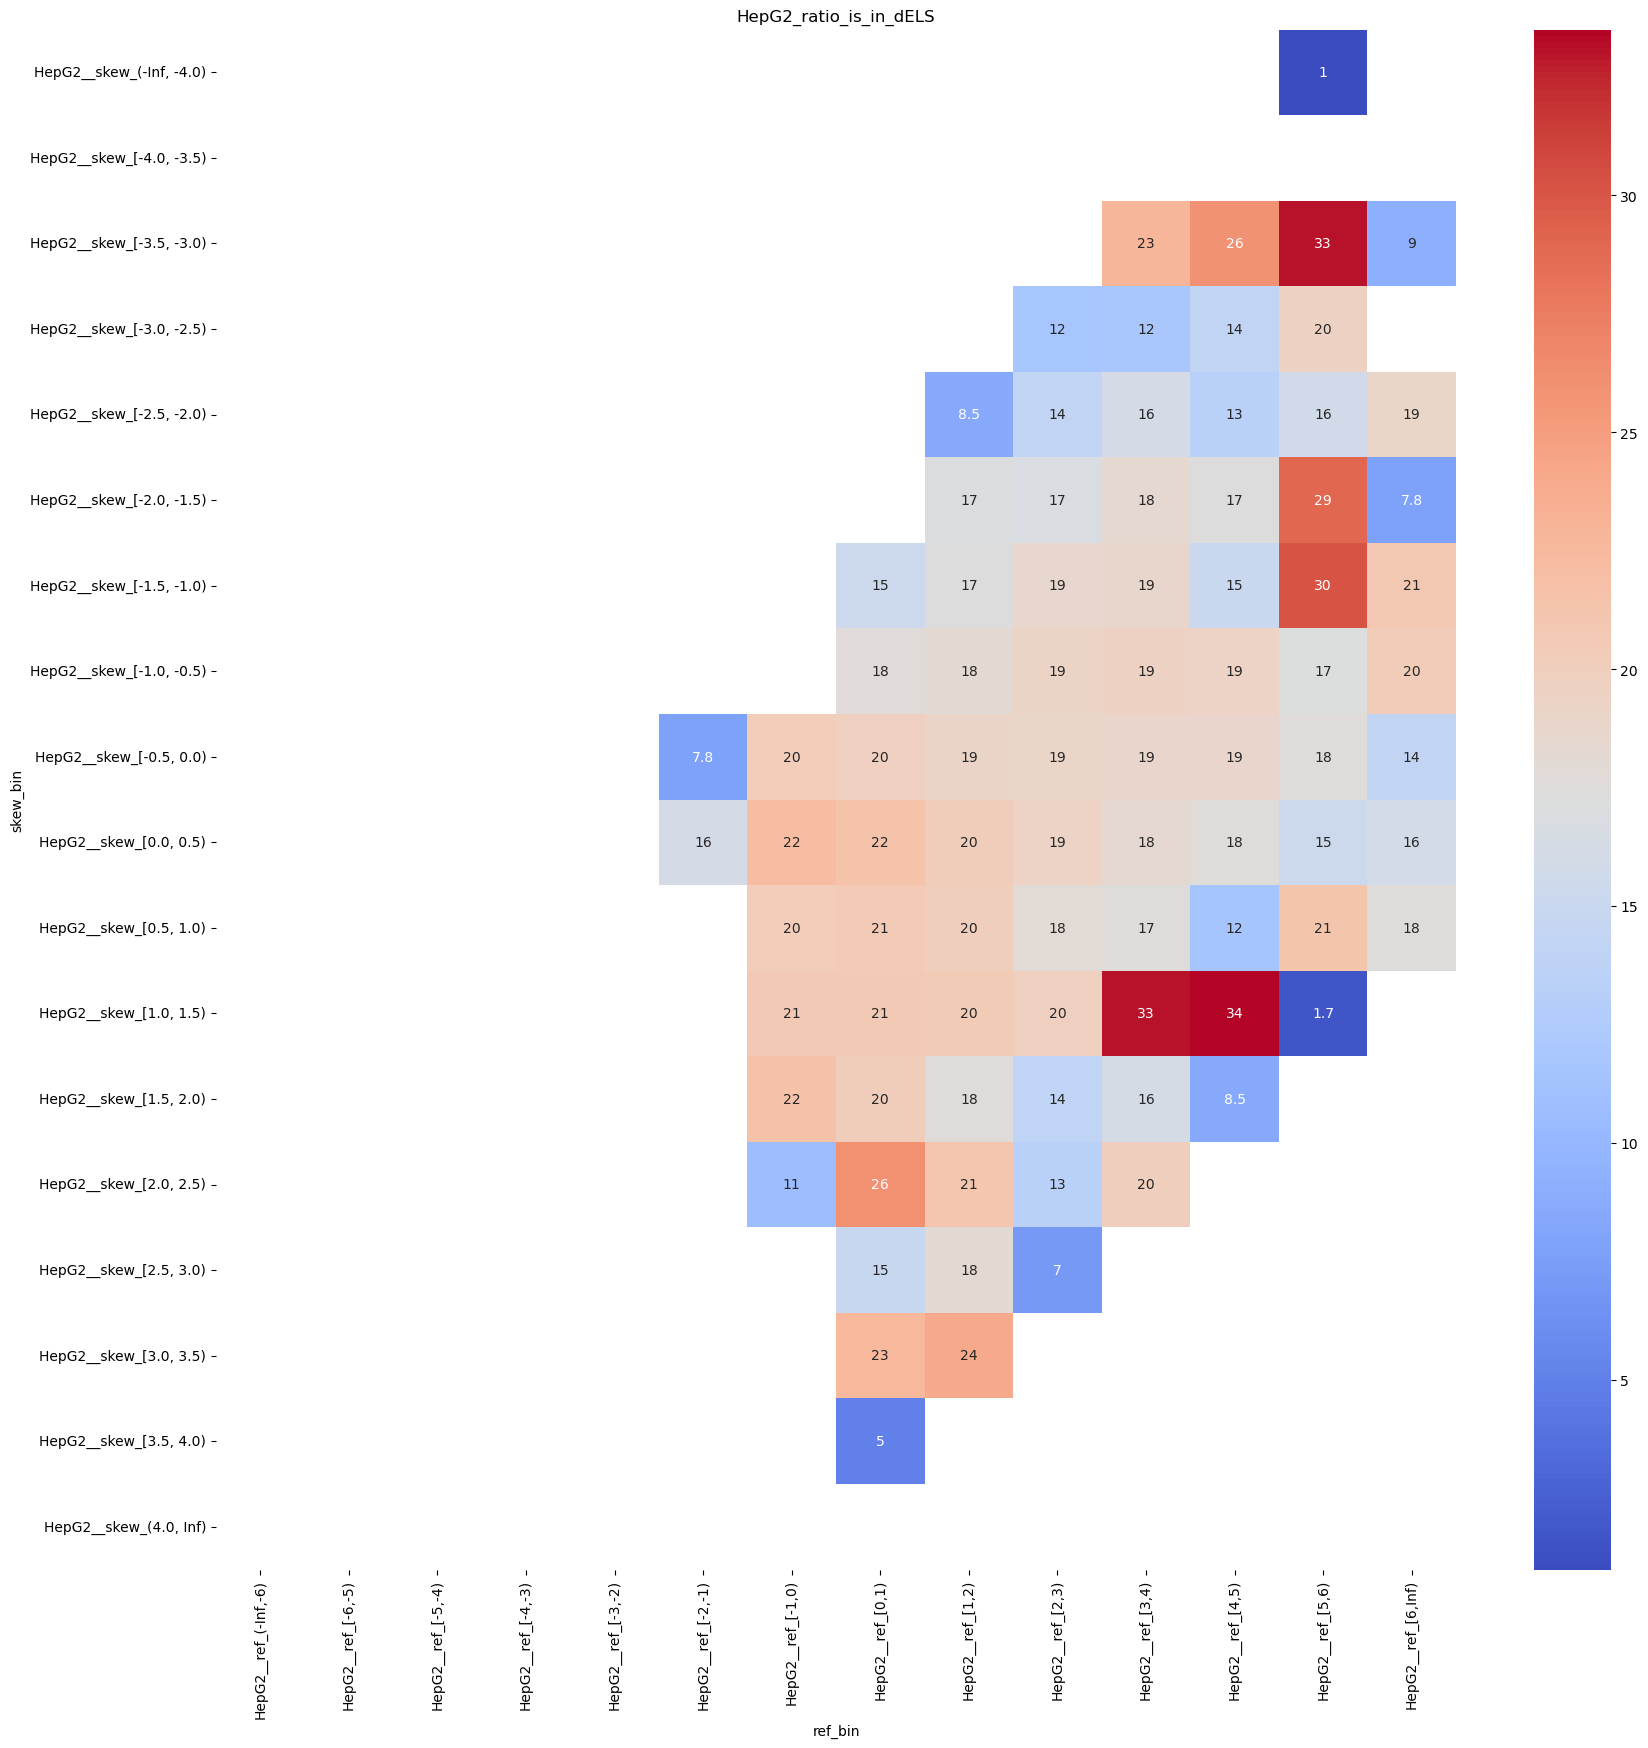

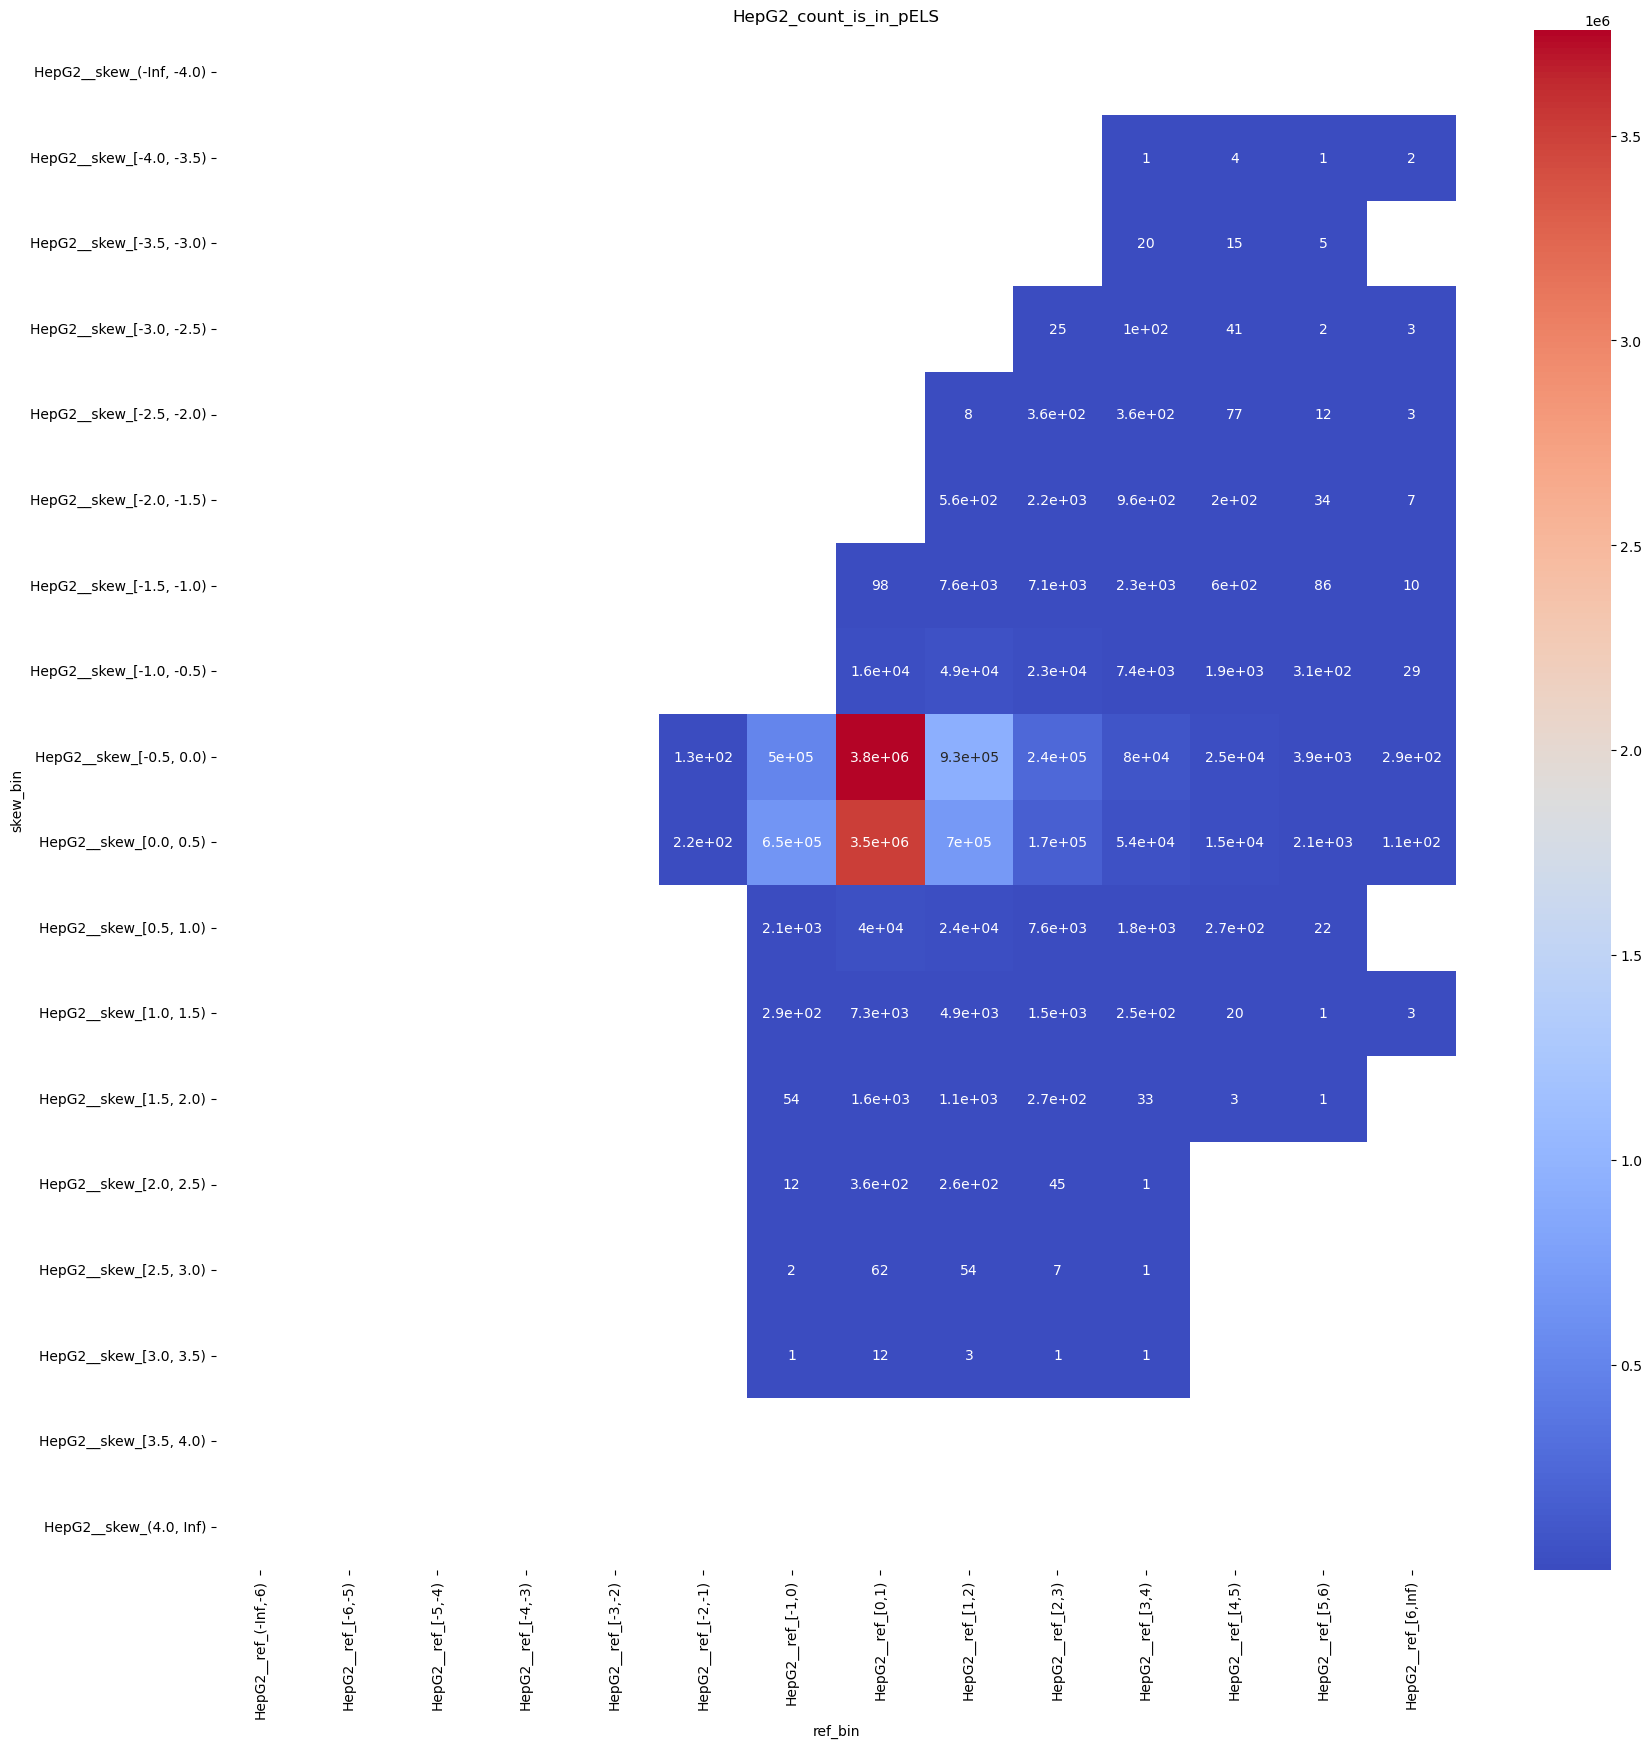

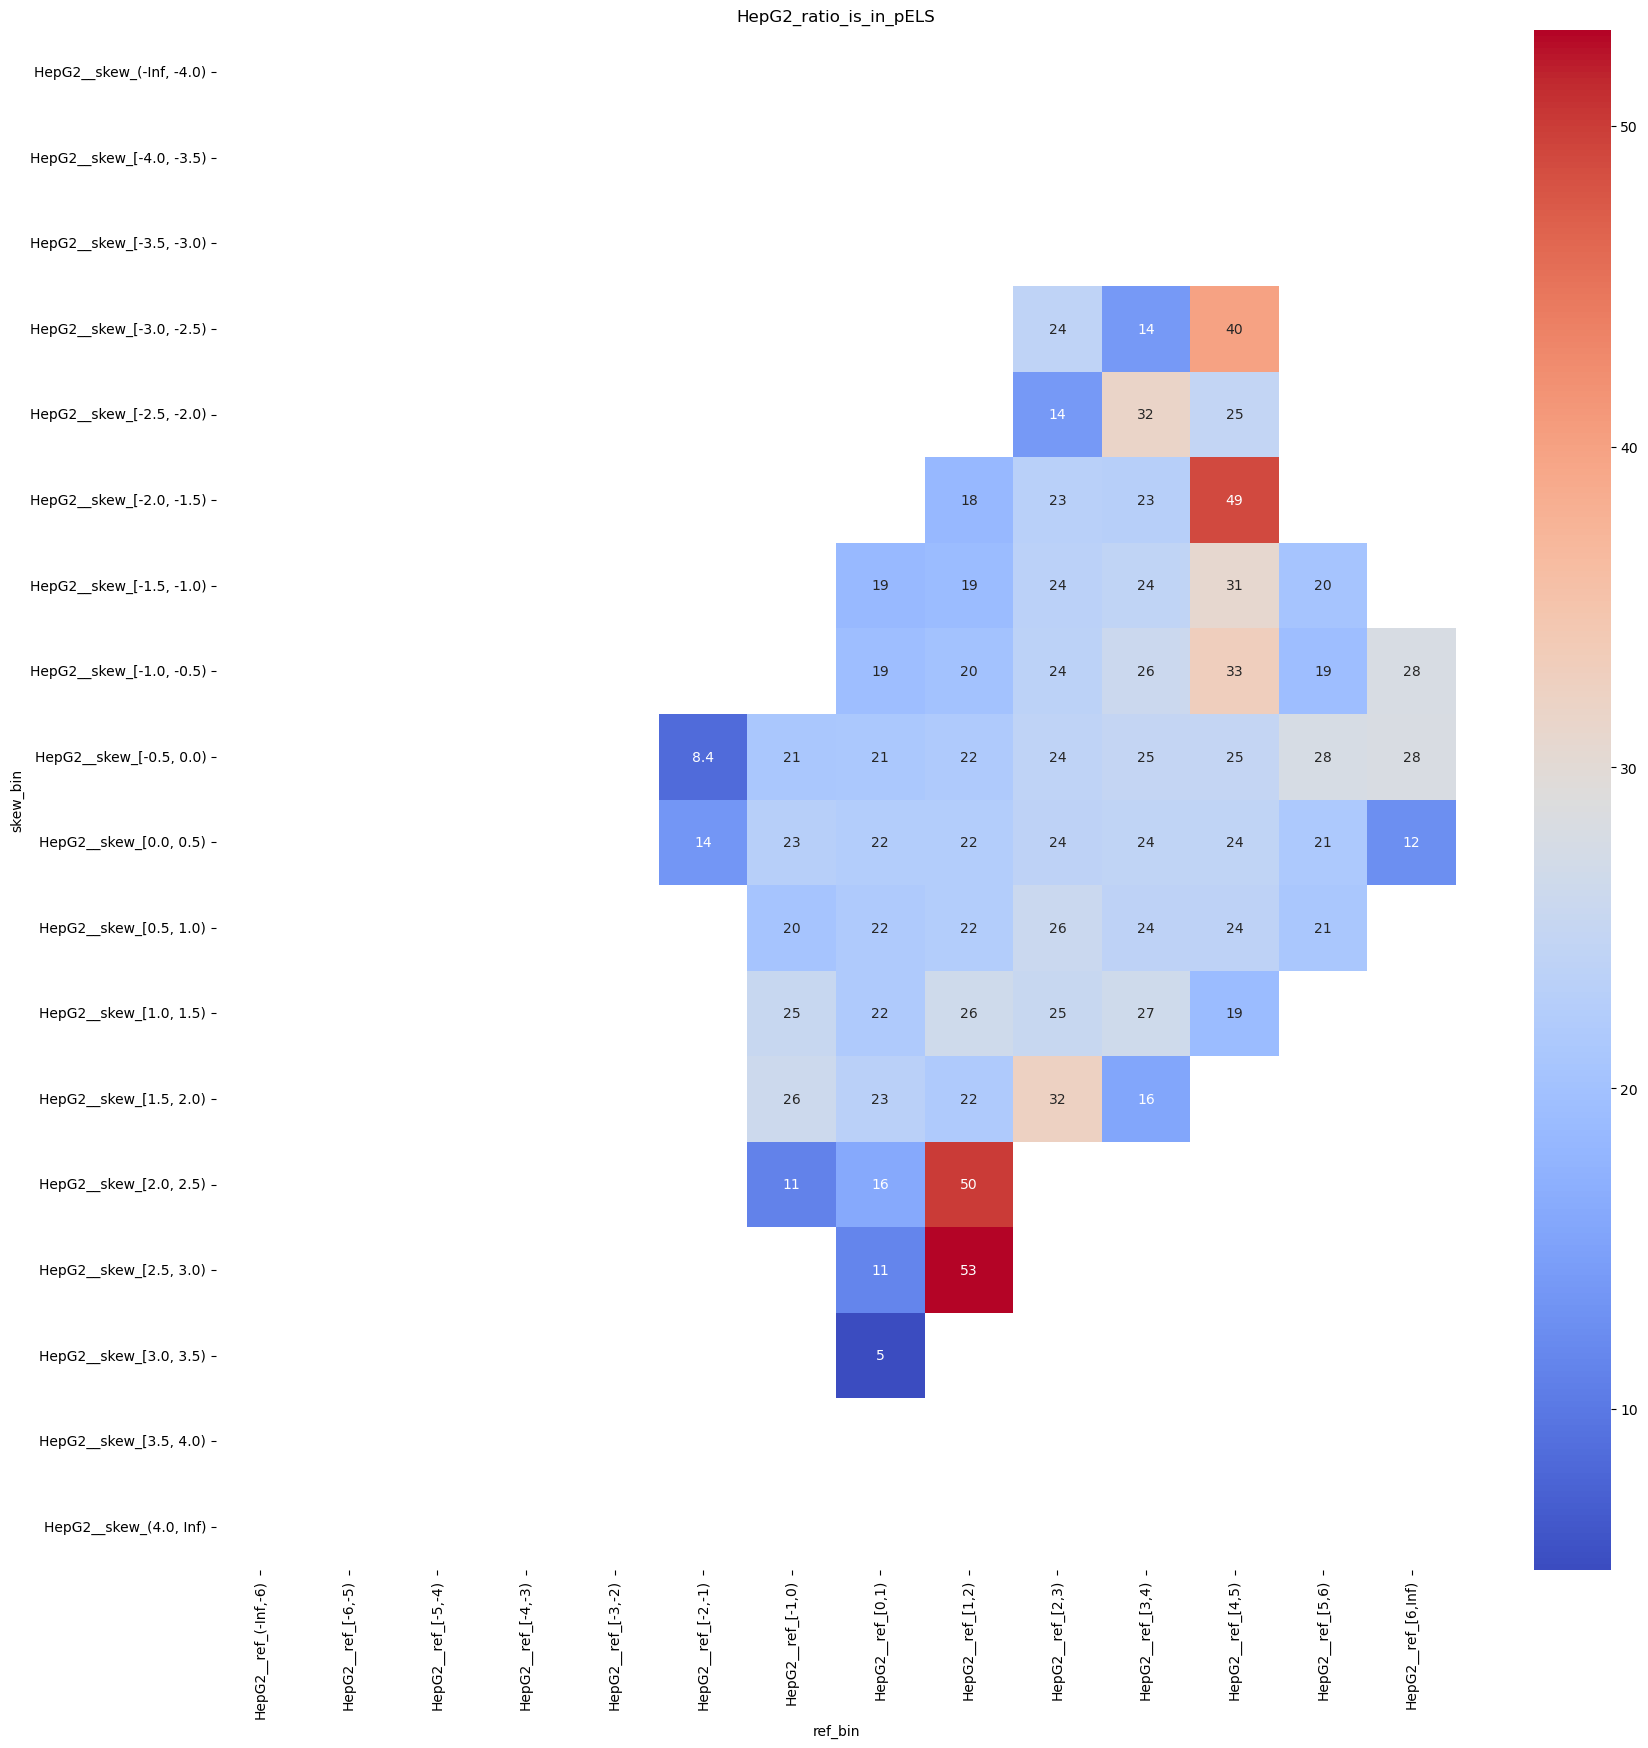

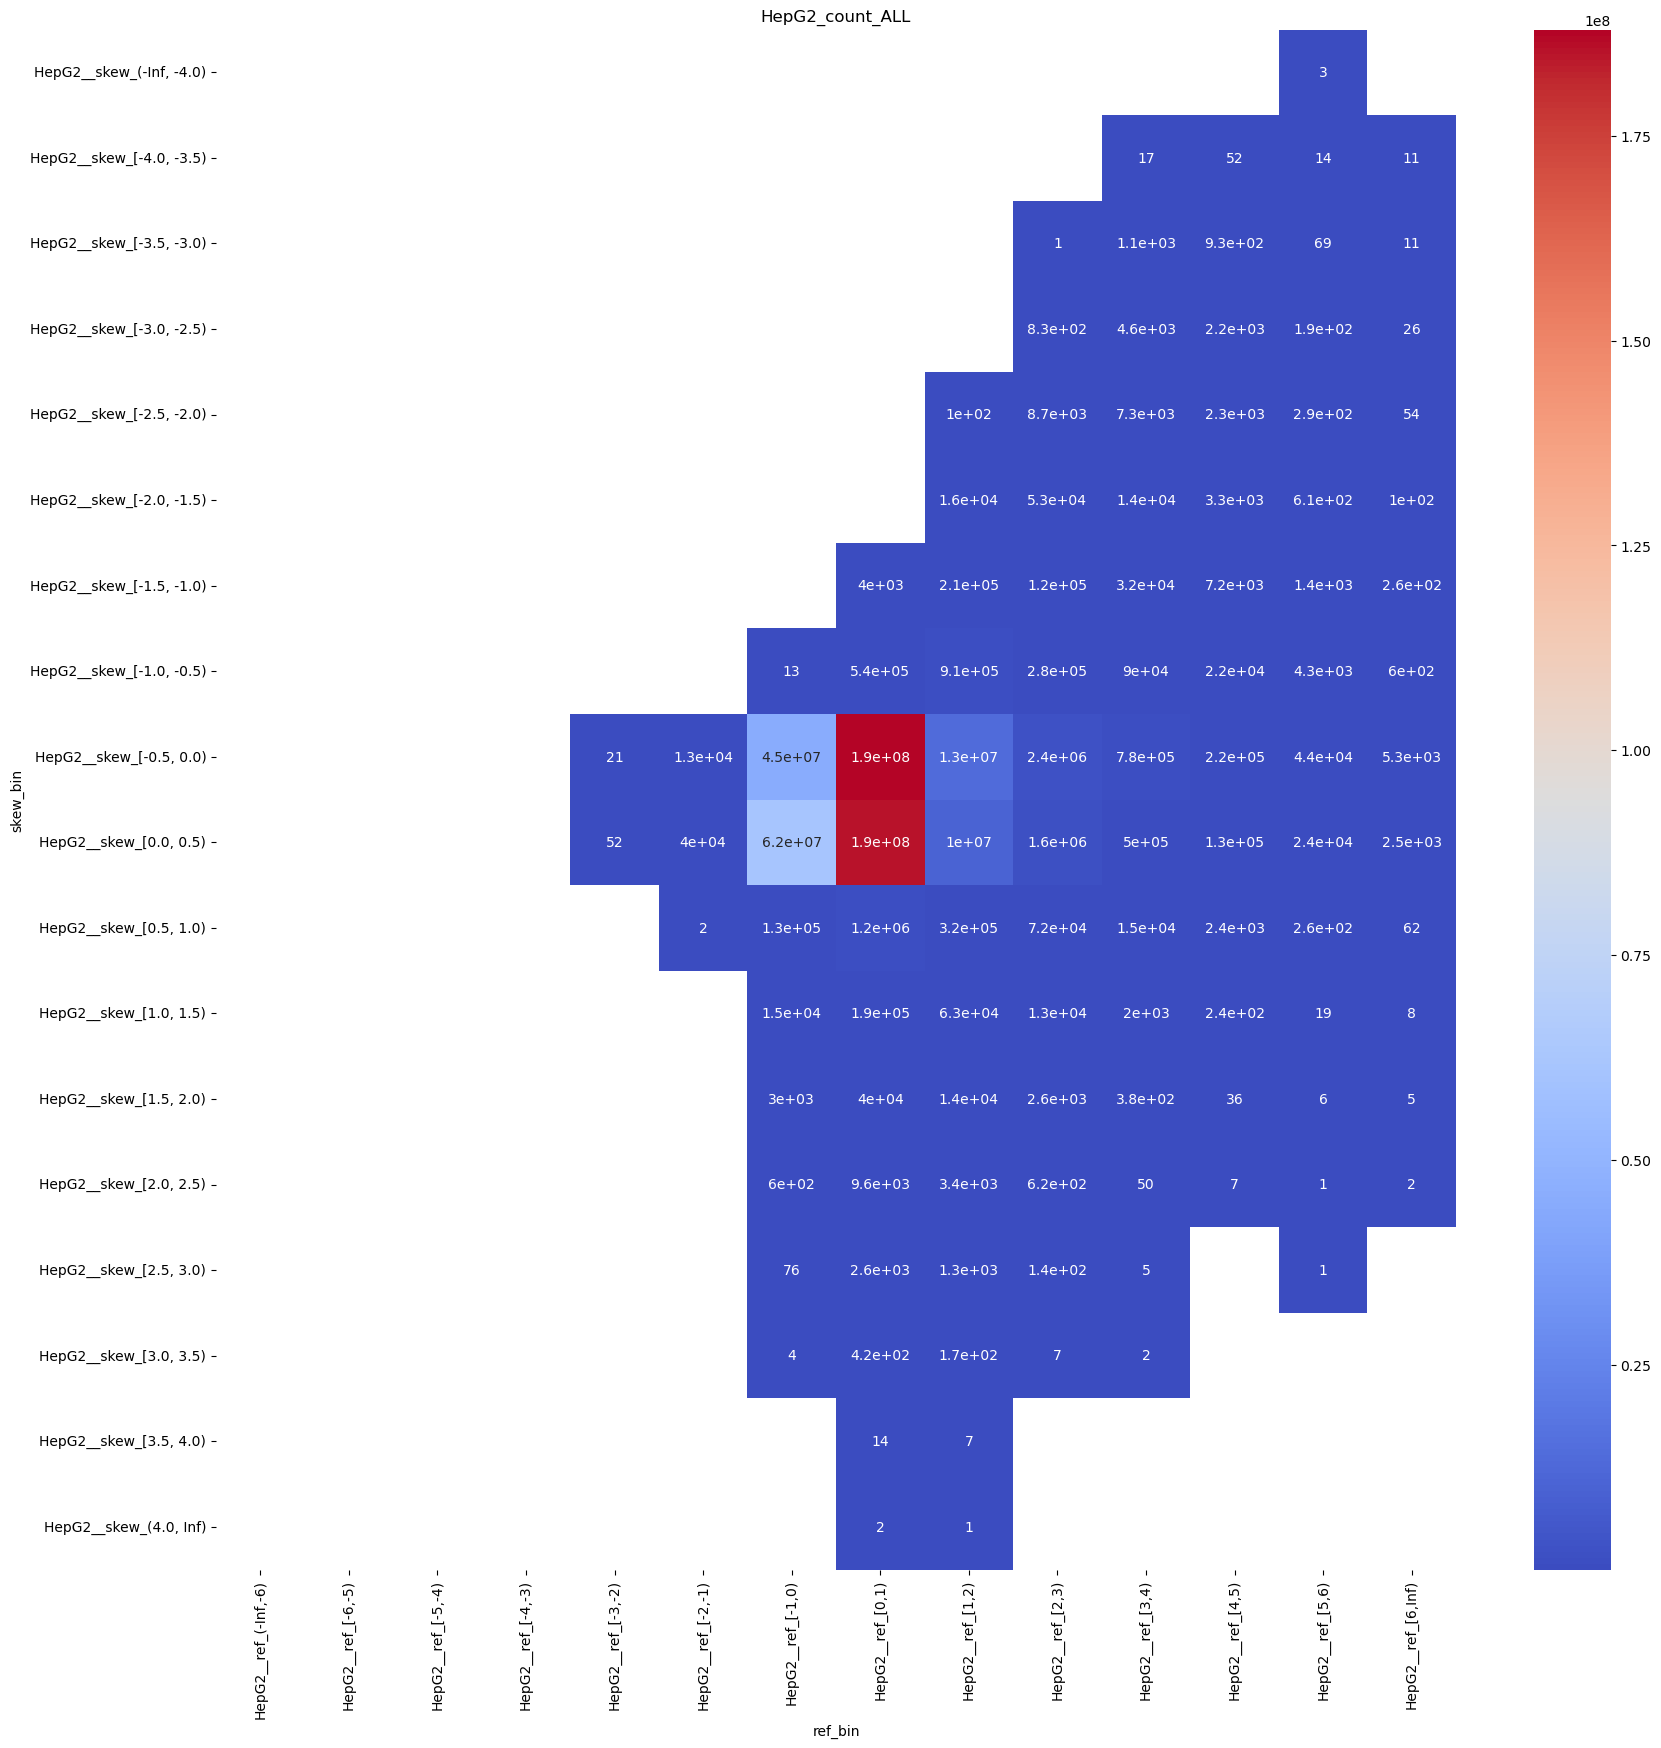

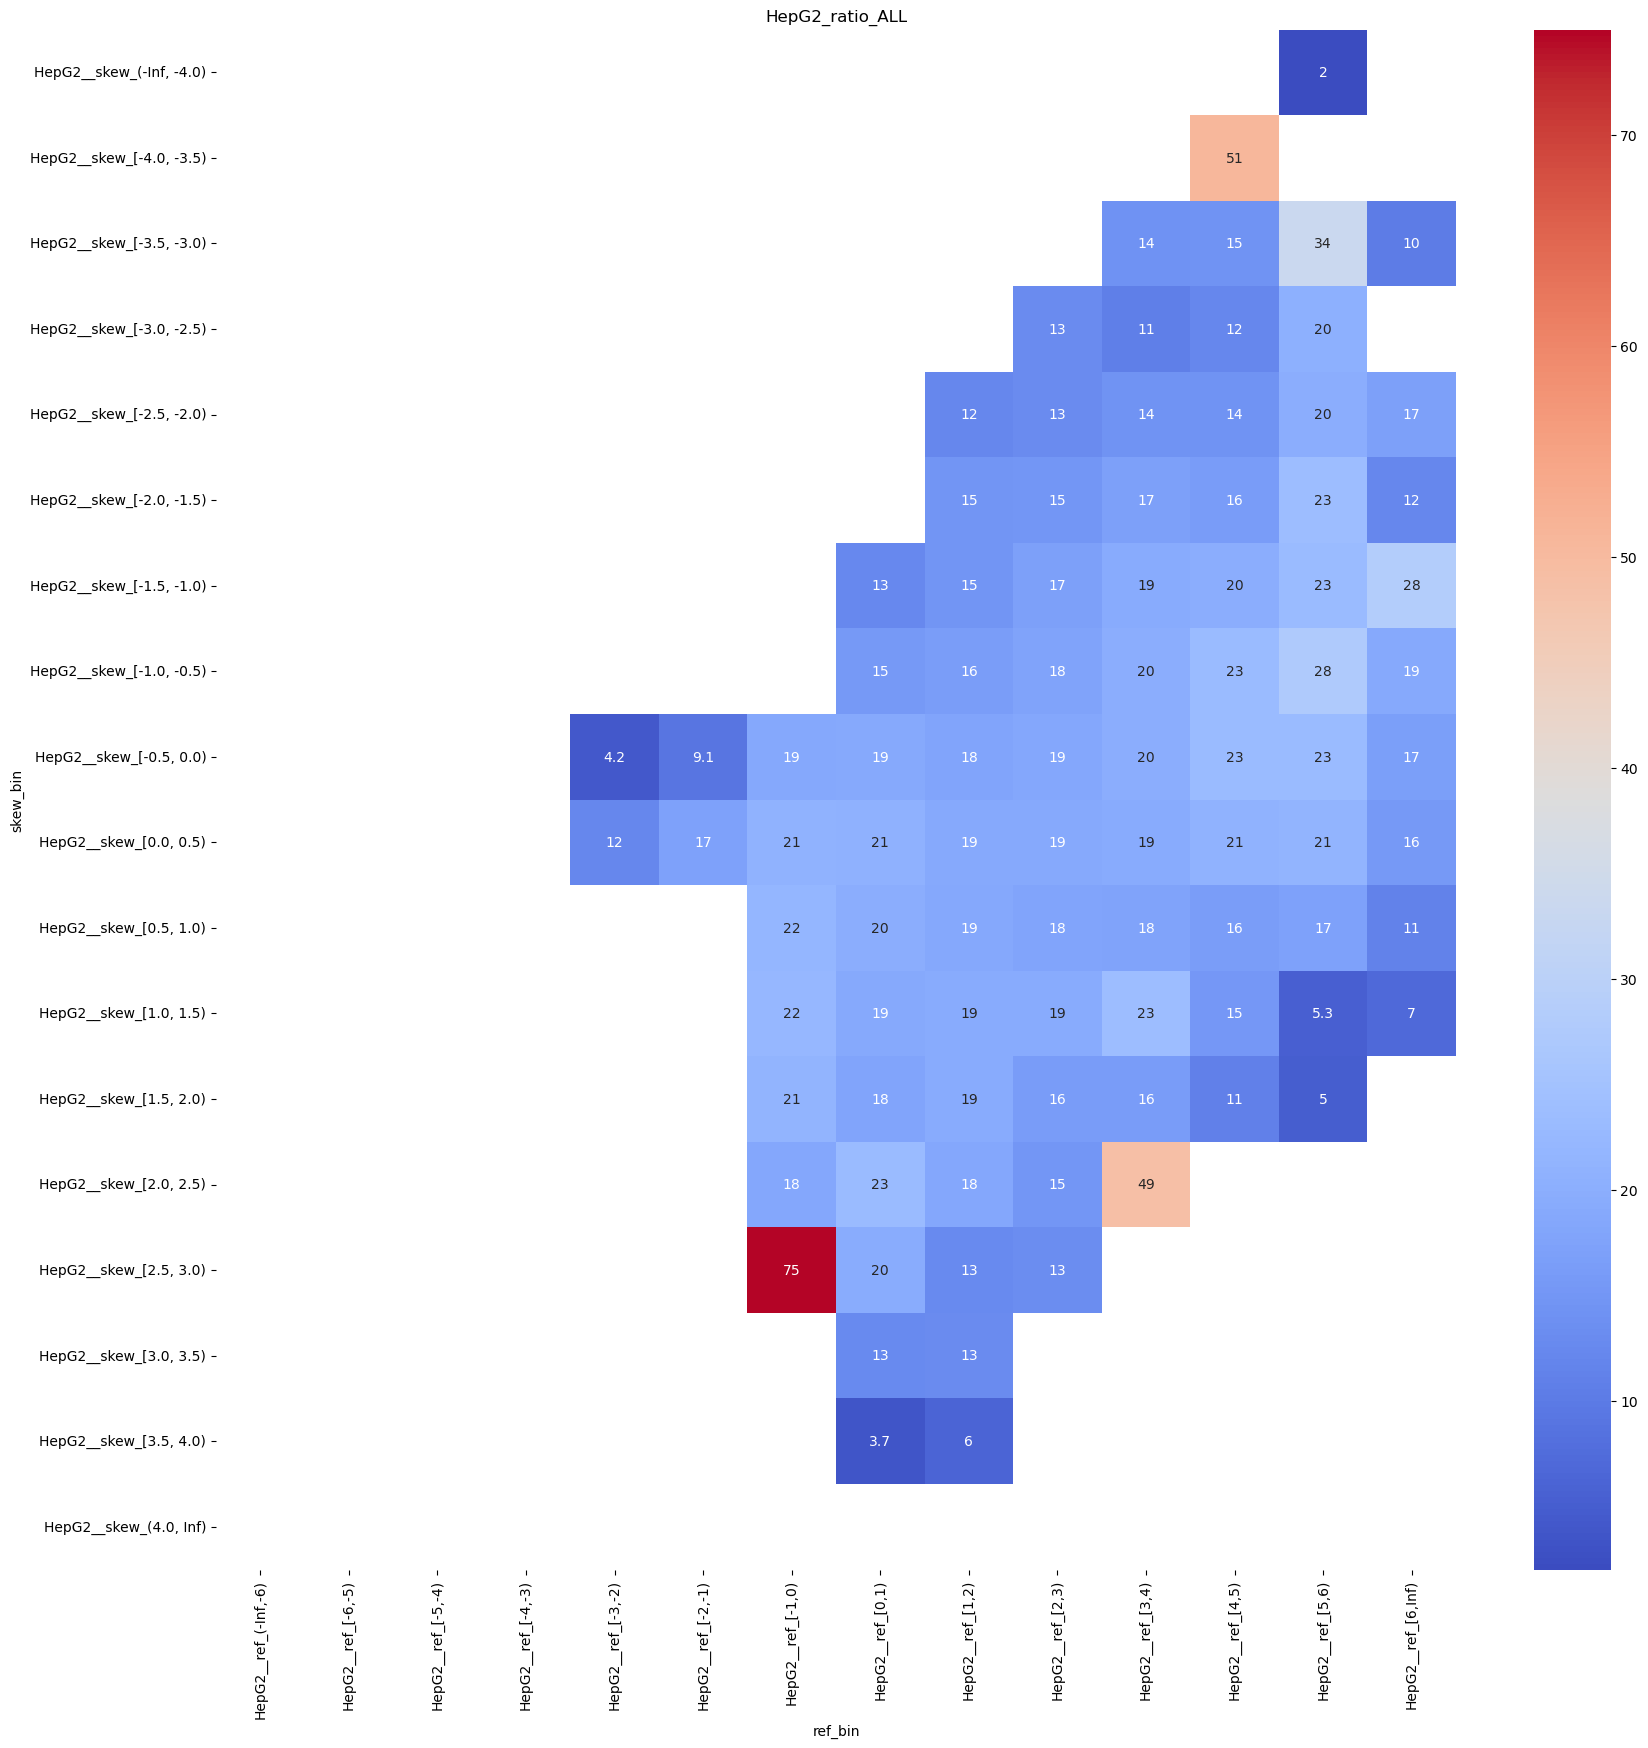

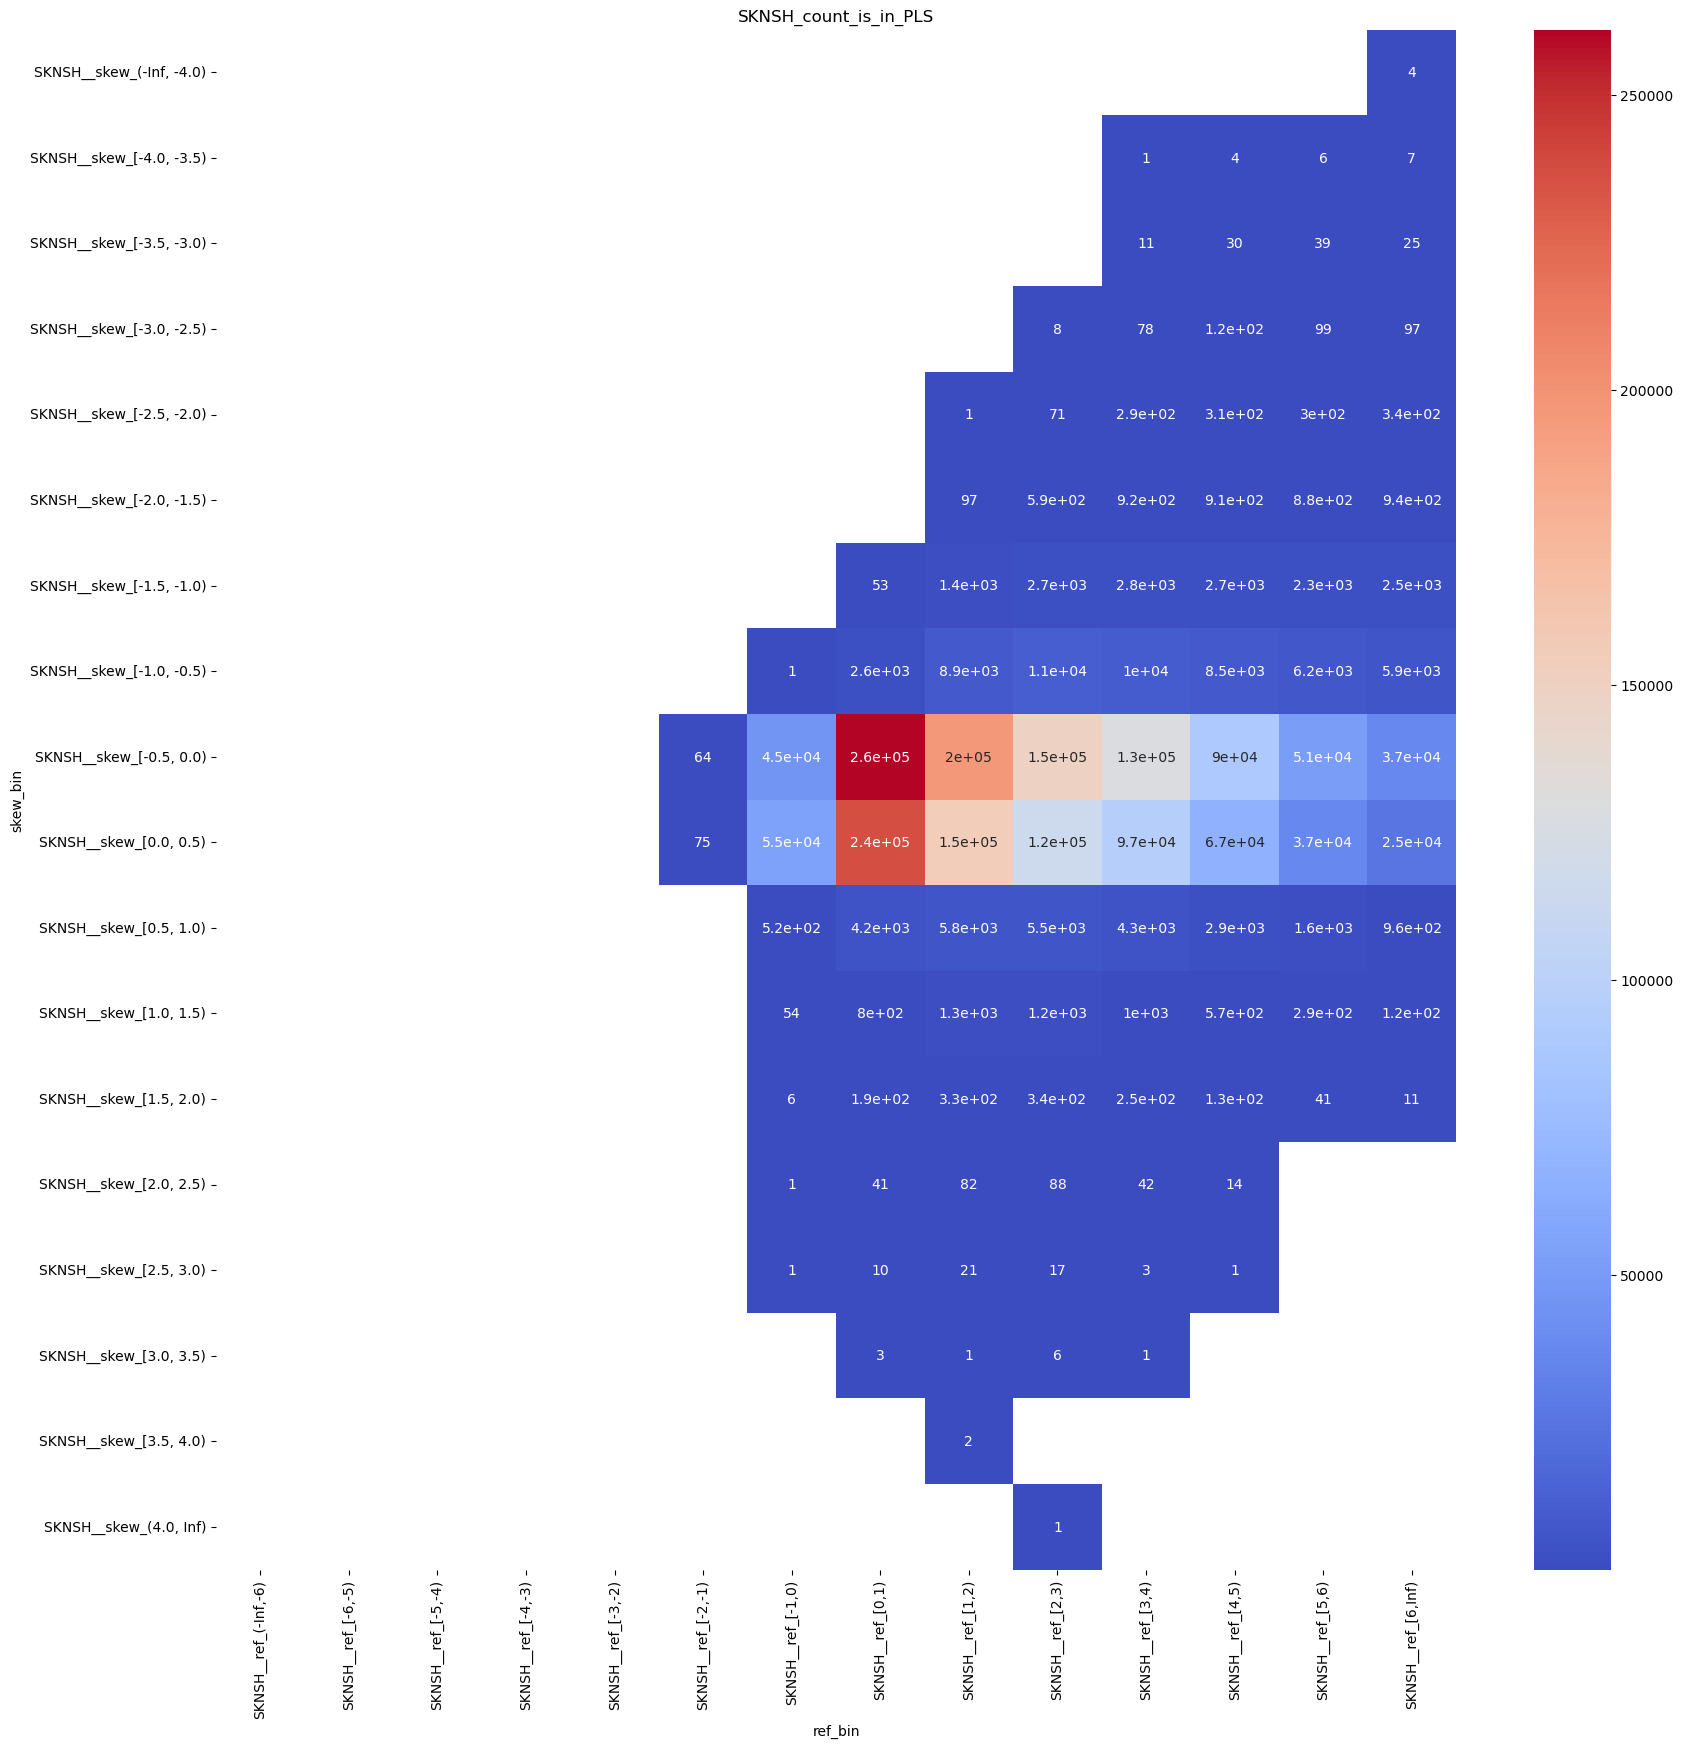

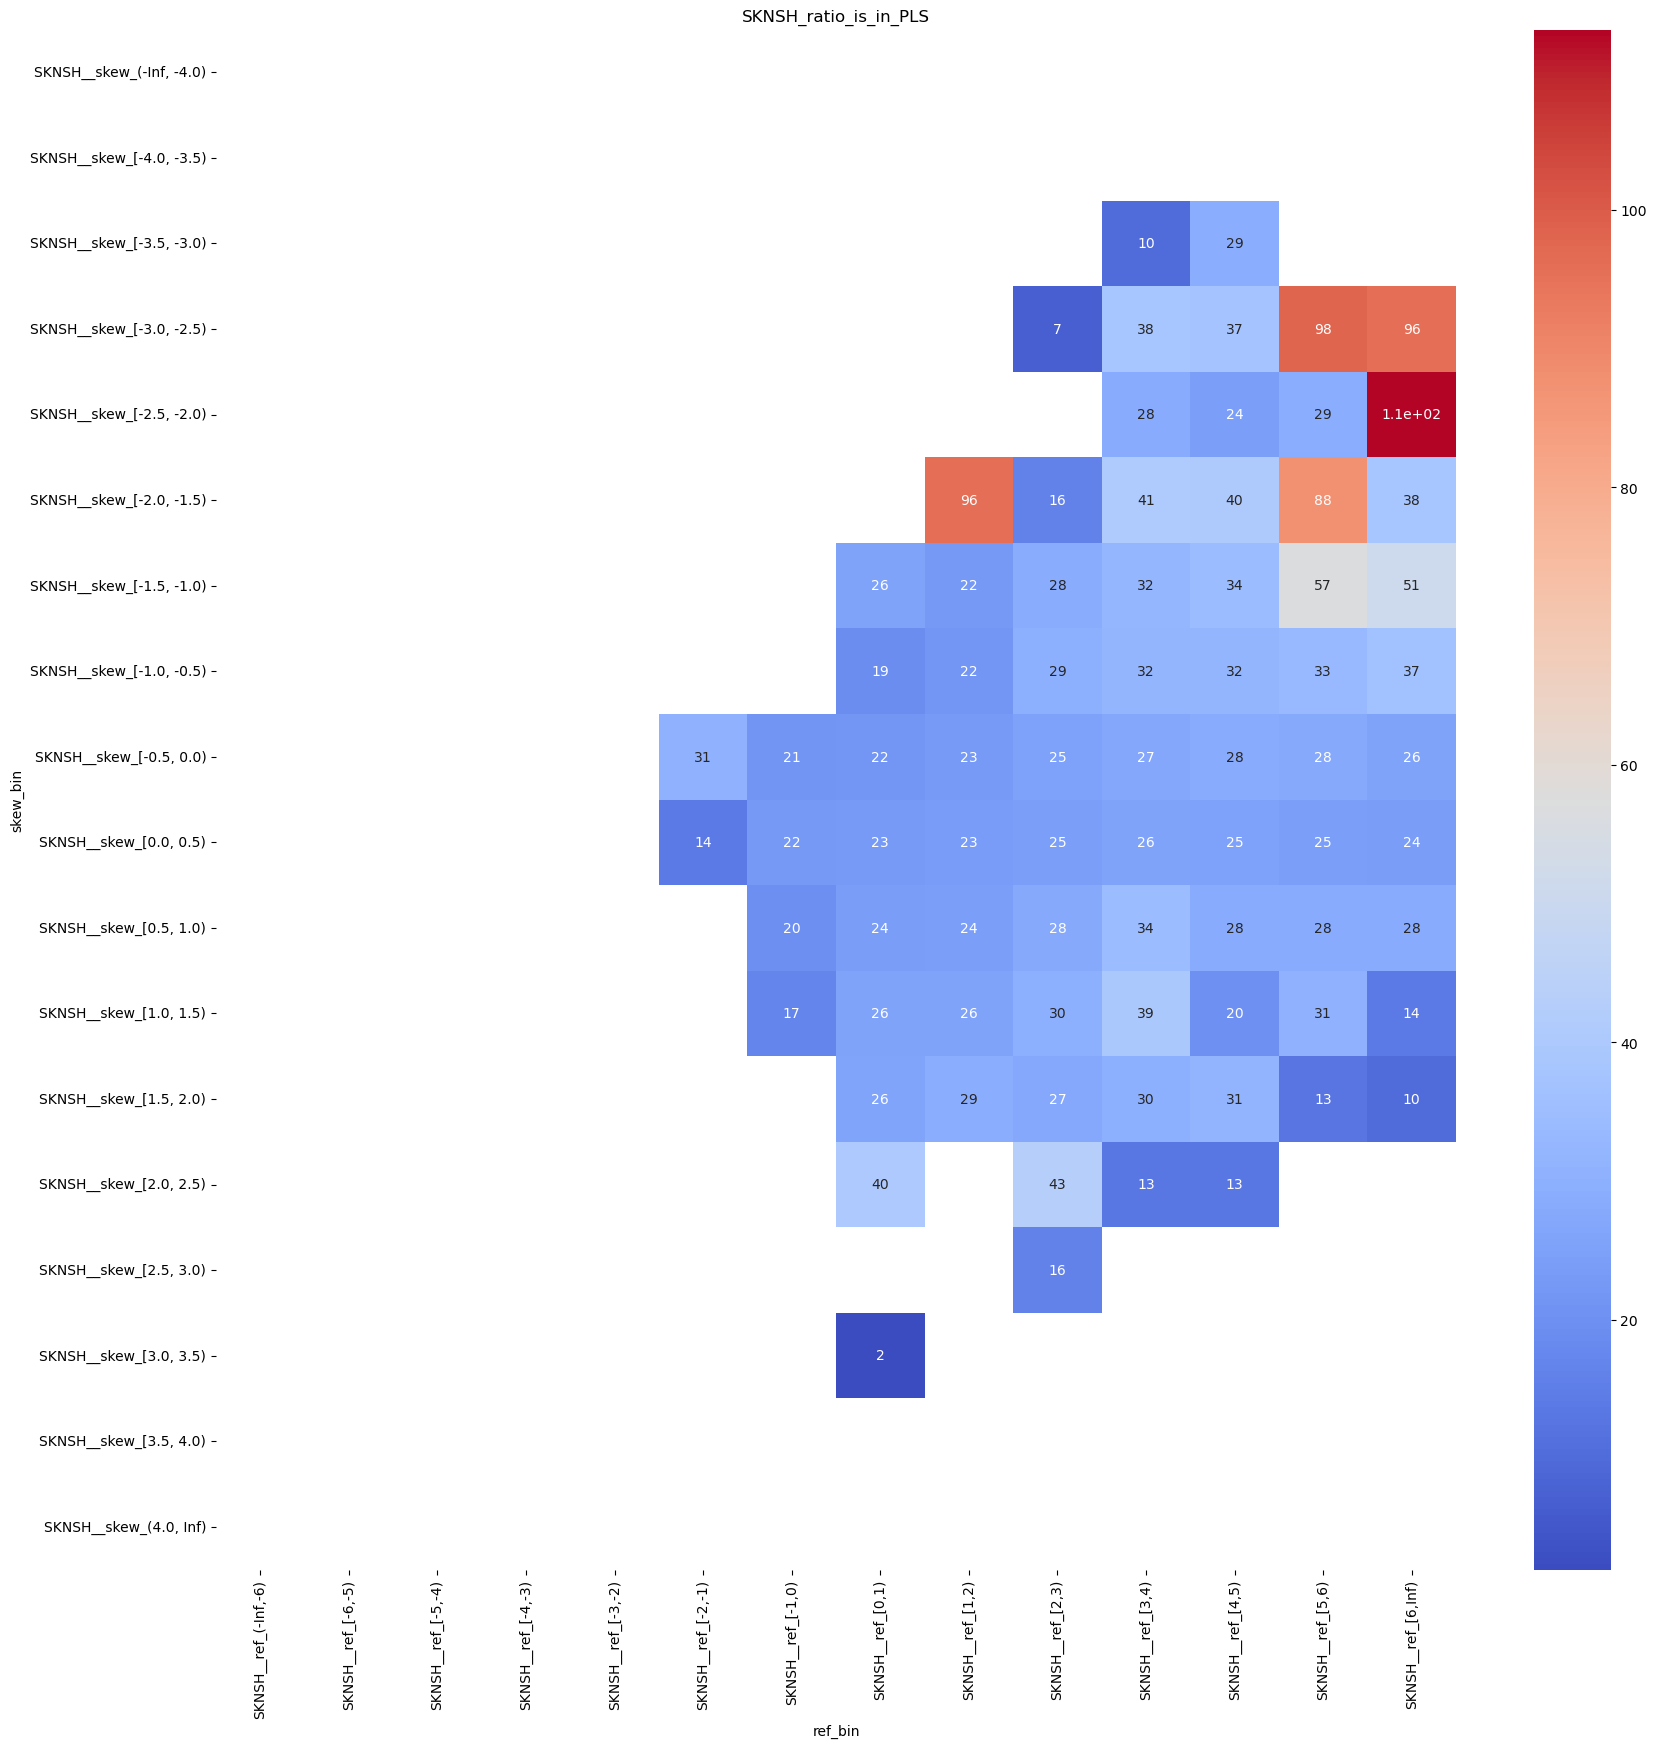

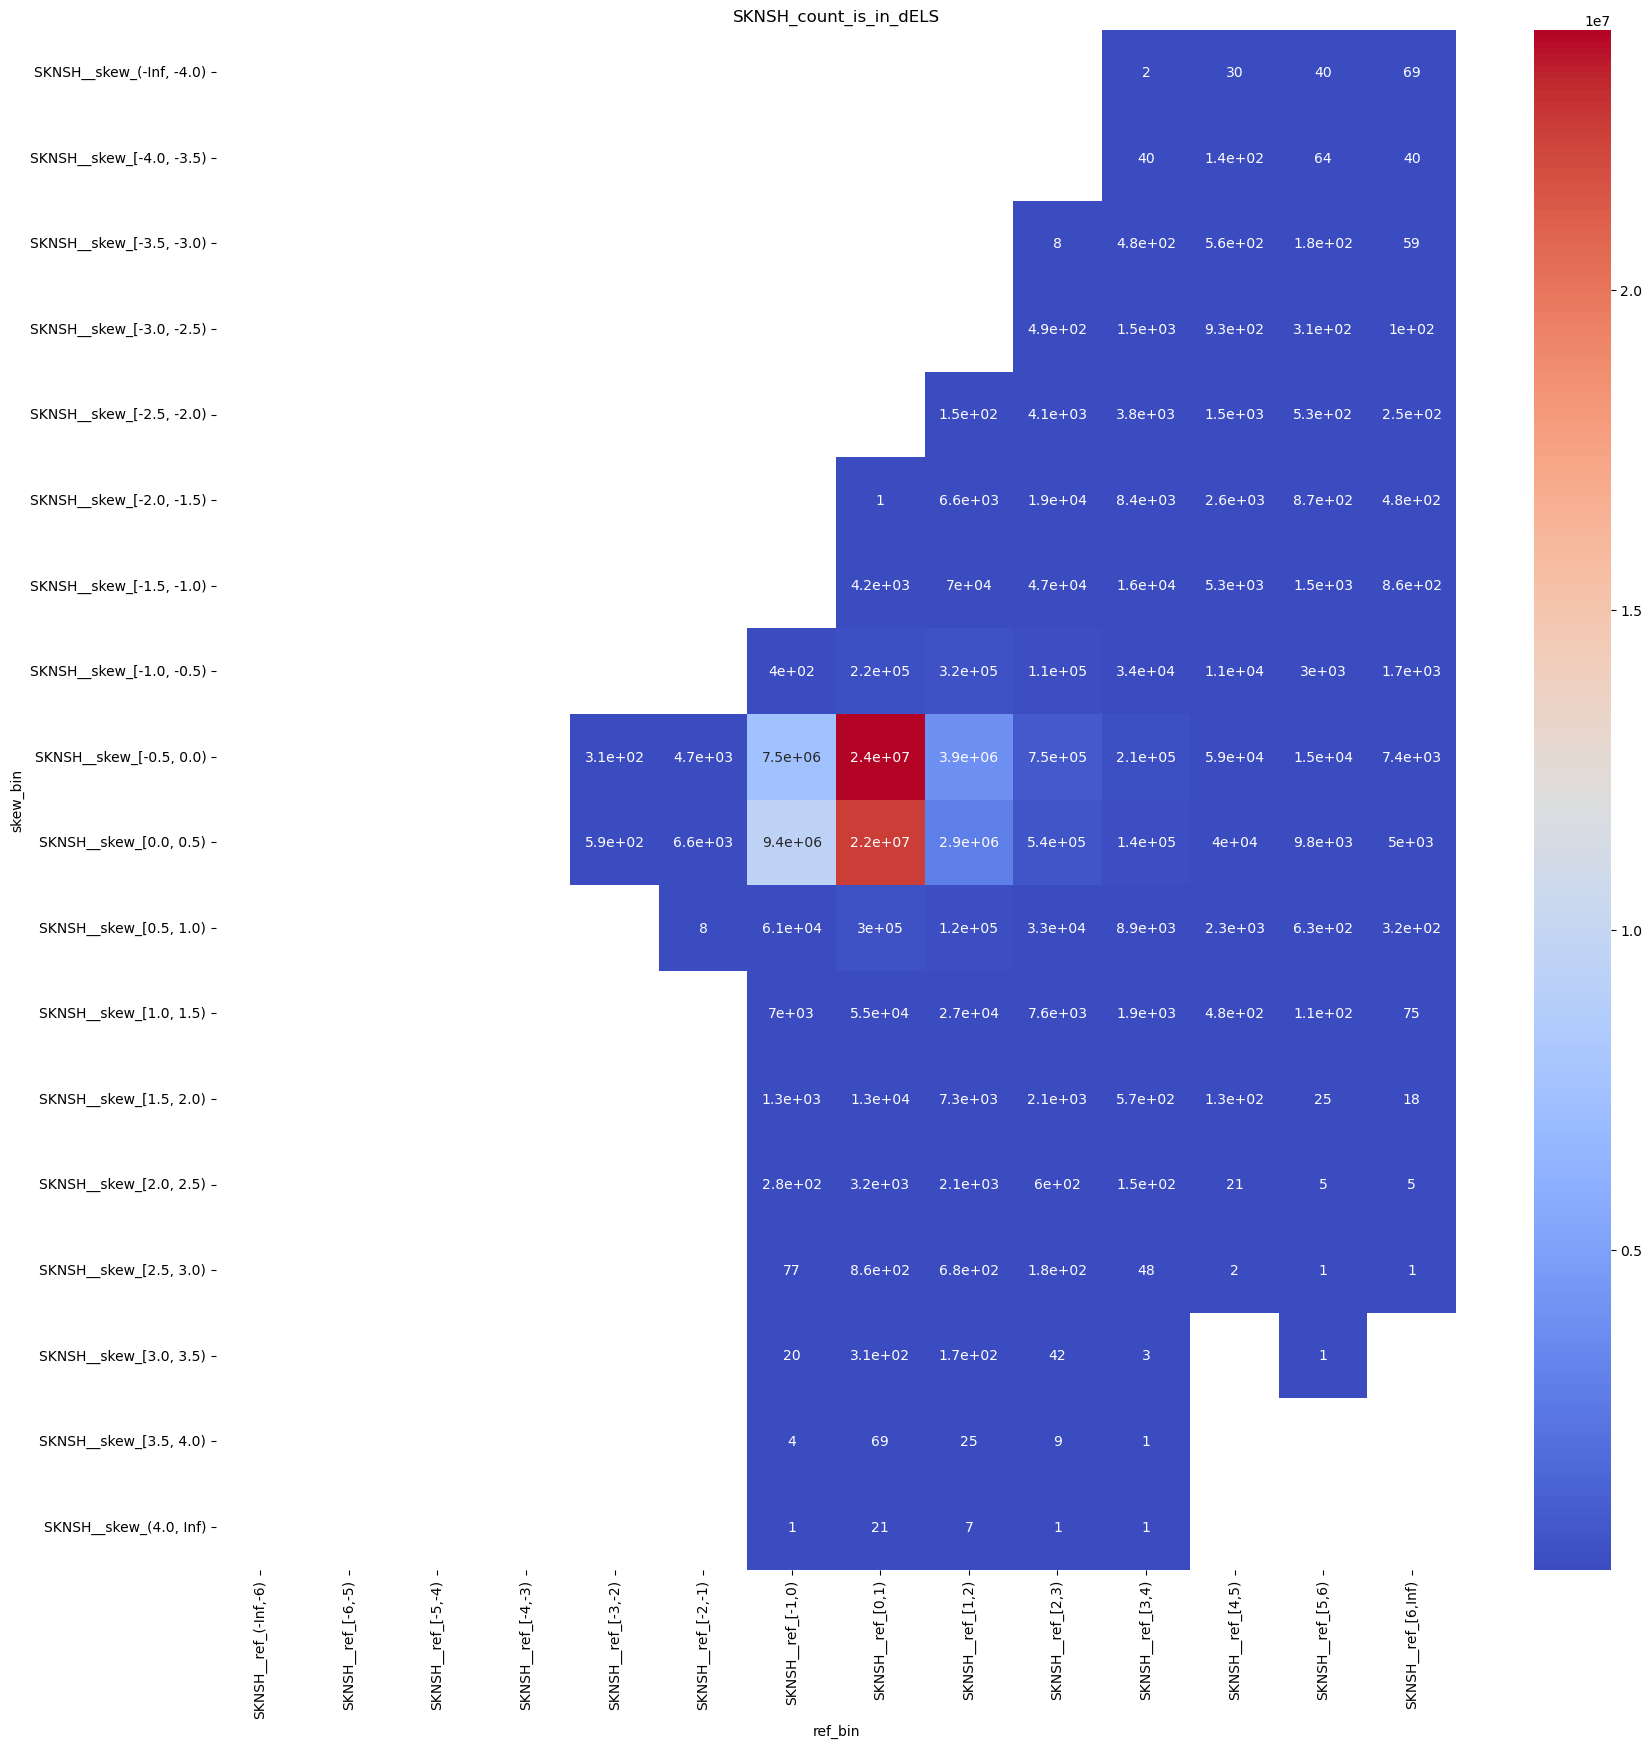

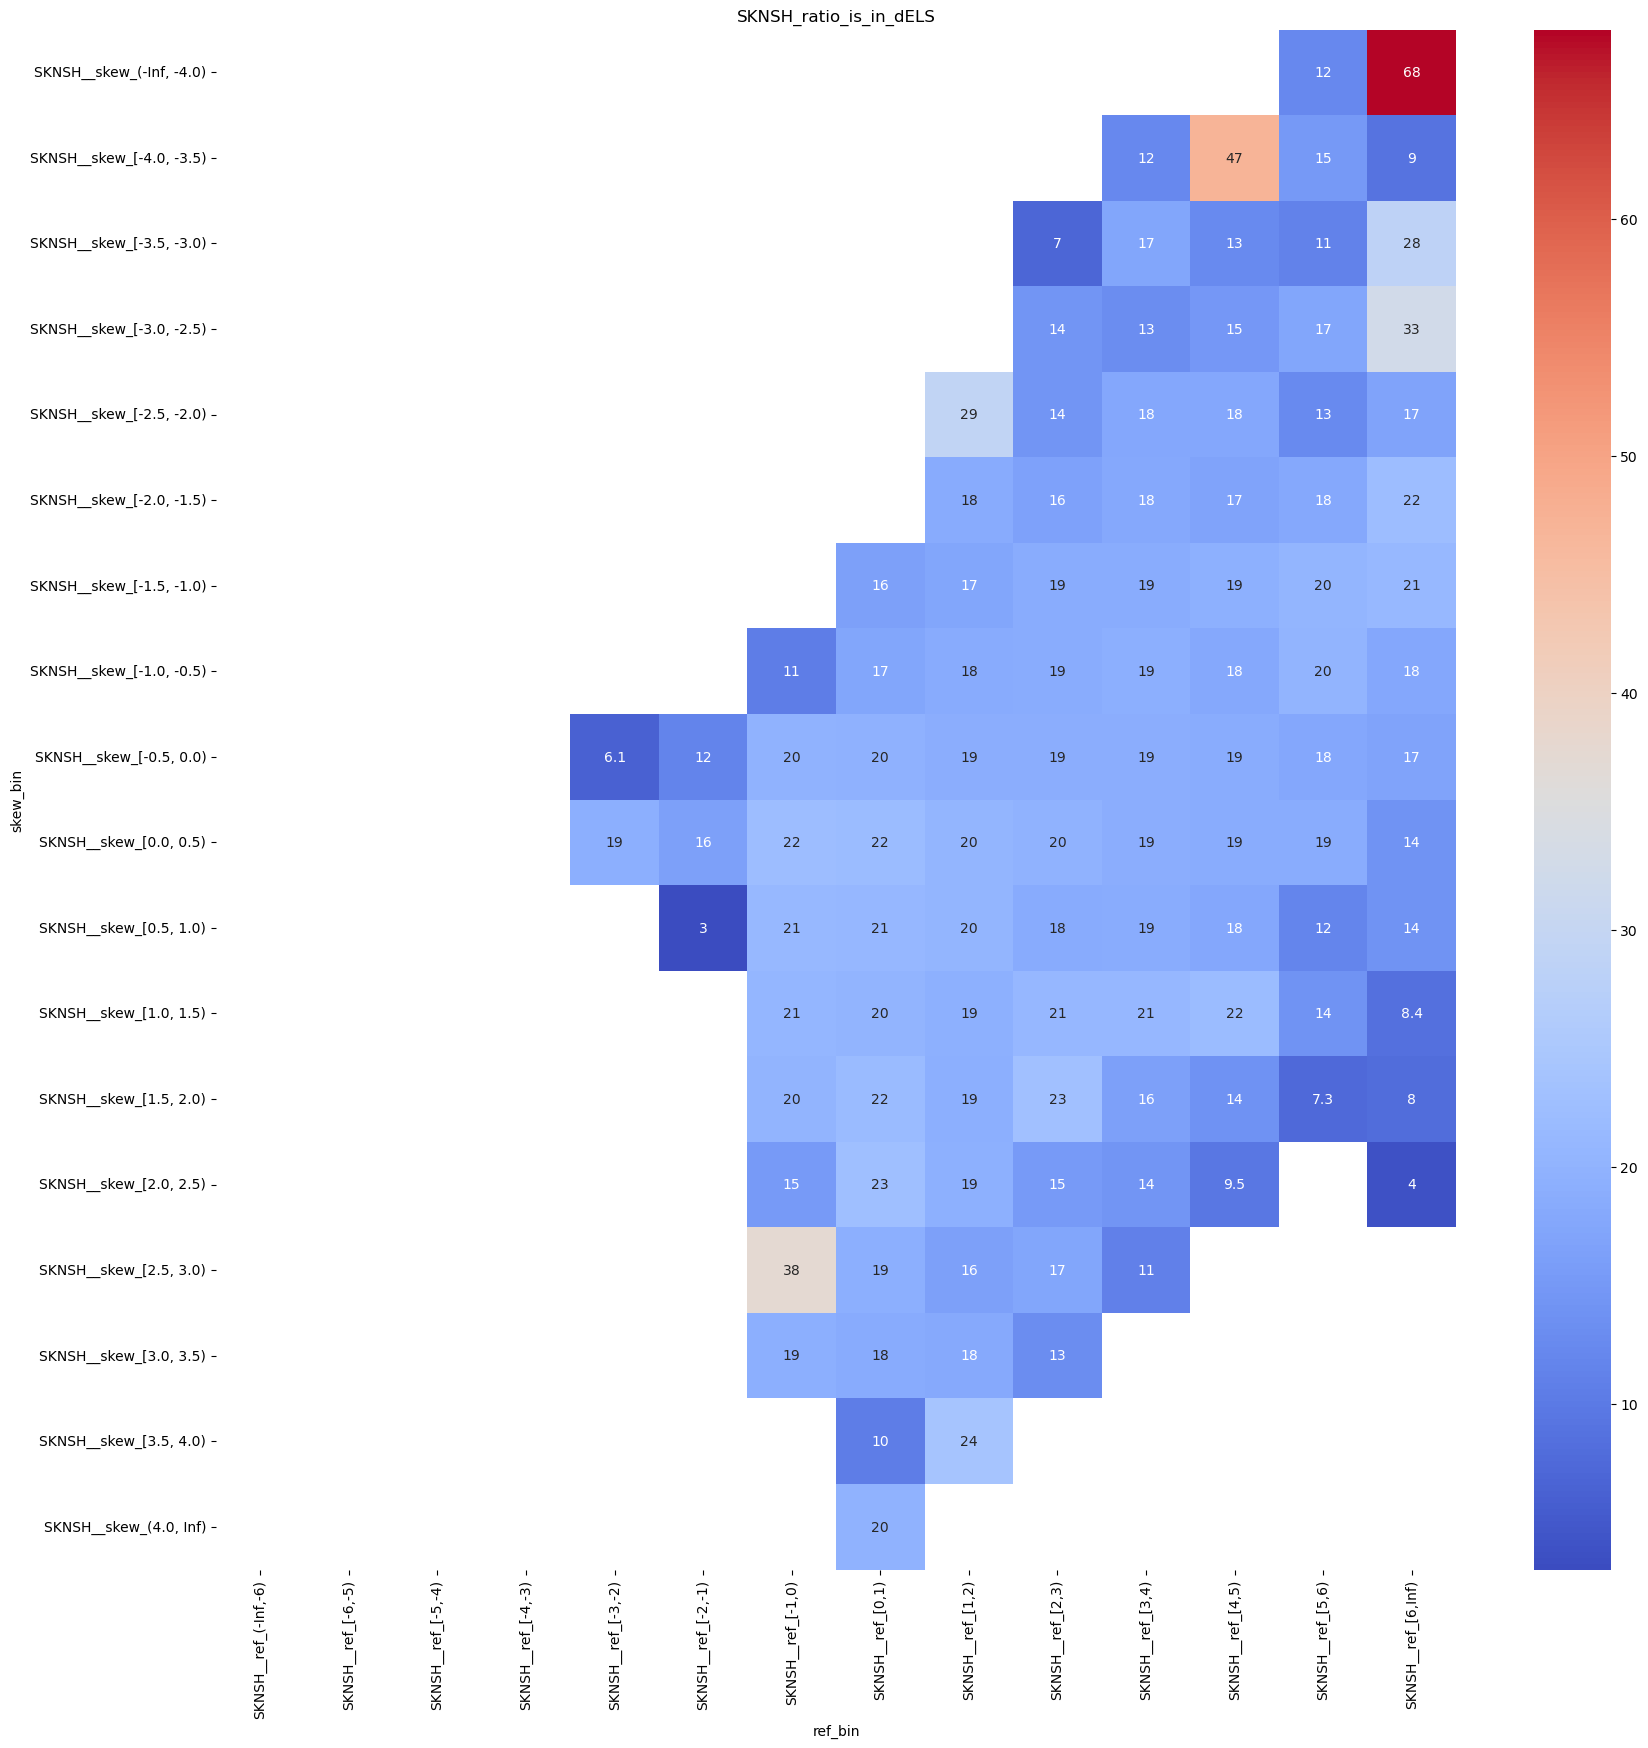

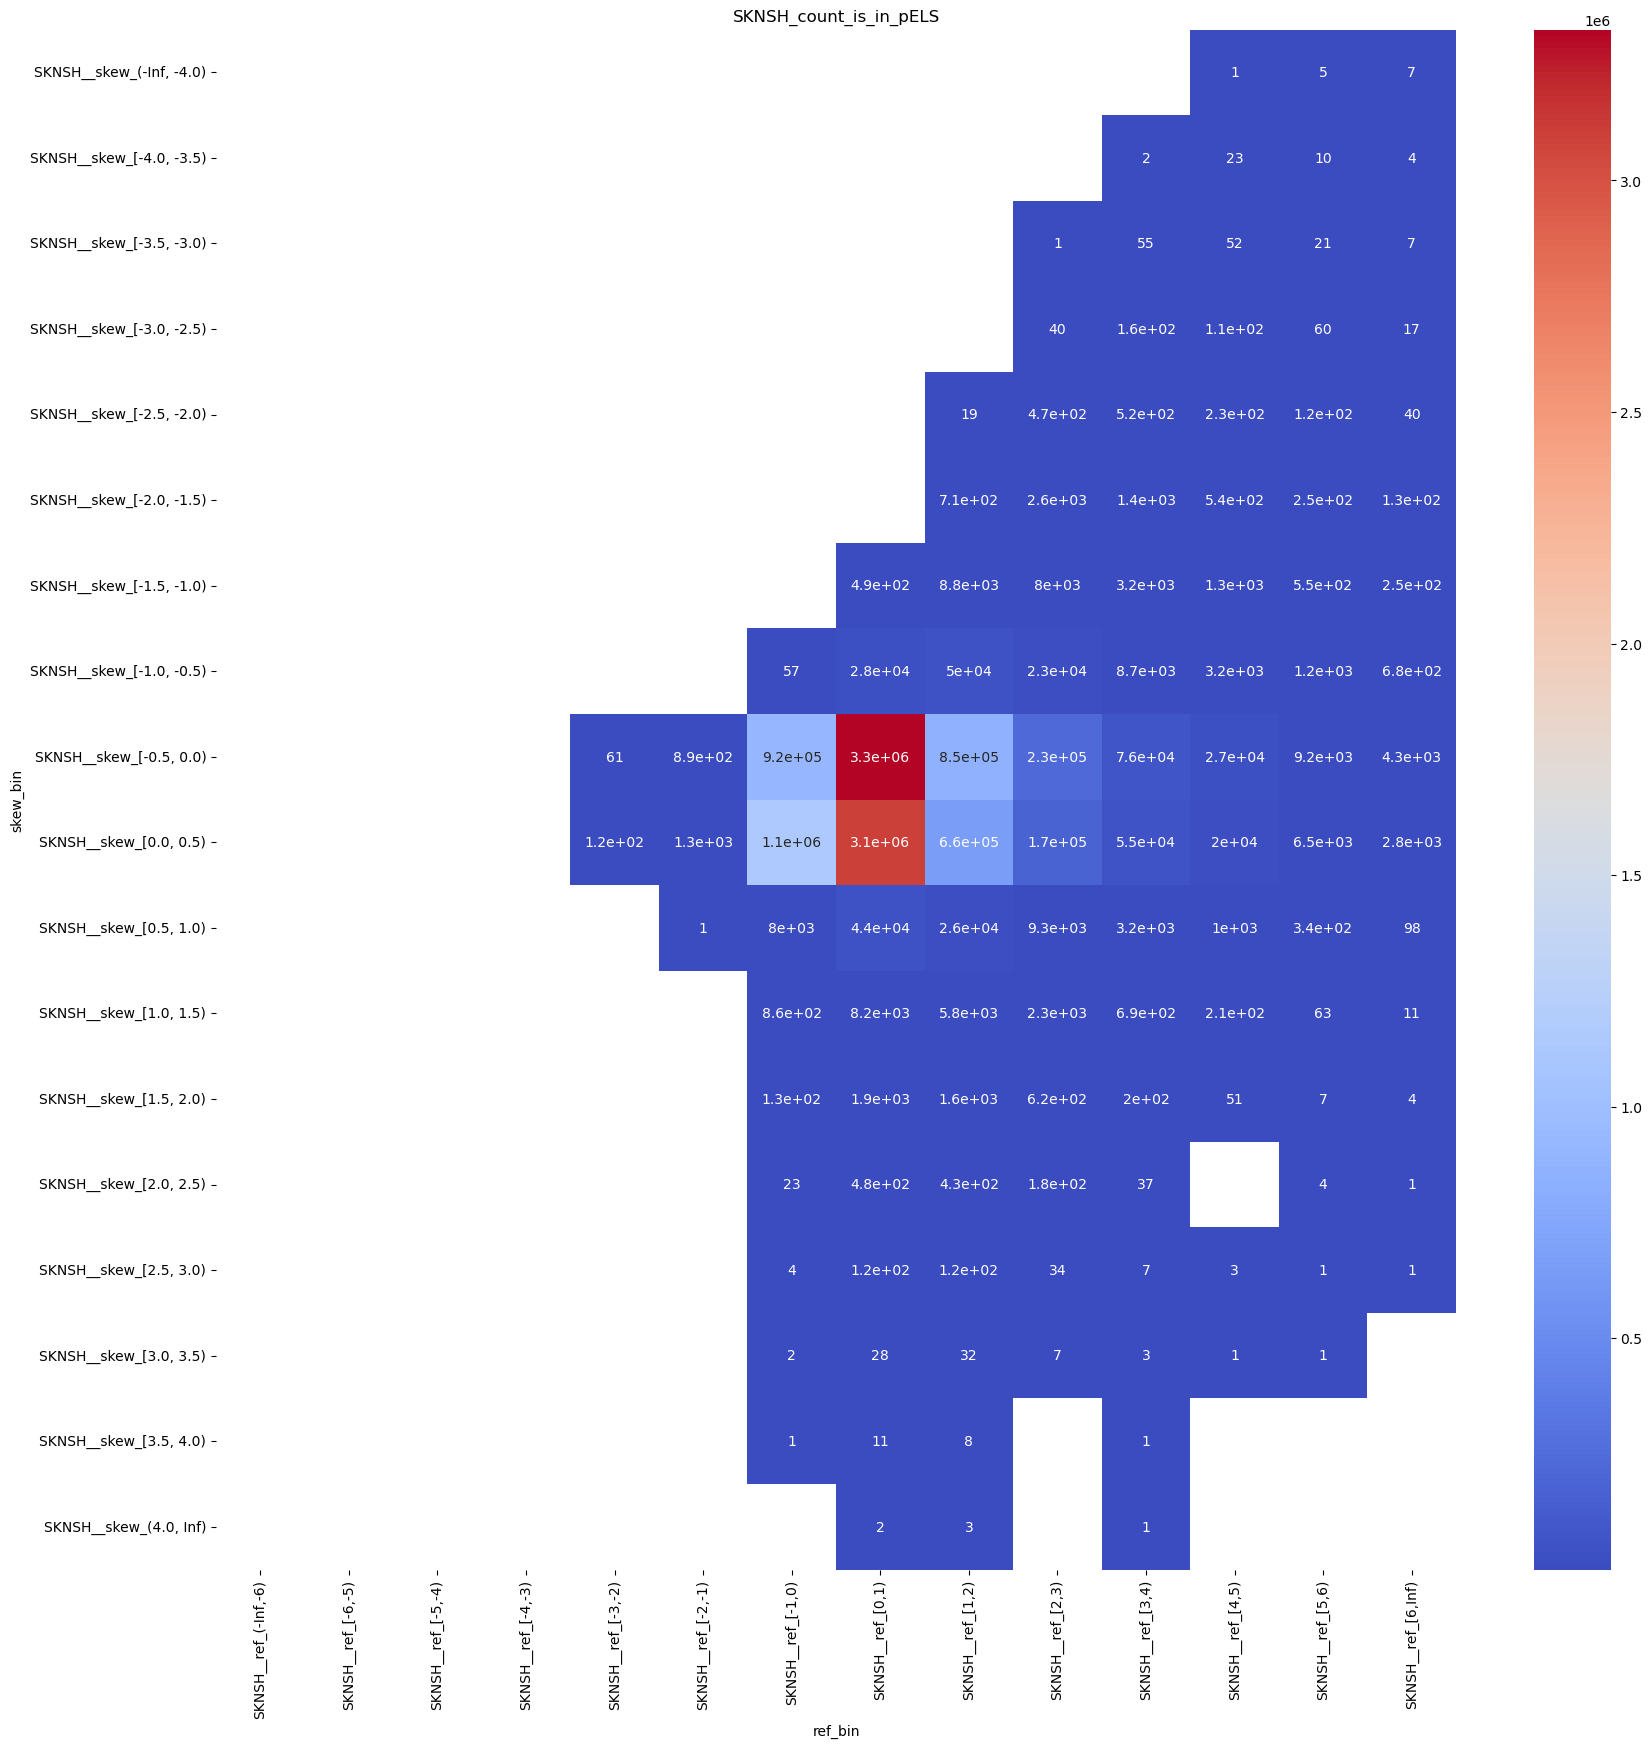

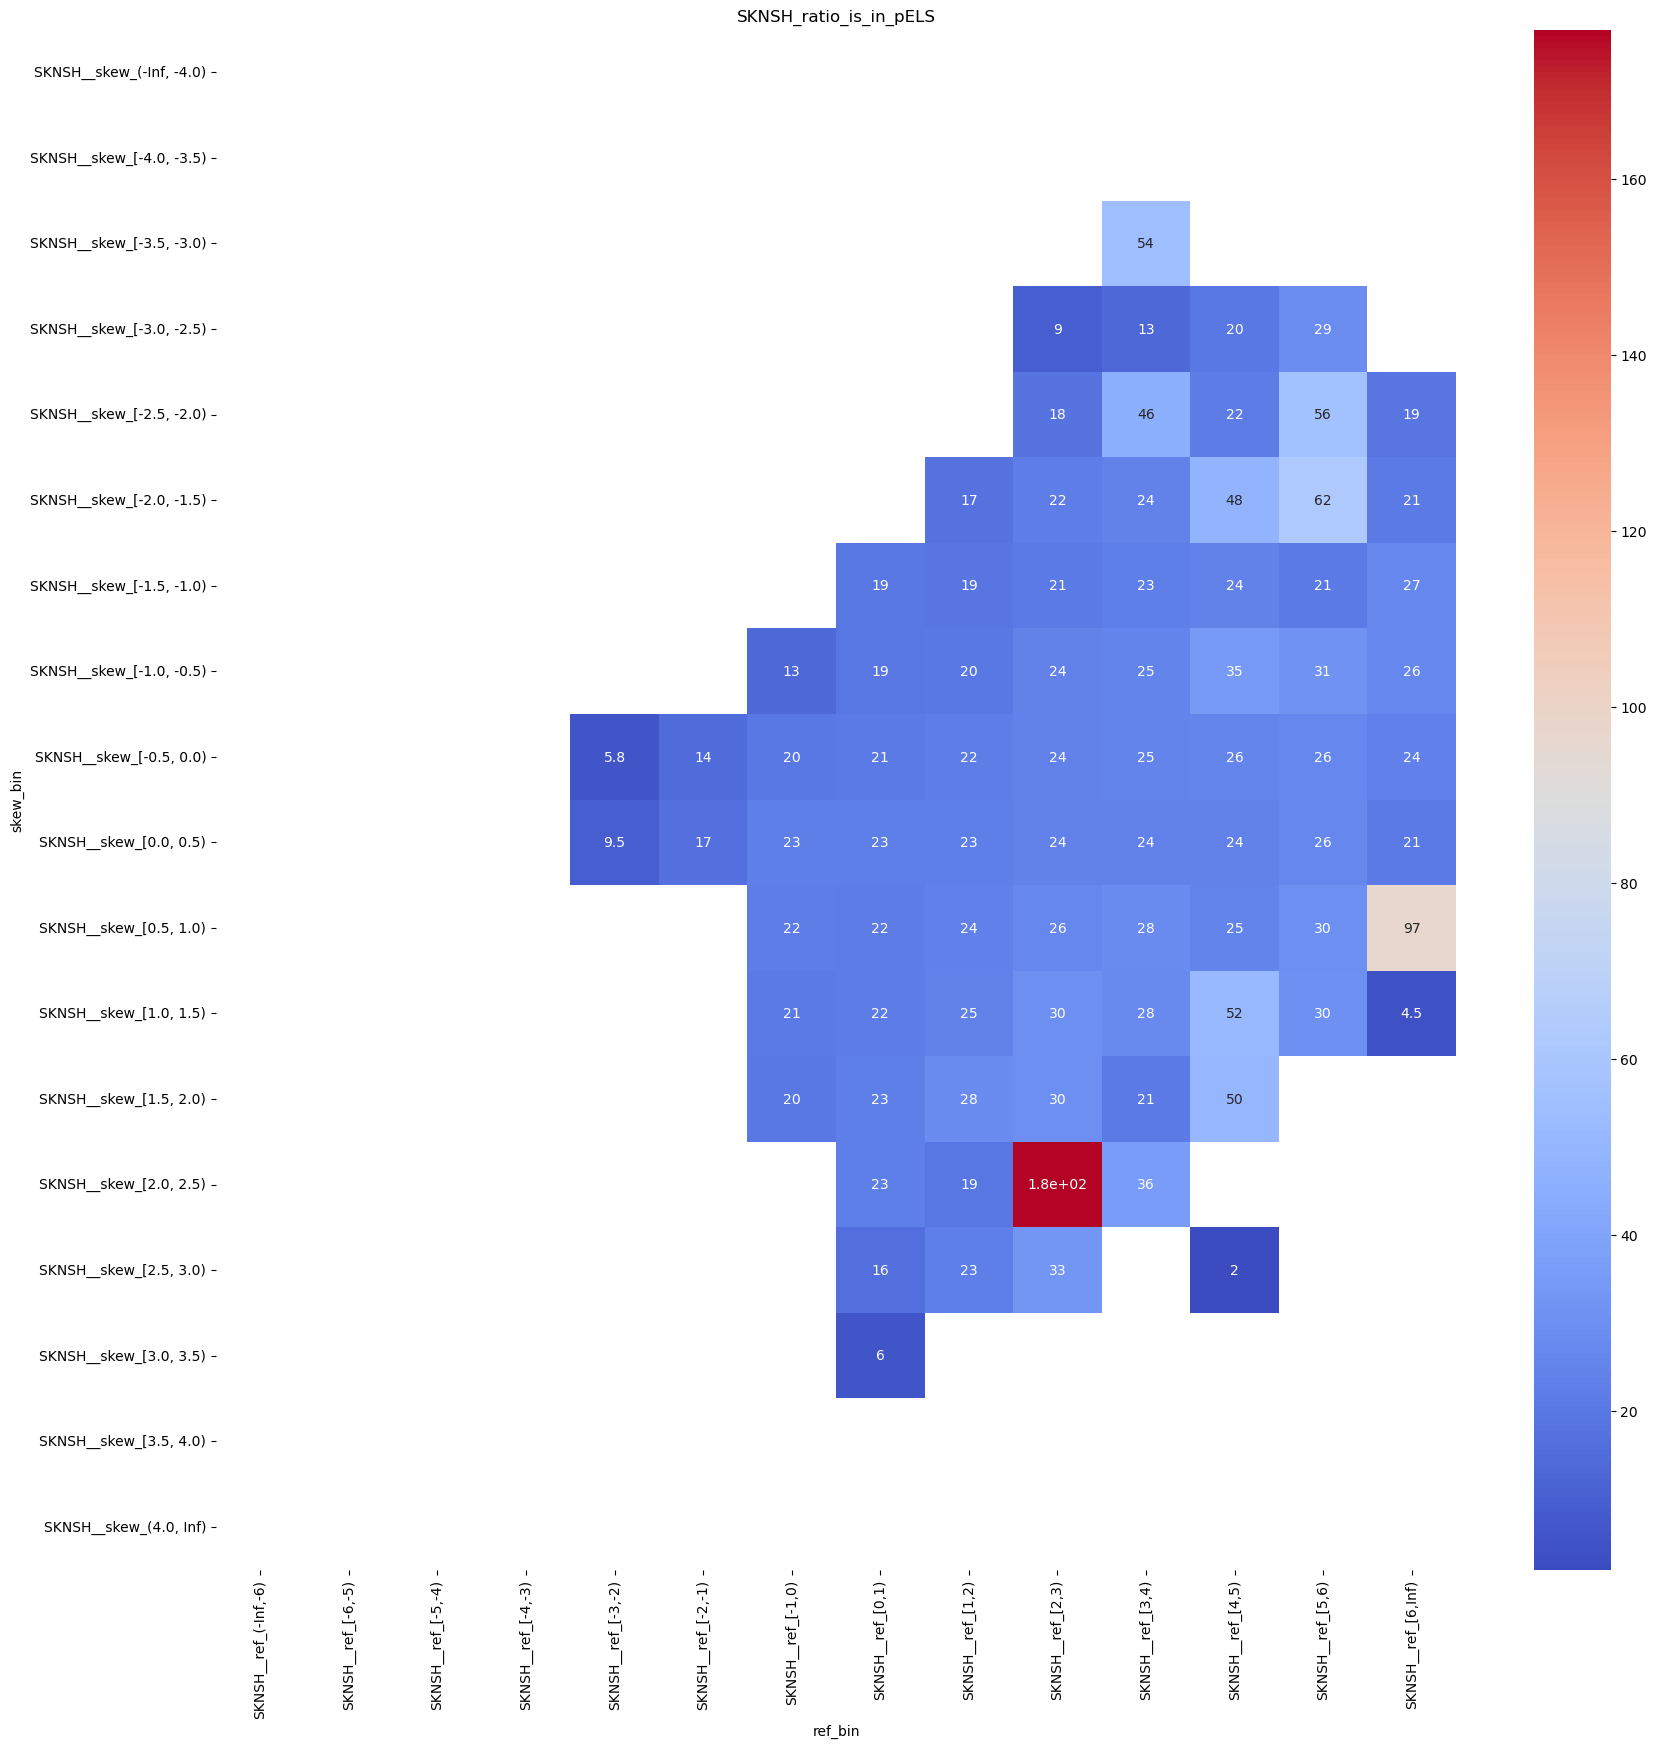

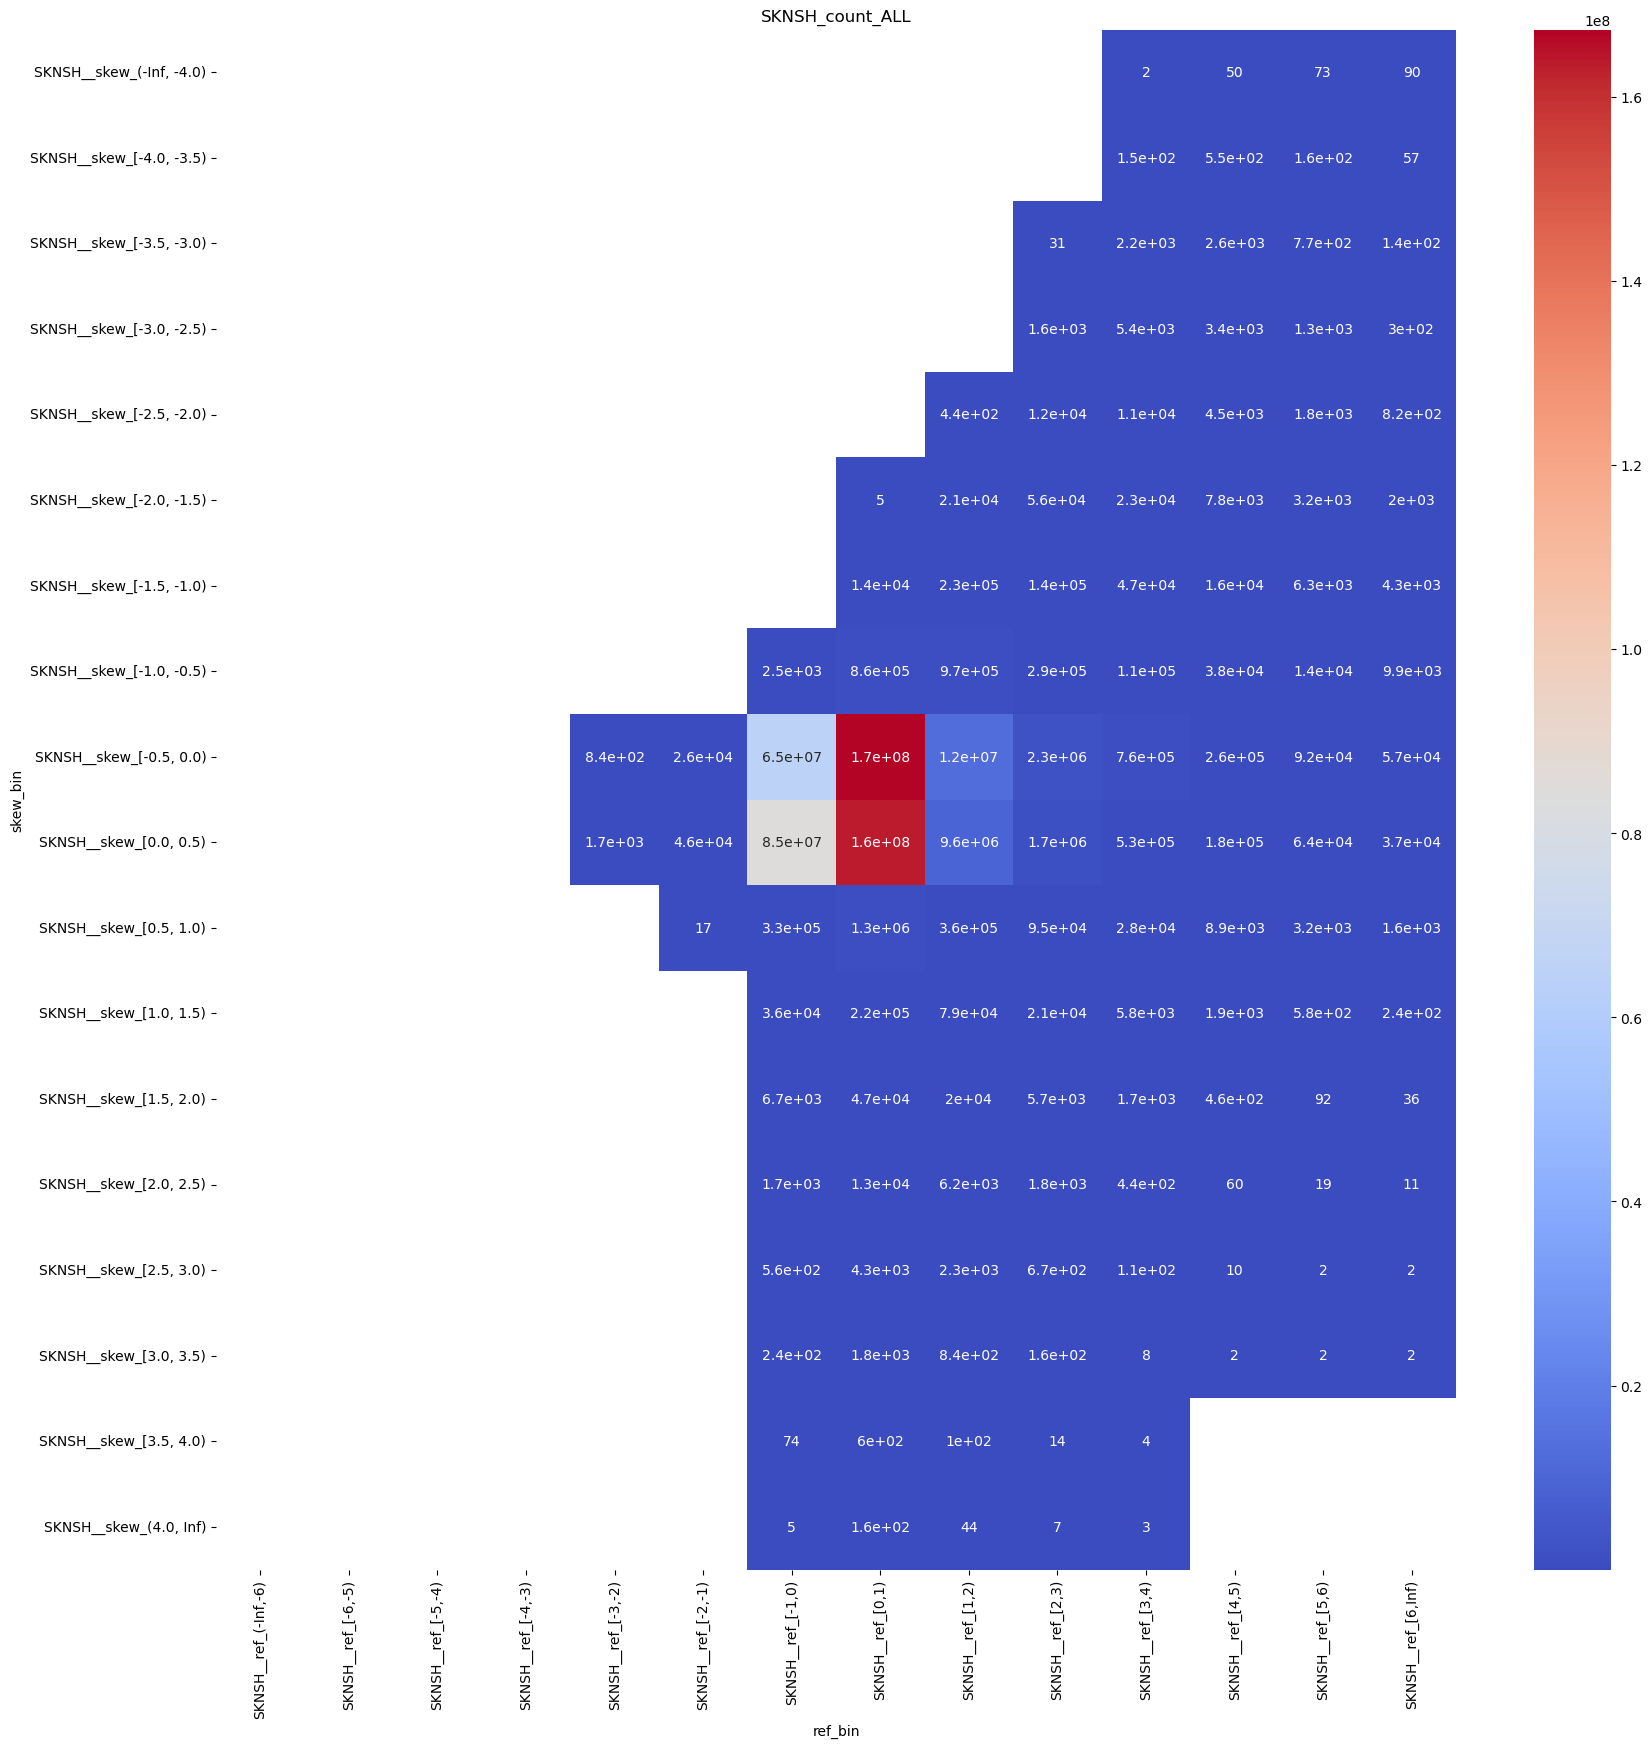

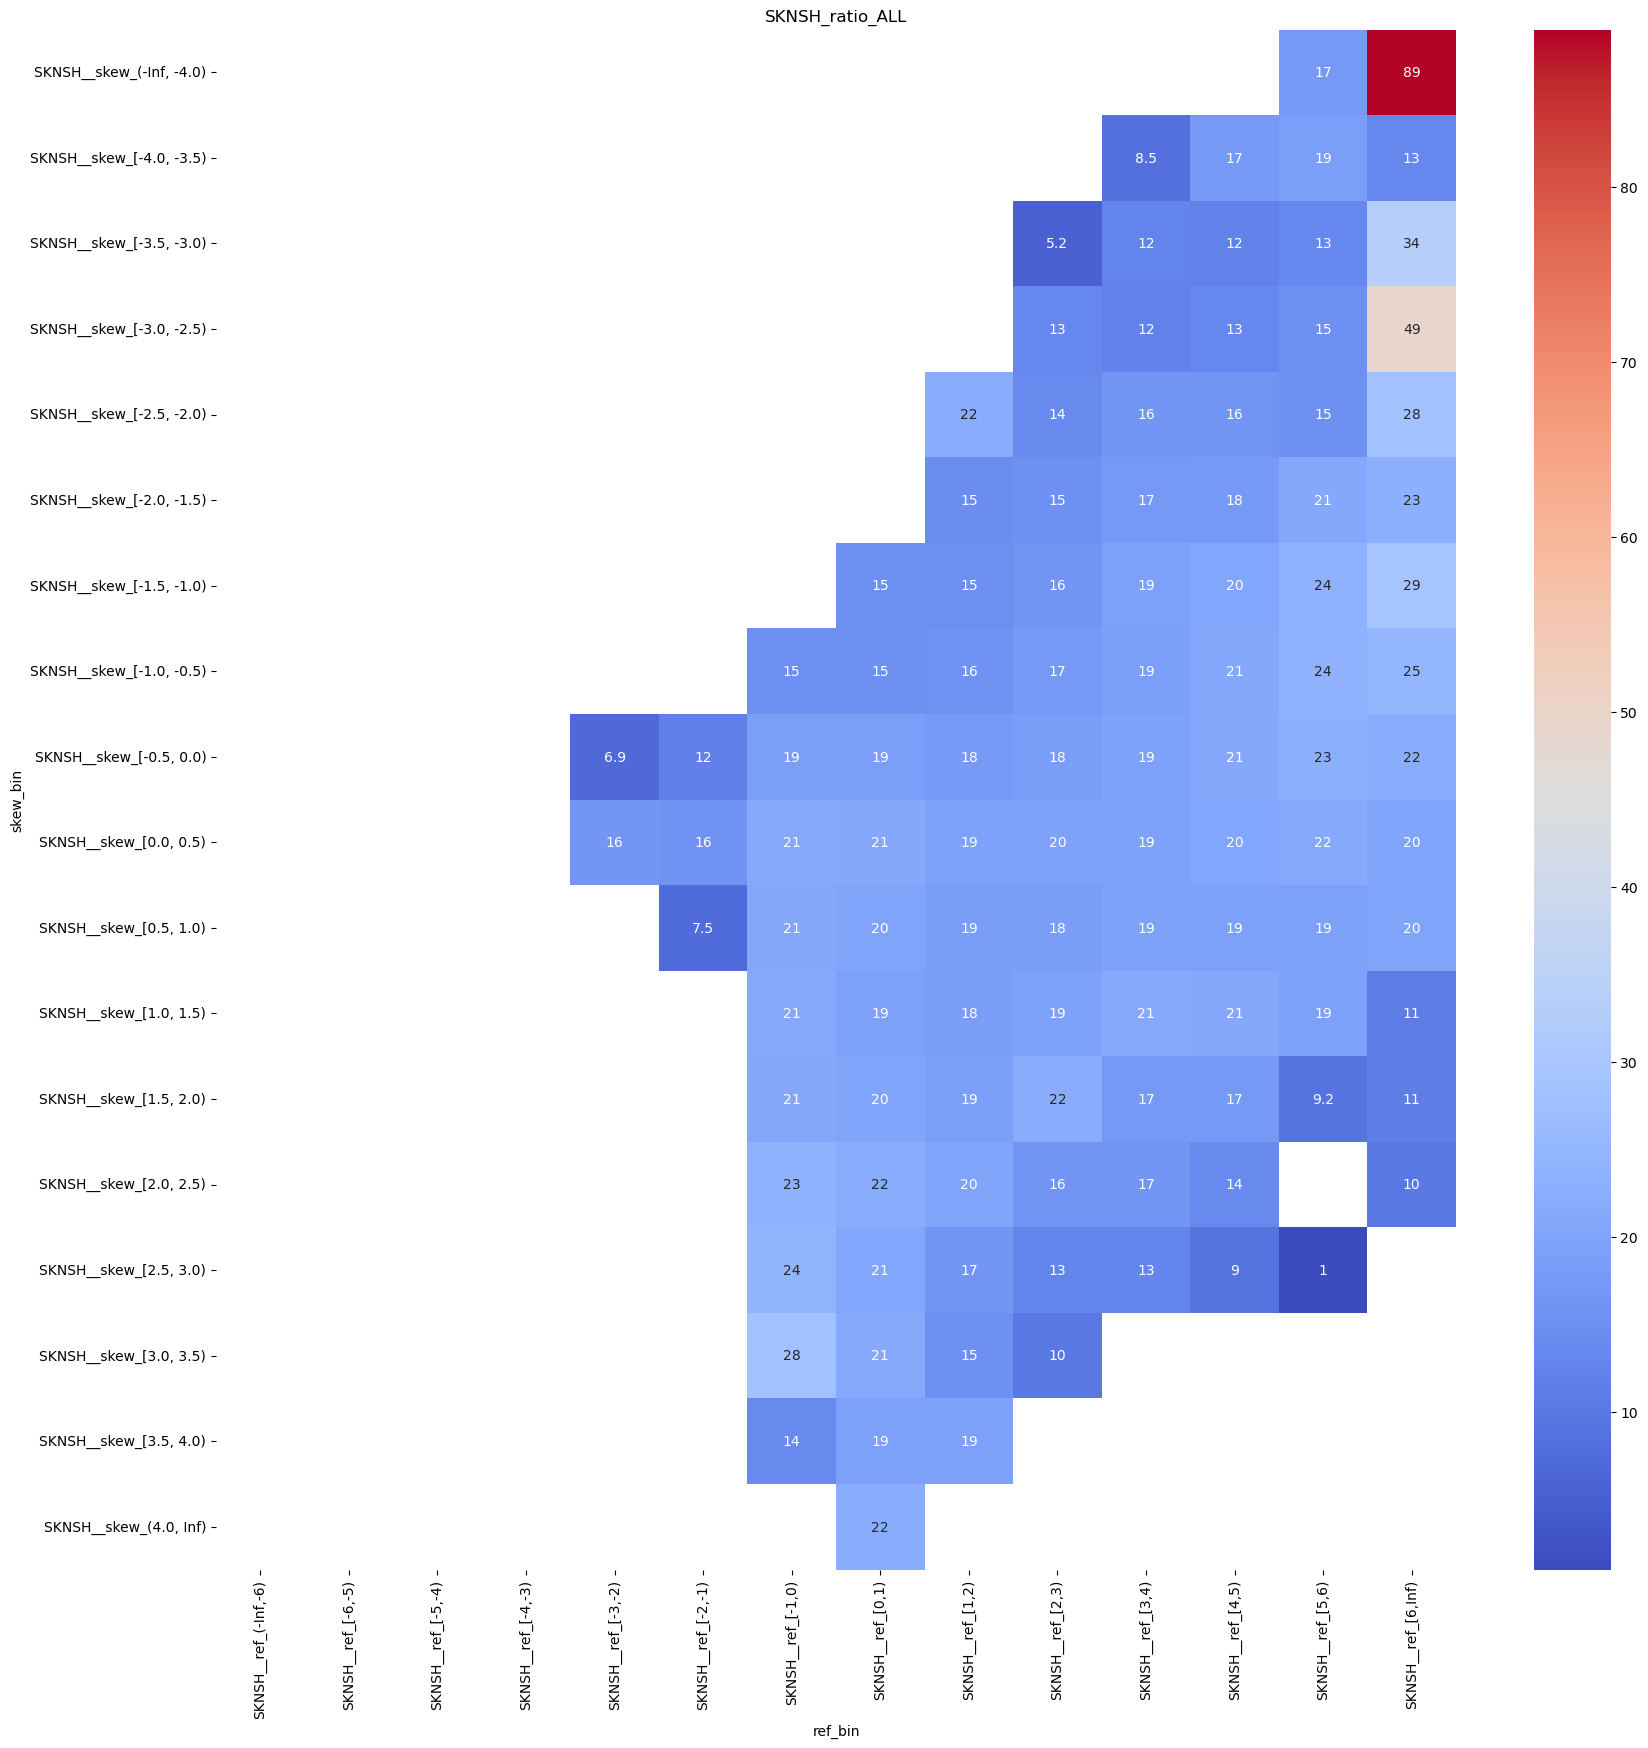

In [8]:
for cell_type in cell_types:
    current=data[cell_type]
    for region in GC.genome_regions:
        for ver in ["count","ratio"]:
            plot_2d(df=current,cell_type=cell_type,genomic_region=region,x="skew_bin",y="ref_bin",count_or_ratio=ver)

### 1d plots

In [49]:
def plot_2d_on_1d(df,cell_type, genomic_region,x,y,scatter=False):
    
    subset_df=None
    if genomic_region=="ALL":
        subset_df=df
    else:
        subset_df = df[df[genomic_region]]
    
    subset_df=subset_df[subset_df["rarity_bin"]!="not_interesting"].copy()
    
    
    total_counts = subset_df.groupby([x,y,'rarity_bin'])['count'].sum().unstack()
    
    total_counts["ratio"]=total_counts["RARE"]/total_counts["COMMON"]
    
    ### Pull the thresholds & their order from disc
    ref_thresh=None
    skew_thresh=None

    with open(glob.glob(GC.pickle_root+cell_type+"*"+"ref.pkl")[0],"rb") as f:
        ref_thresh=pickle.load(f)

    with open(glob.glob(GC.pickle_root+cell_type+"*"+"skew.pkl")[0],"rb") as f:
        skew_thresh=pickle.load(f)
    ###
    
    plt.figure(figsize=(15, 8))
    
    plt.xticks(rotation=45, ha='right')
    if scatter:
        #we must sort the x-axis 
        total_counts.reset_index(inplace=True)
        
        total_counts["skew_bin"]= pd.Categorical(total_counts['skew_bin'], categories=skew_thresh, ordered=True)
        
        sns.scatterplot(data=total_counts, x='skew_bin', y='ratio', hue='ref_bin',hue_order=ref_thresh, palette='viridis', sizes=(20, 200))#, size='ref_bin' #order=skew_thresh
    else:
        sns.barplot(total_counts, x="ref_bin",hue="skew_bin",y="ratio",order=ref_thresh,hue_order=skew_thresh)
    plt.title(f"{cell_type} {genomic_region}")
    plt.show()

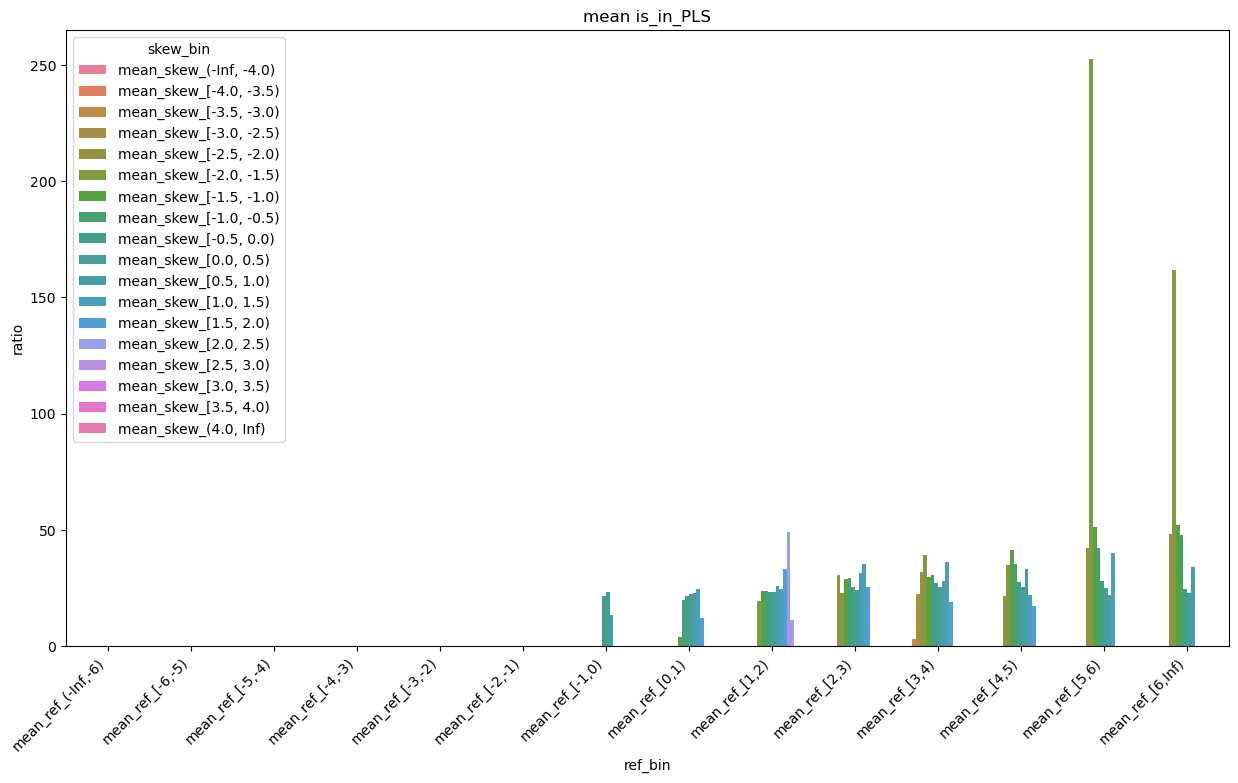

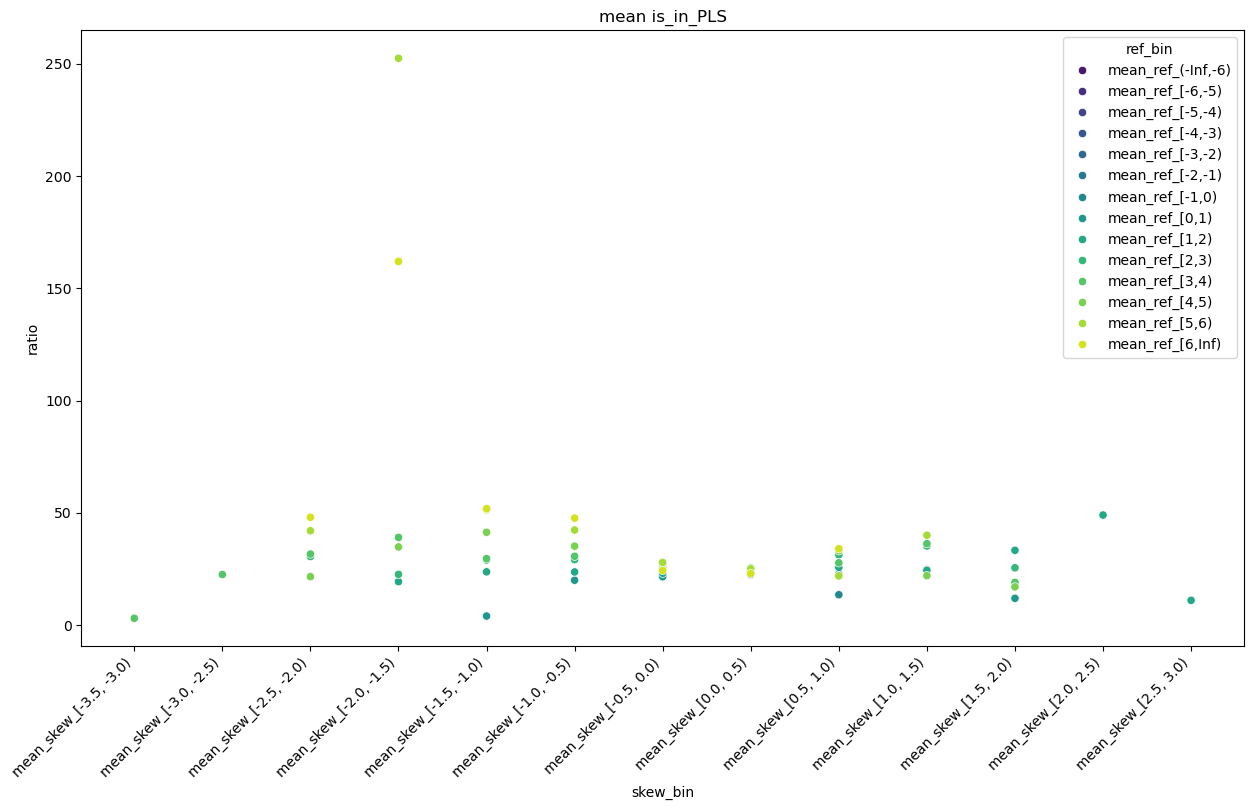

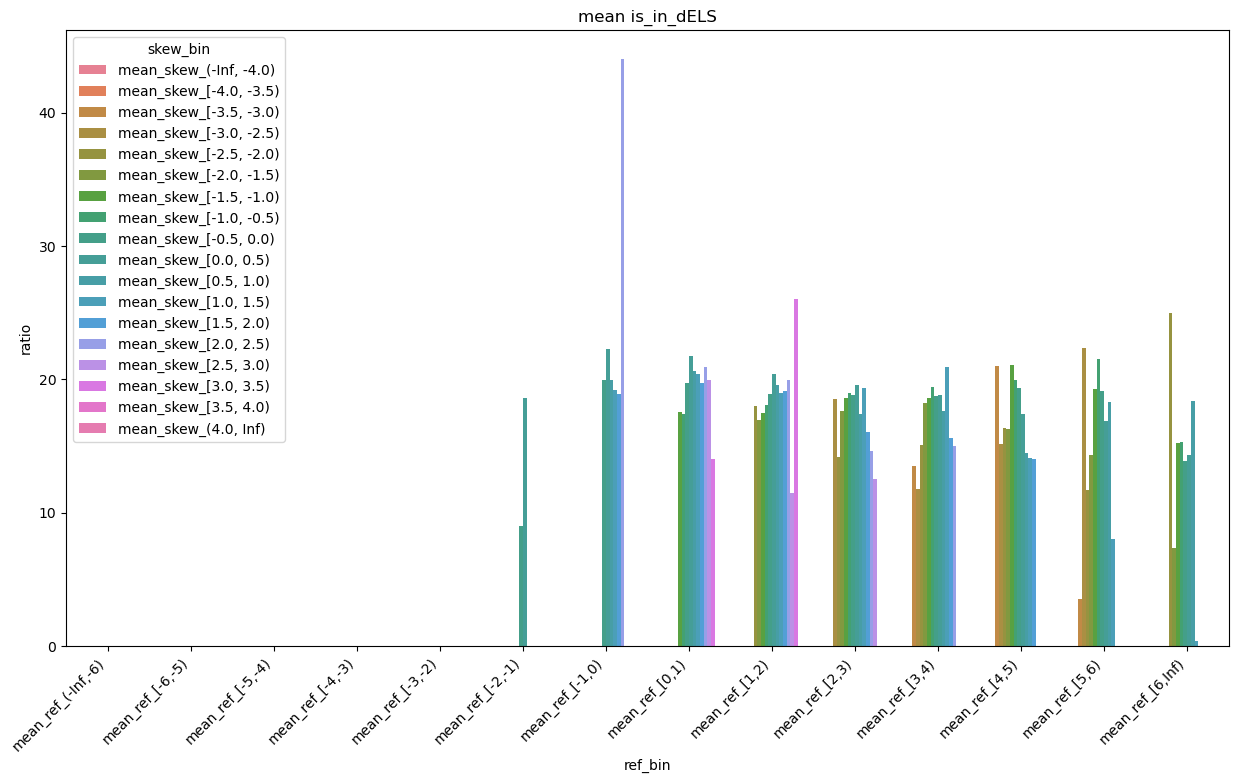

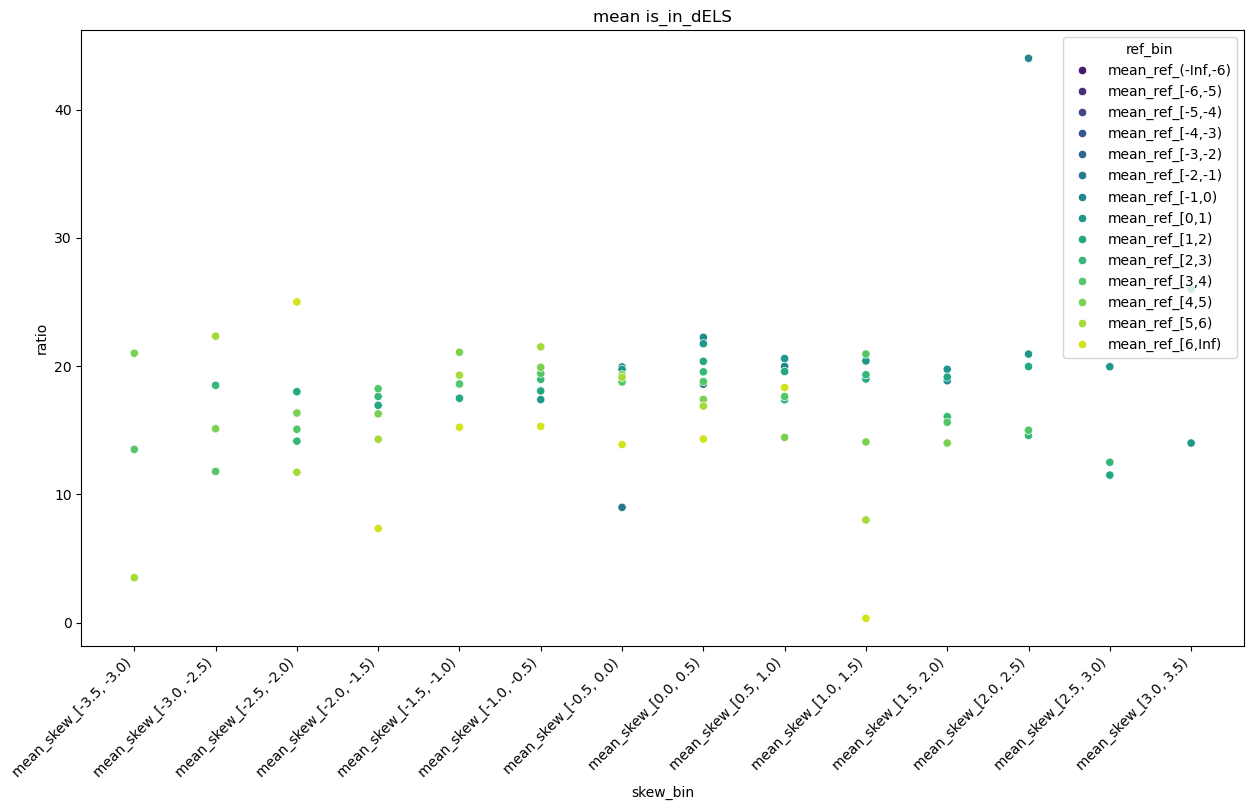

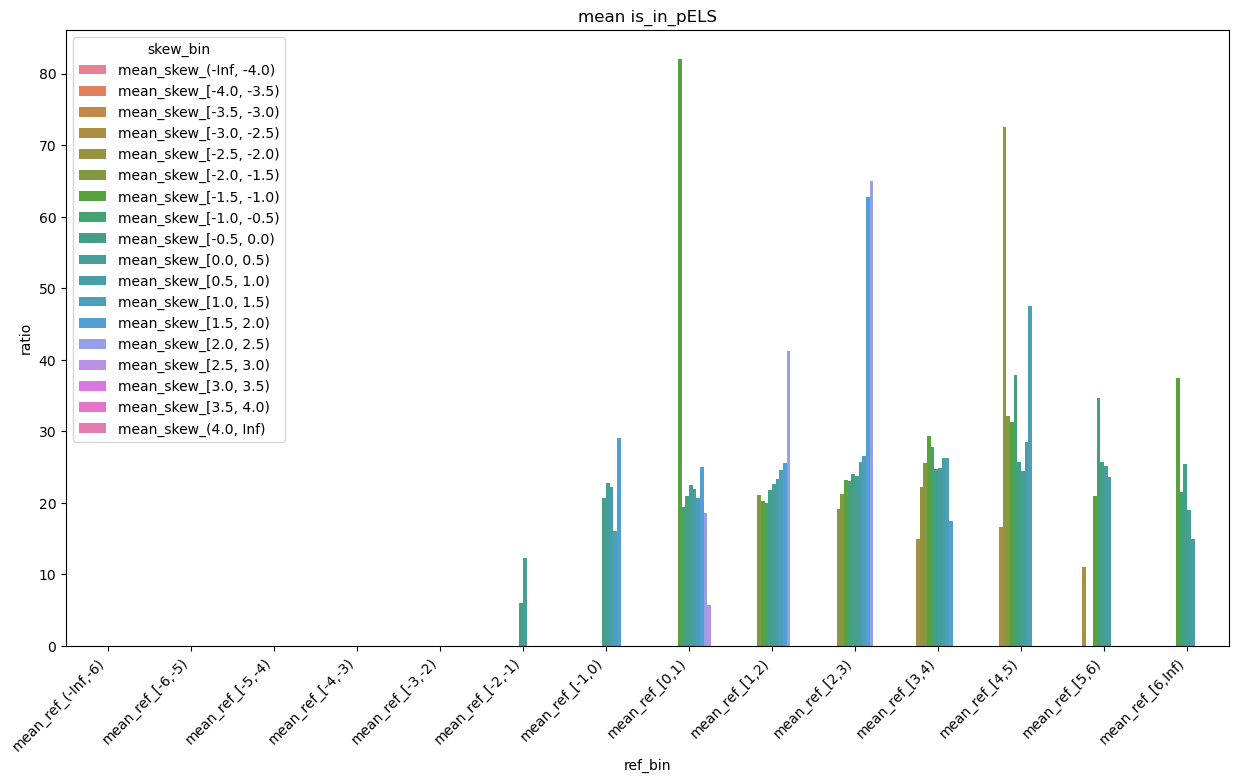

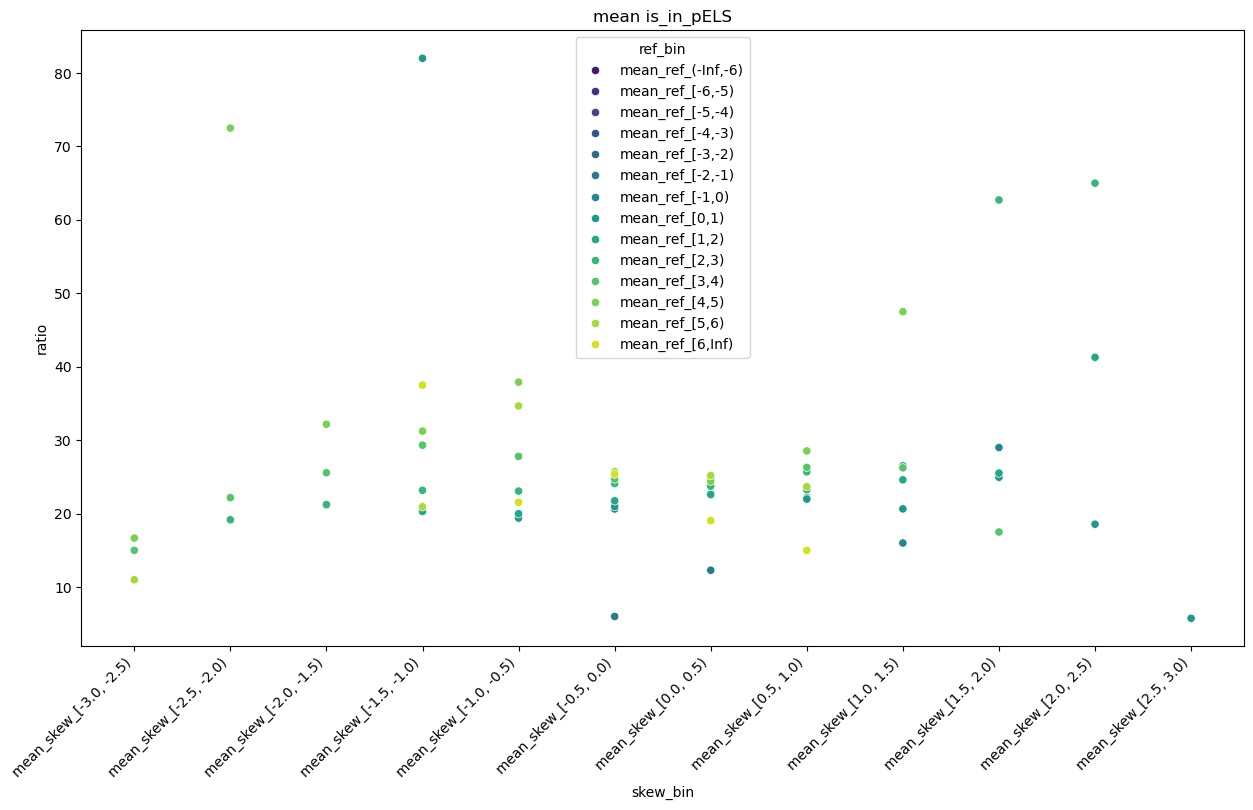

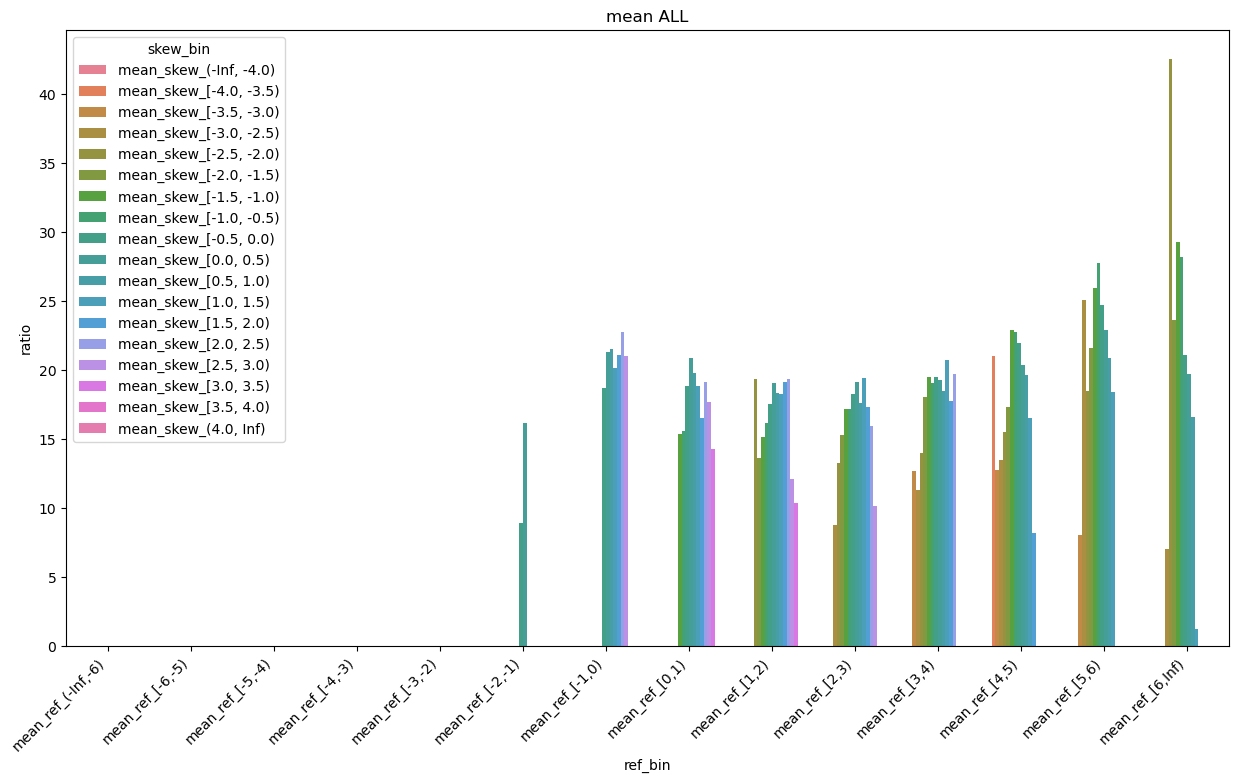

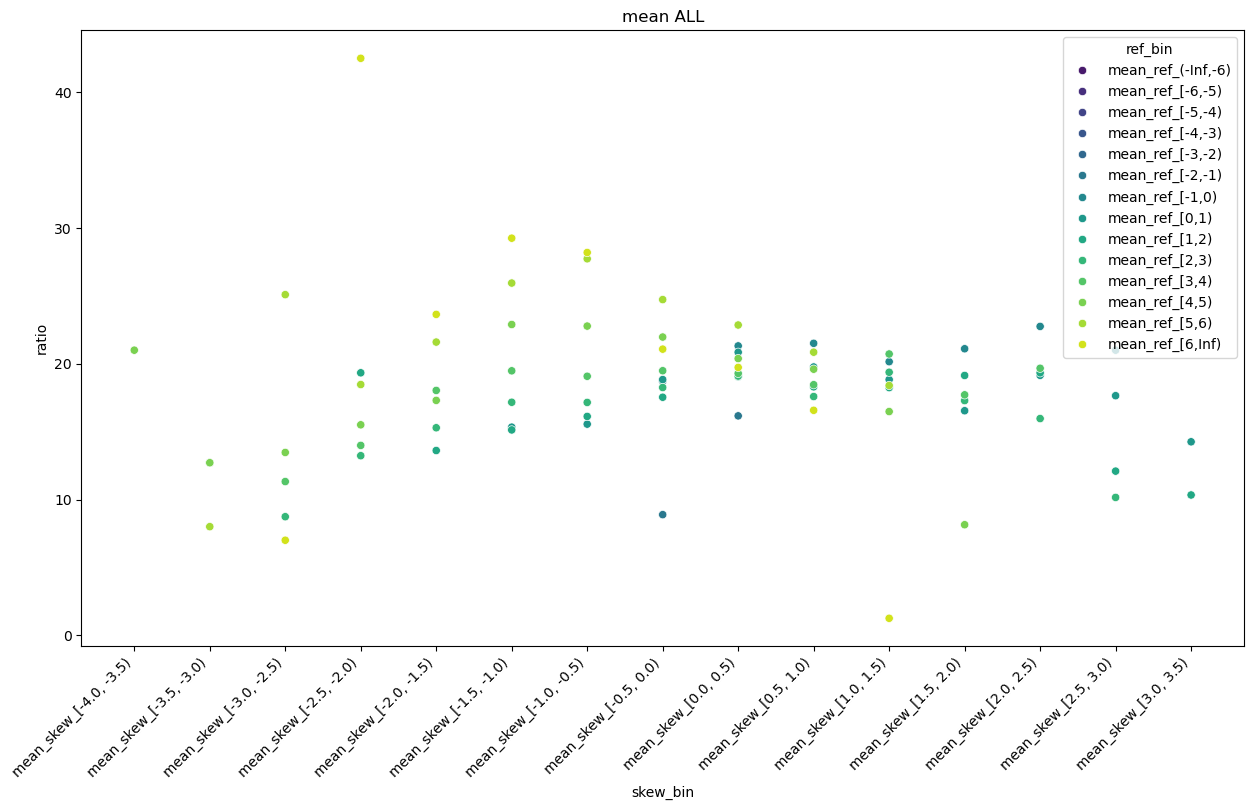

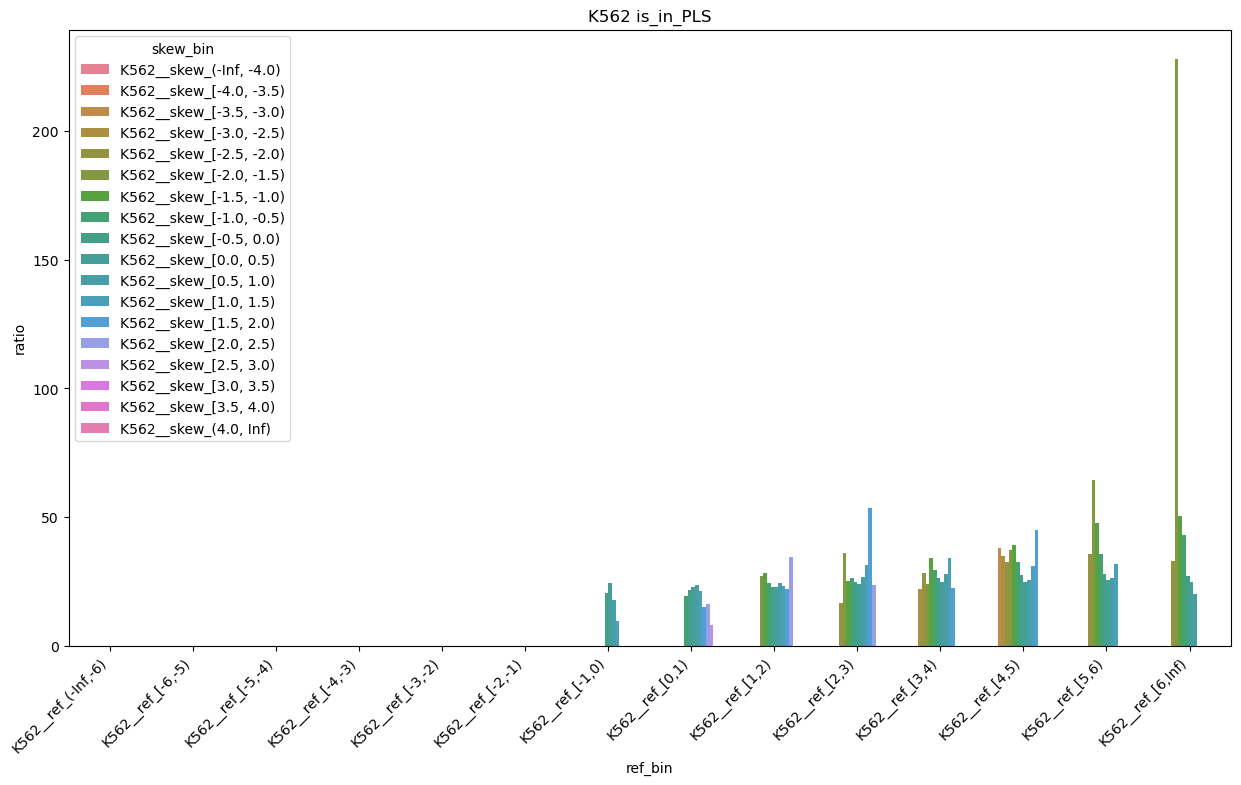

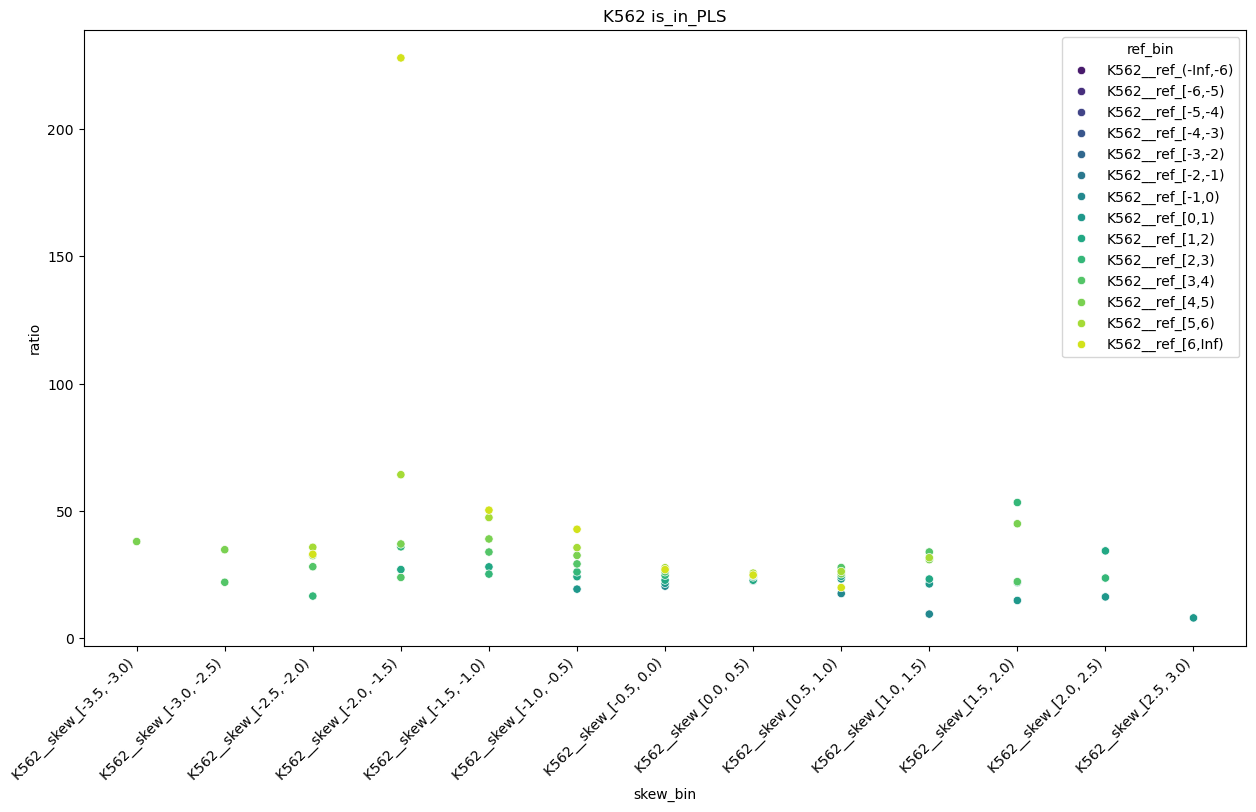

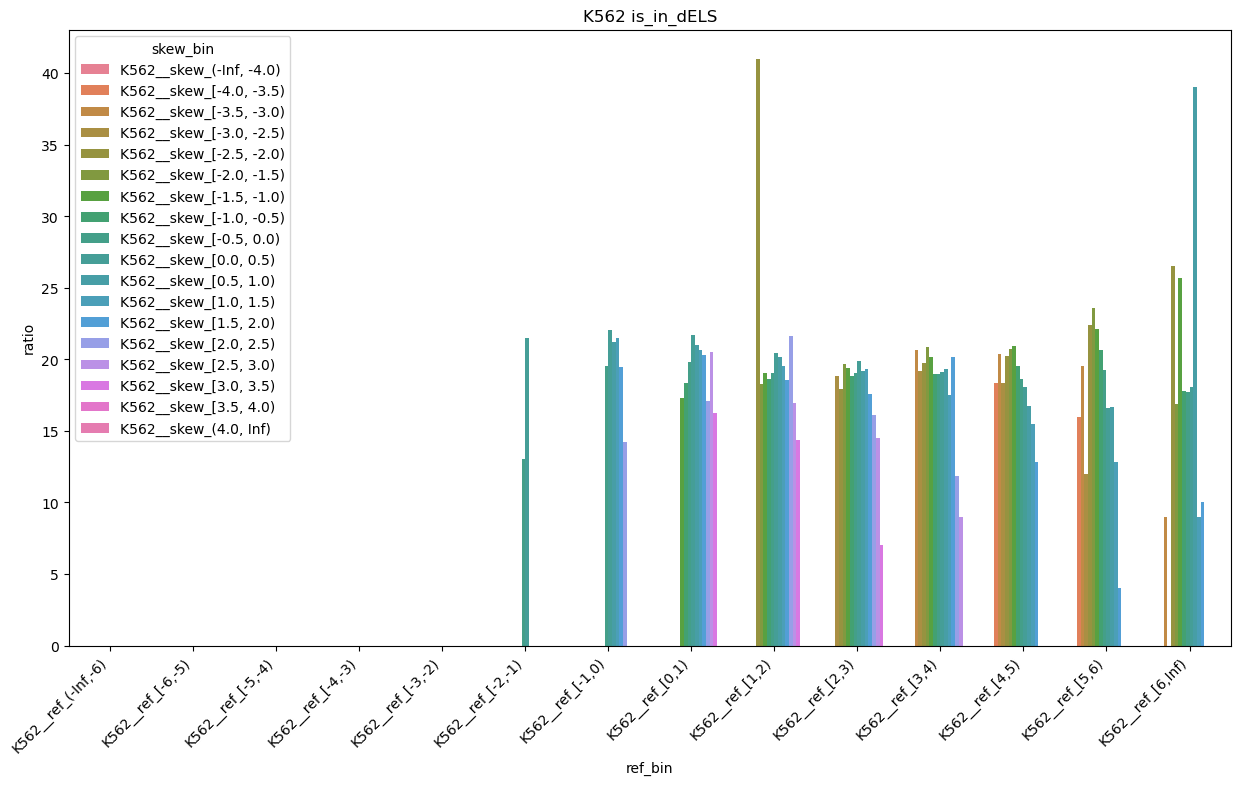

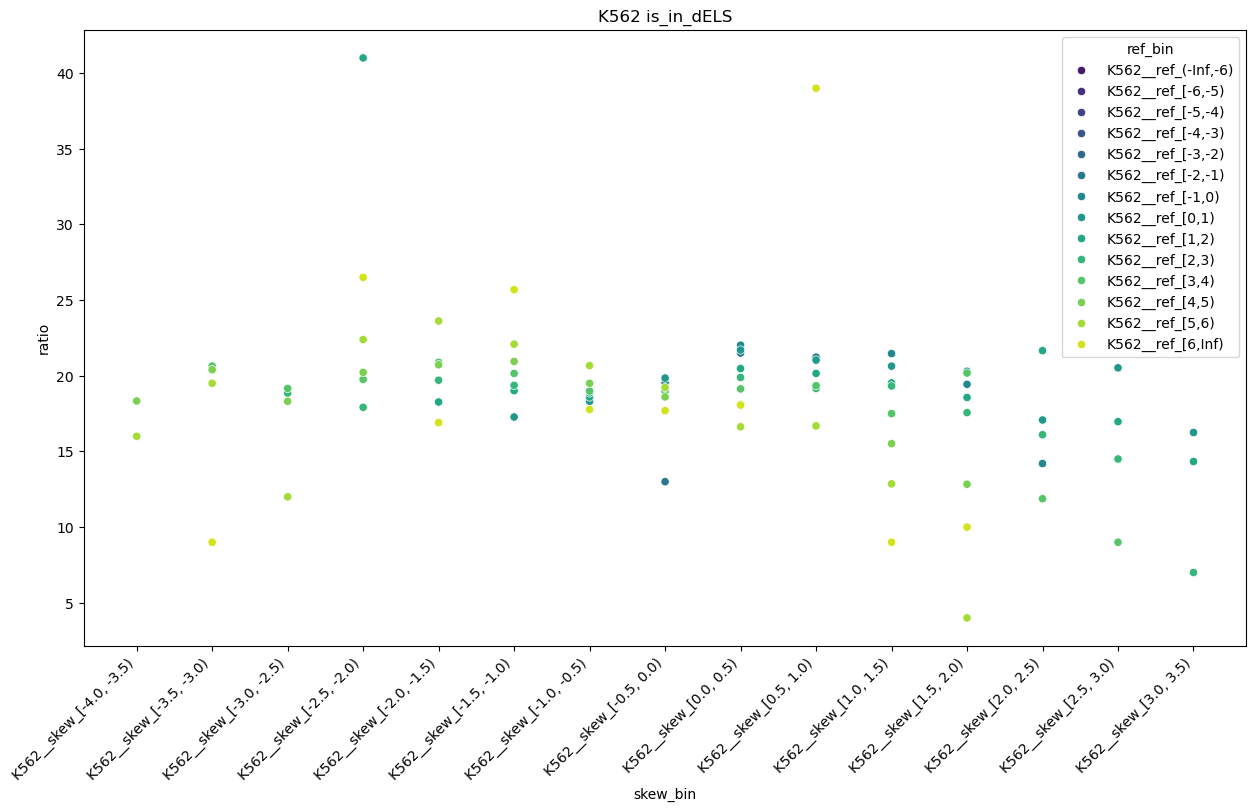

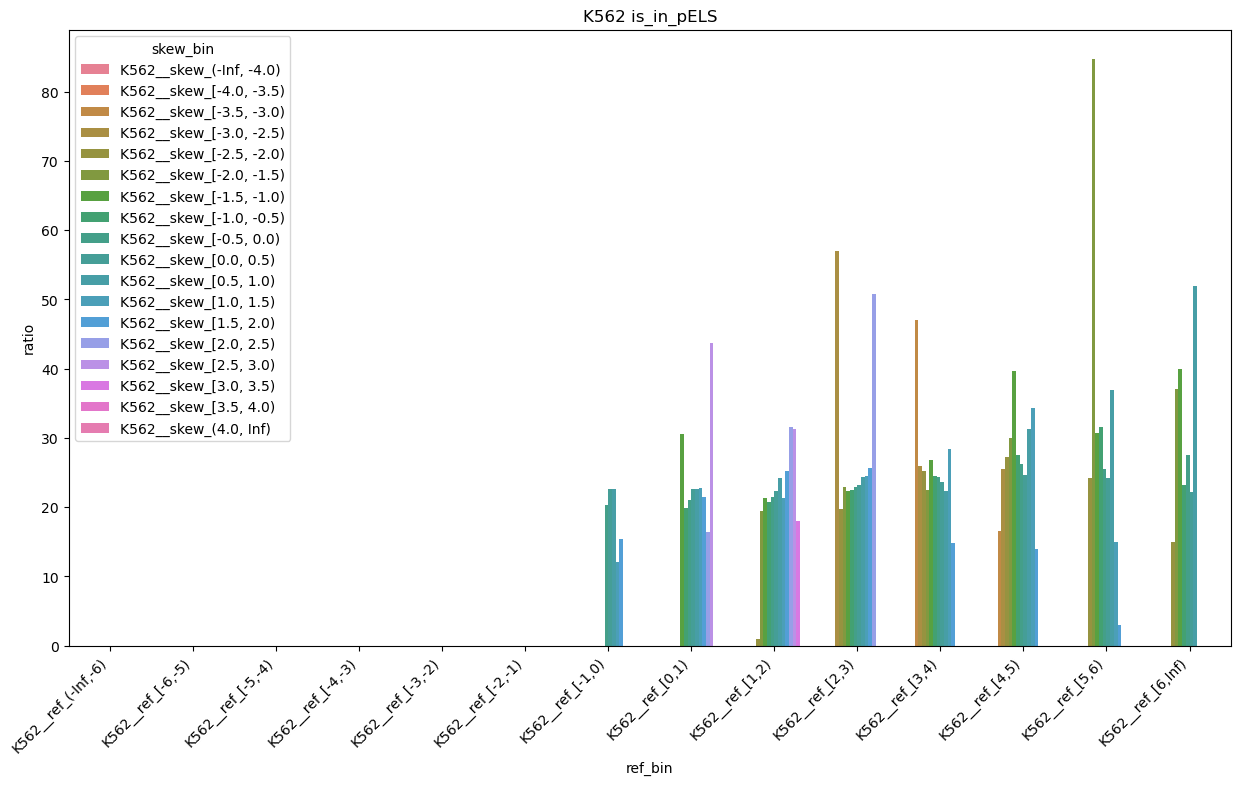

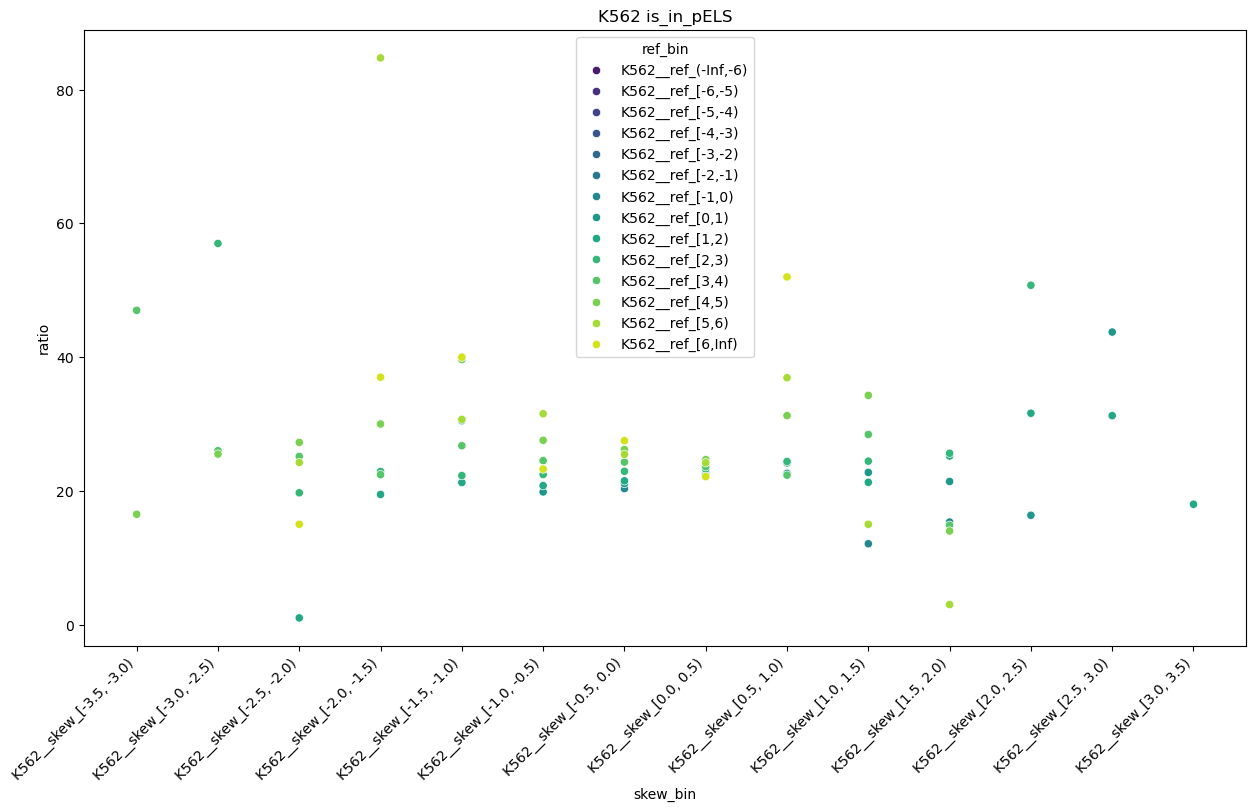

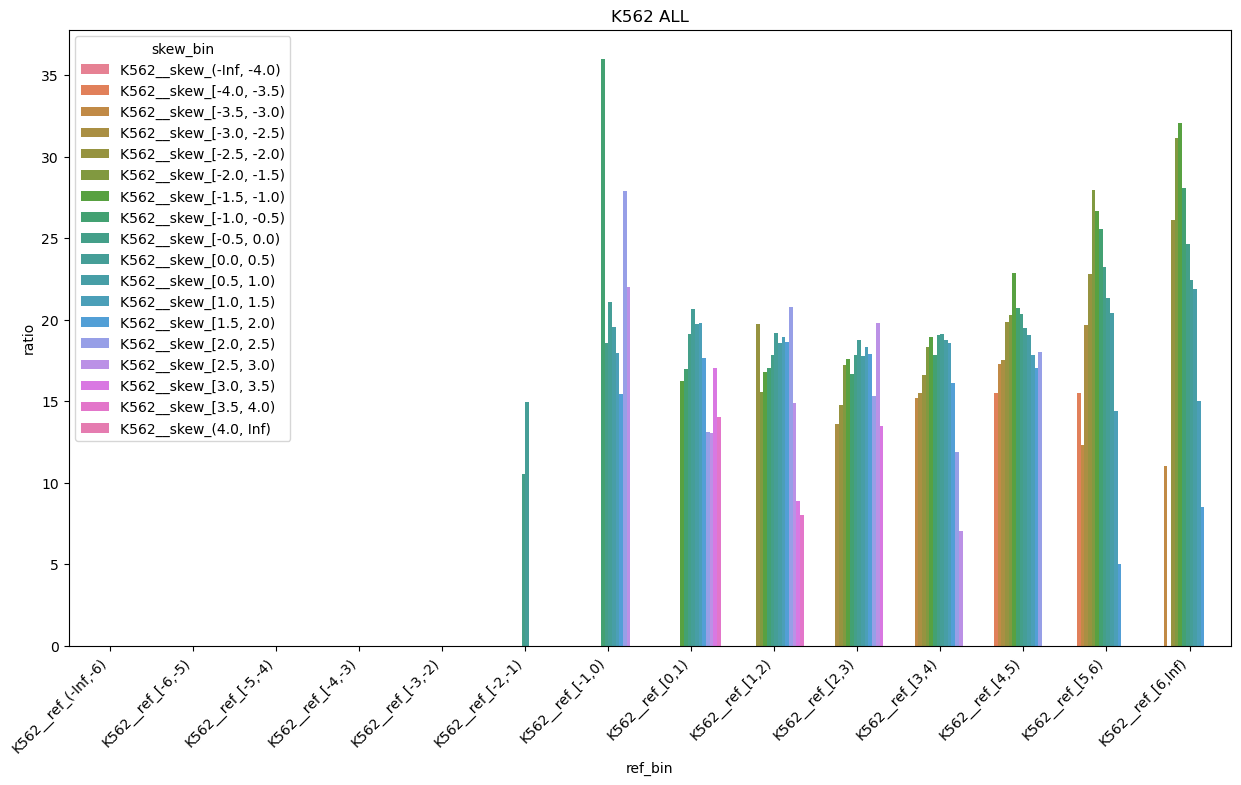

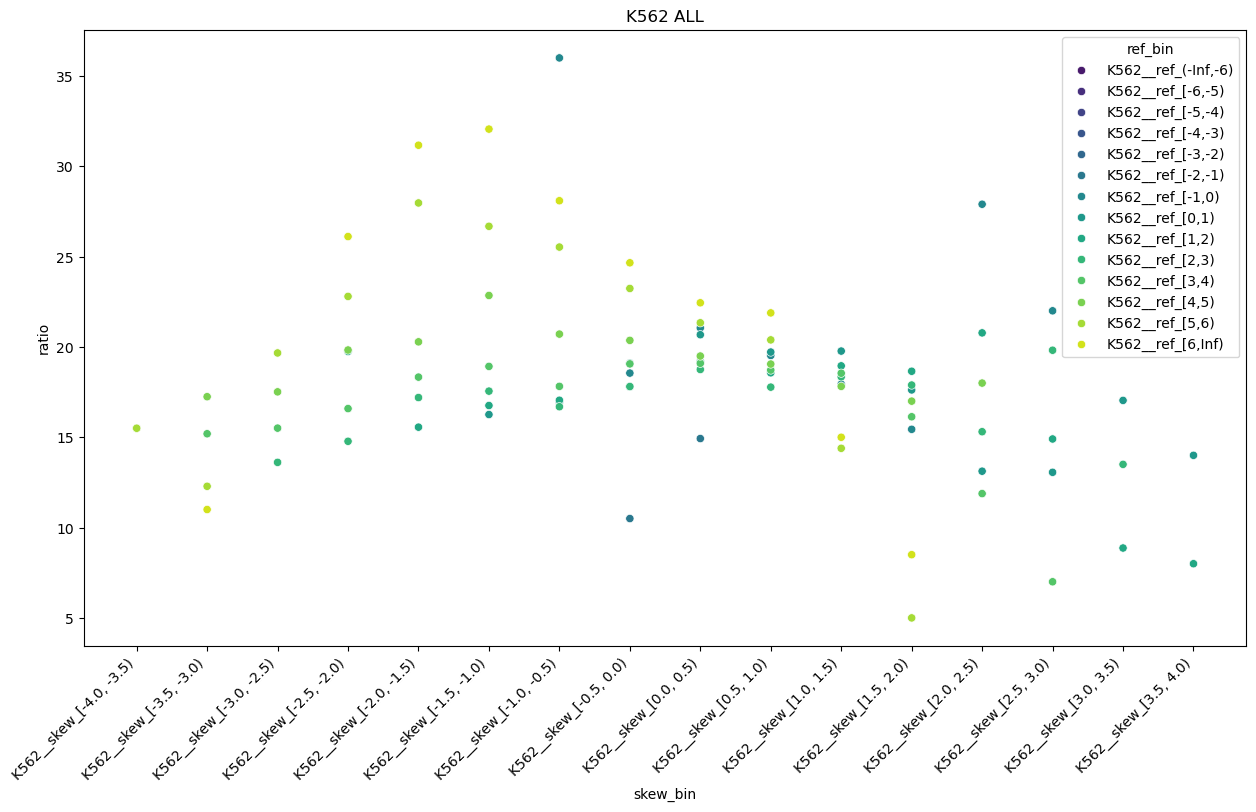

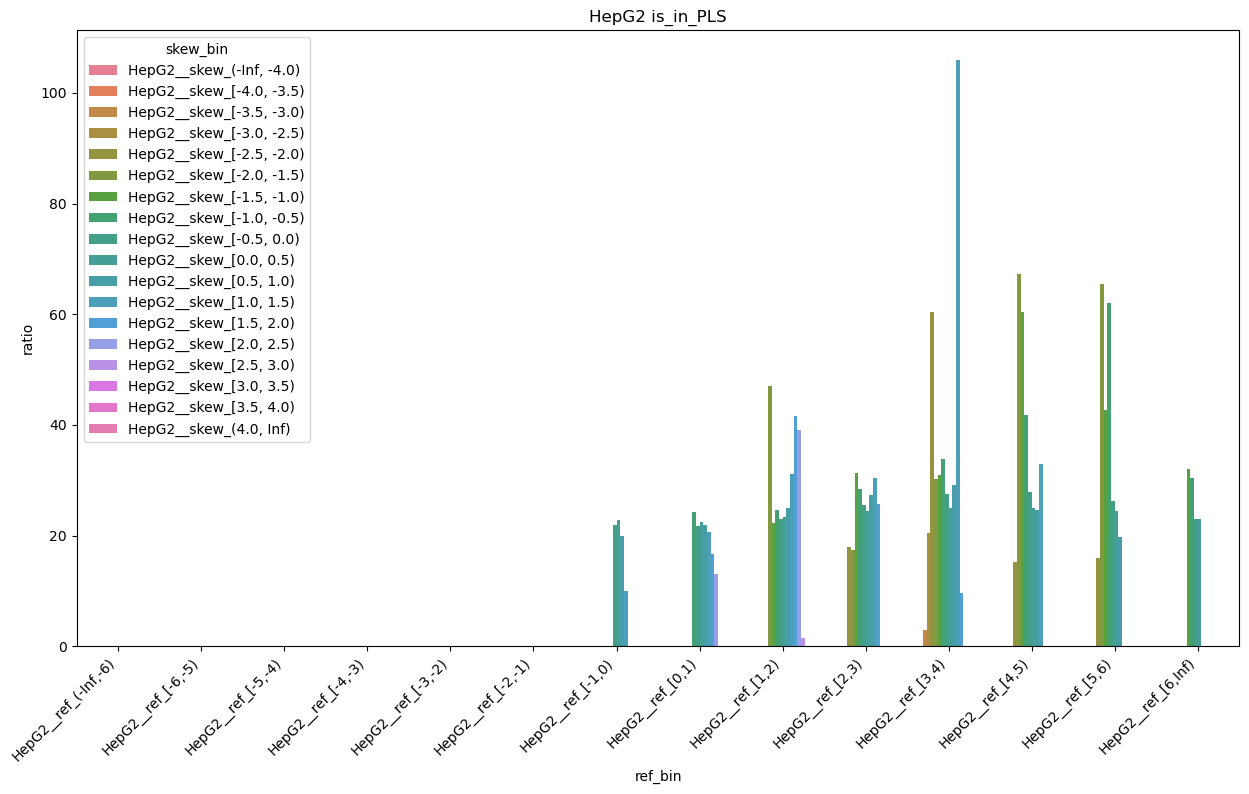

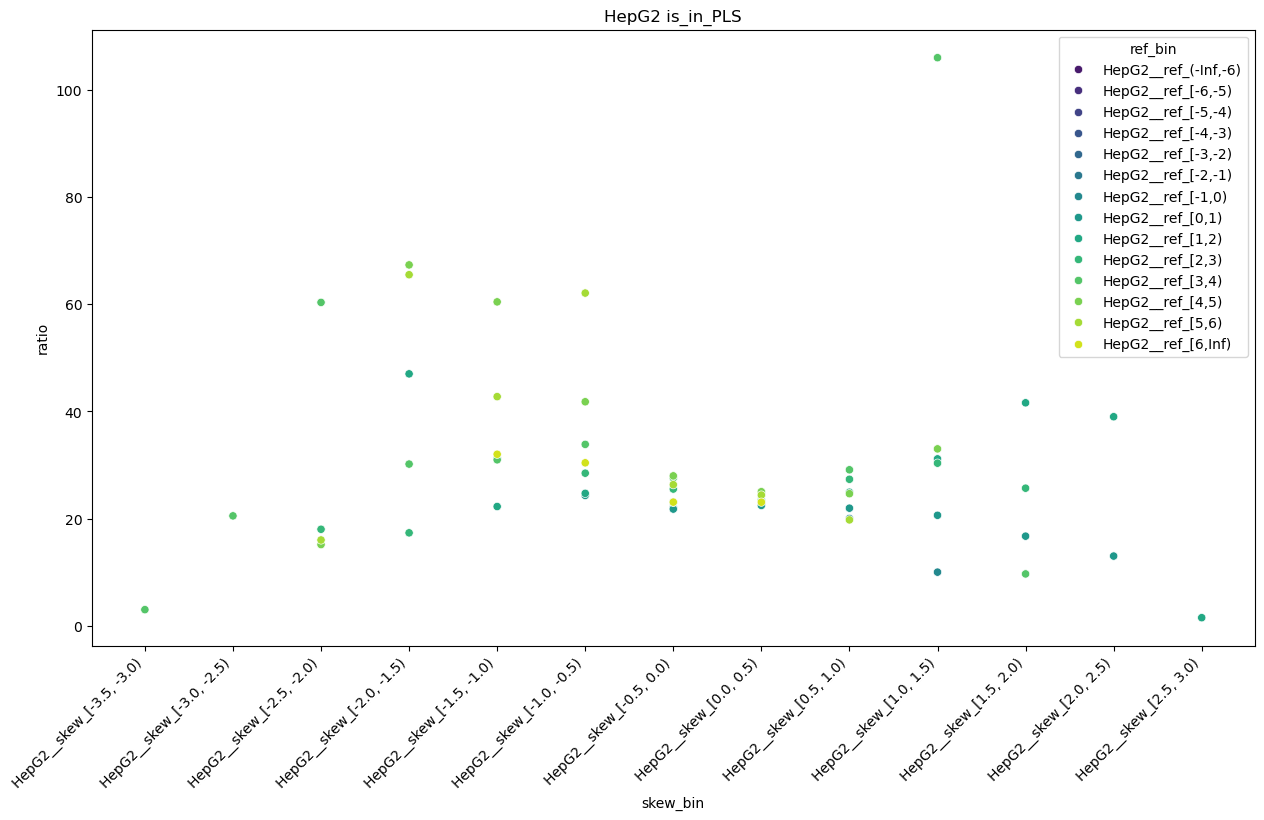

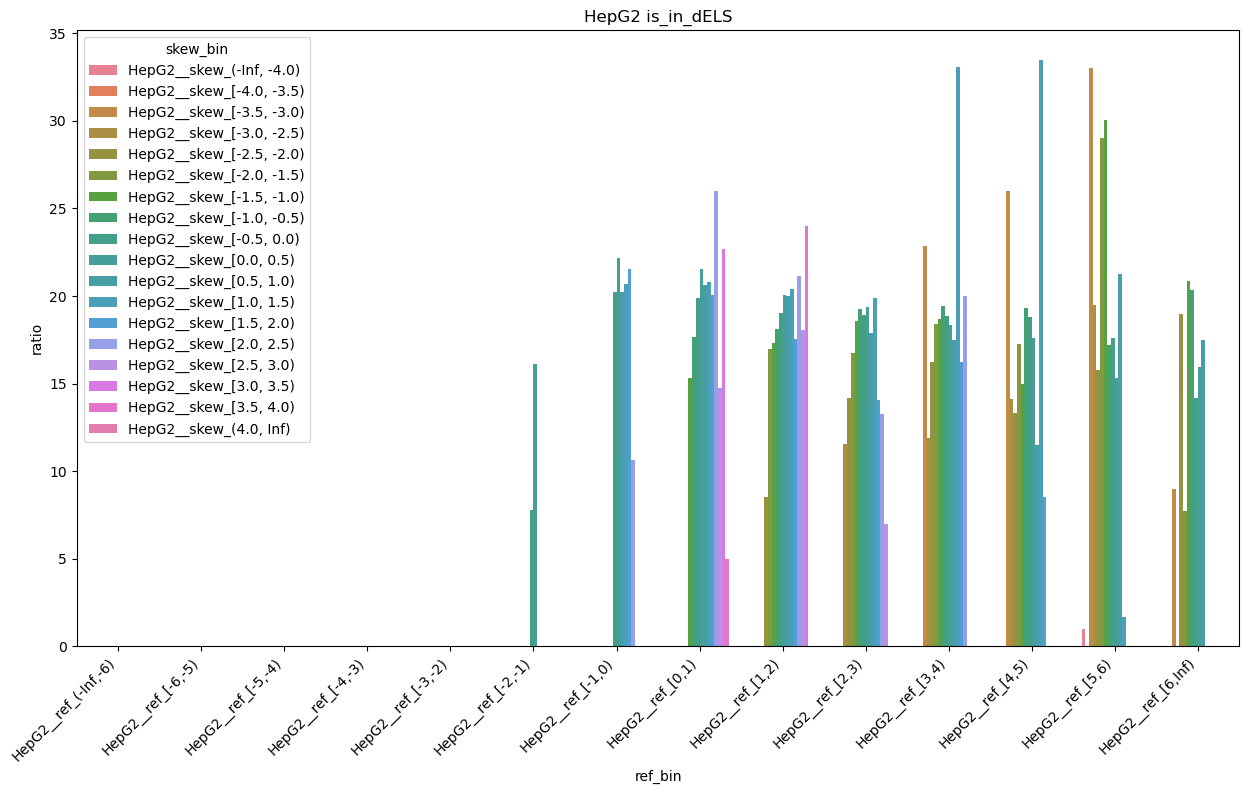

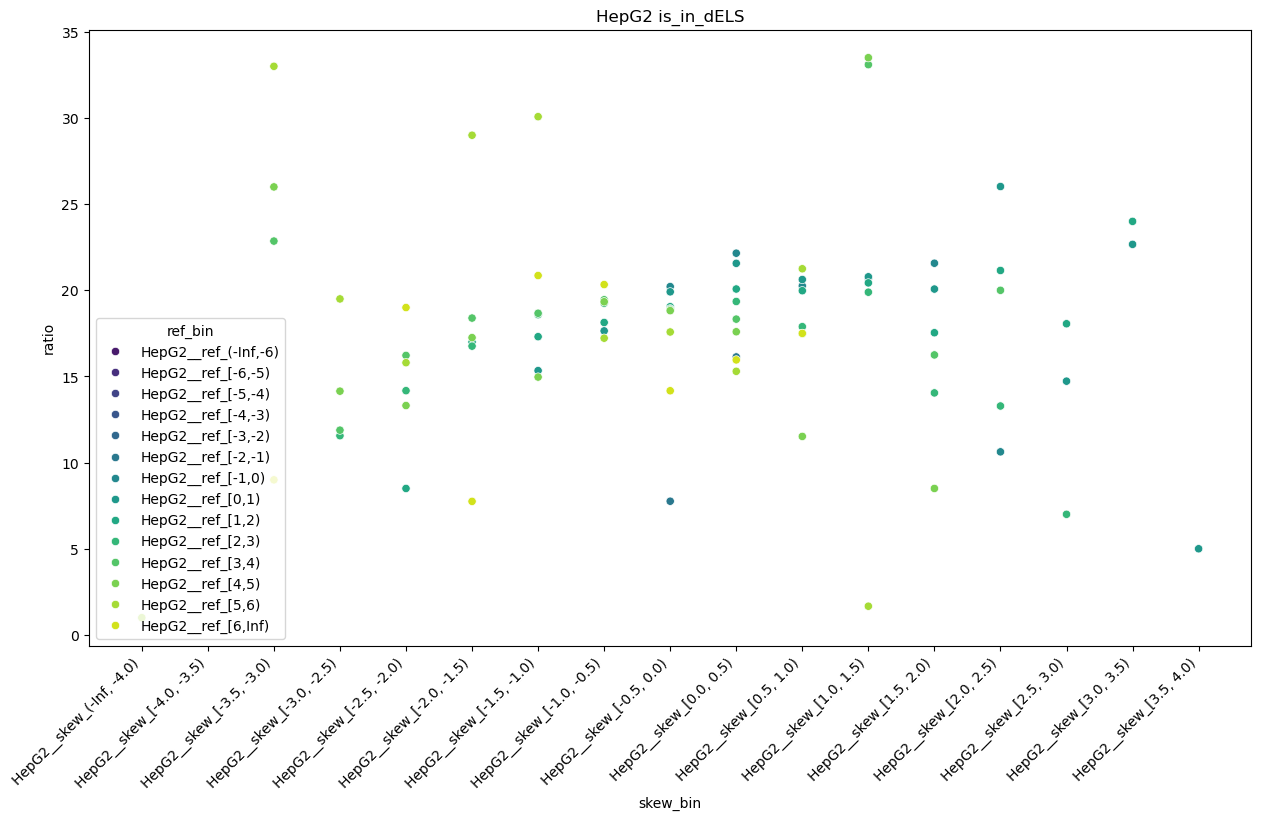

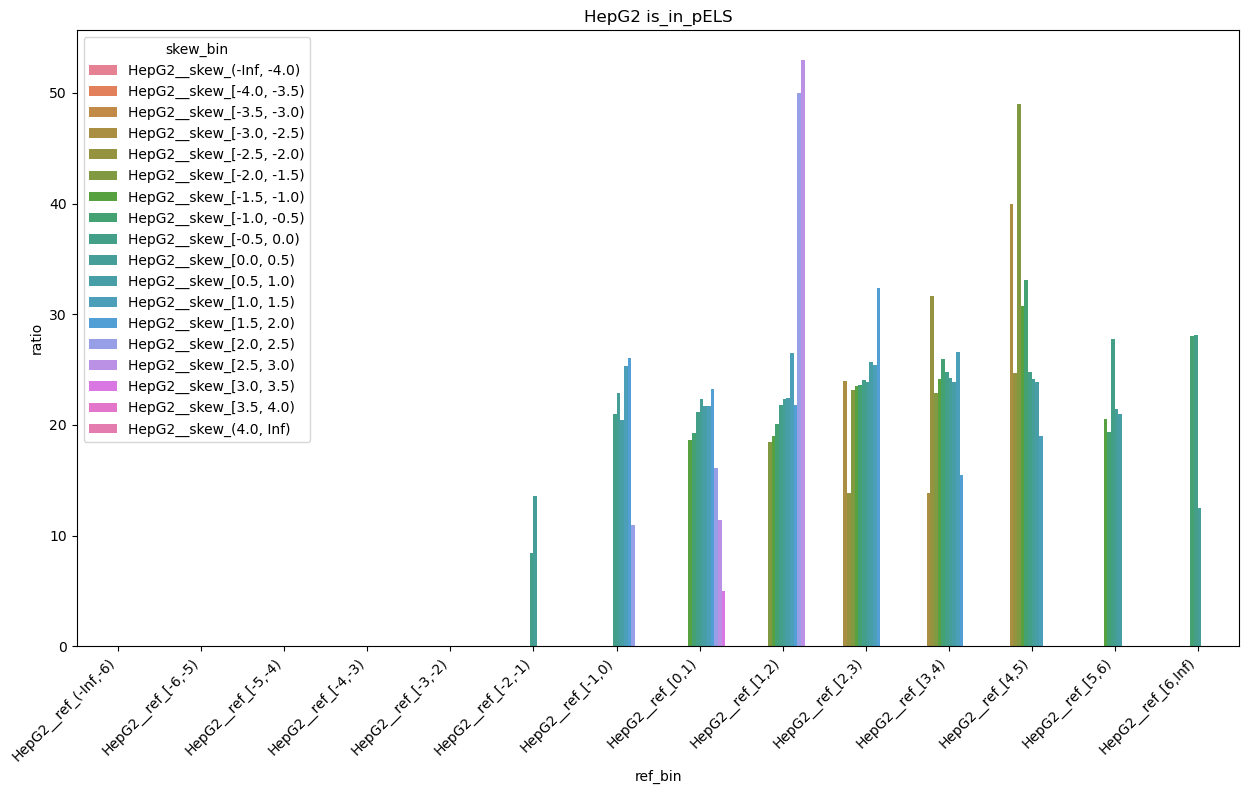

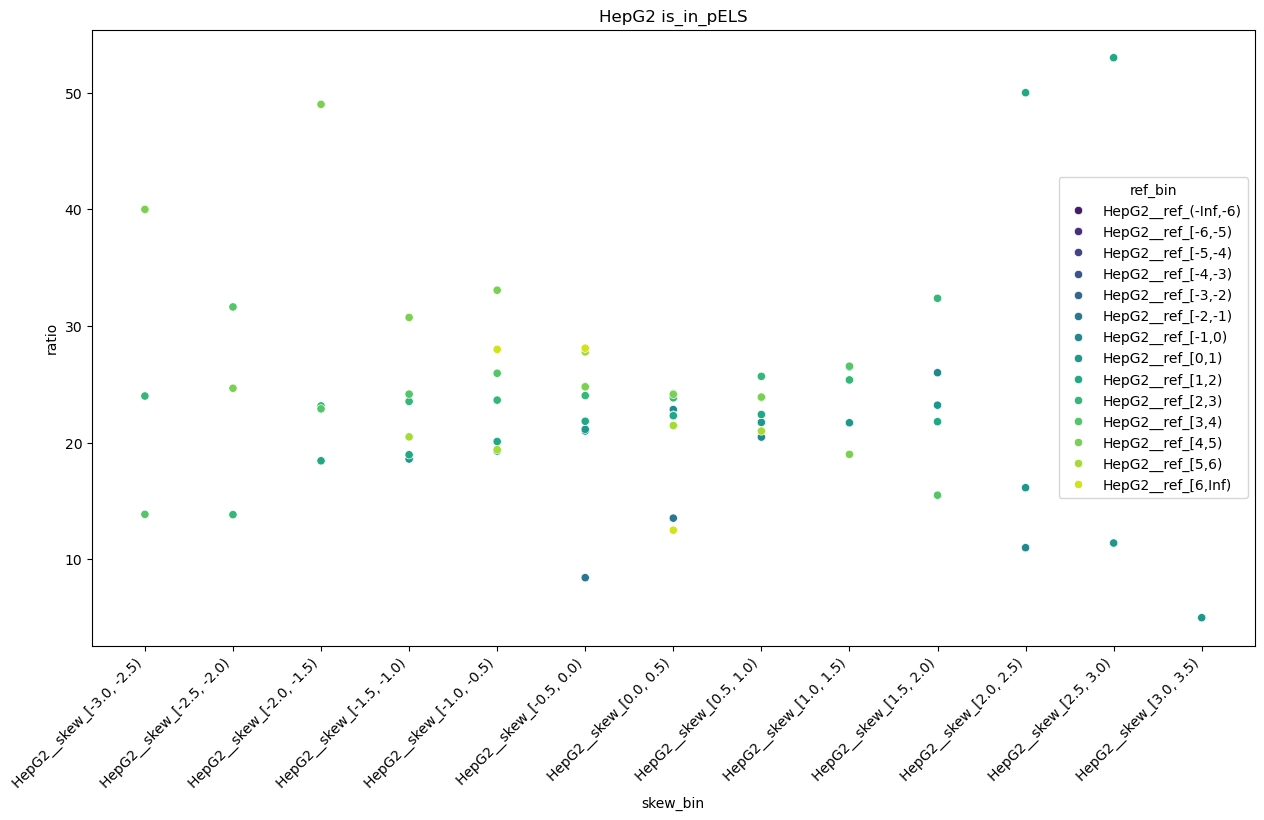

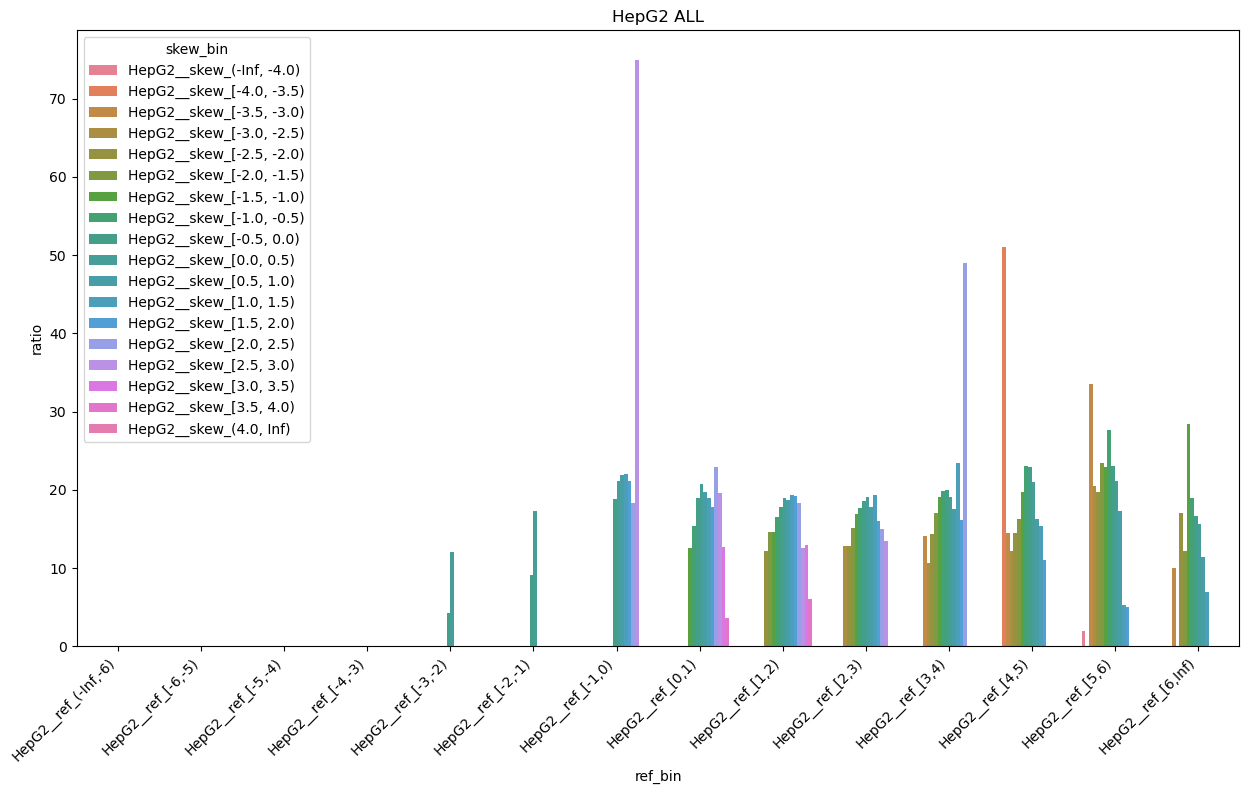

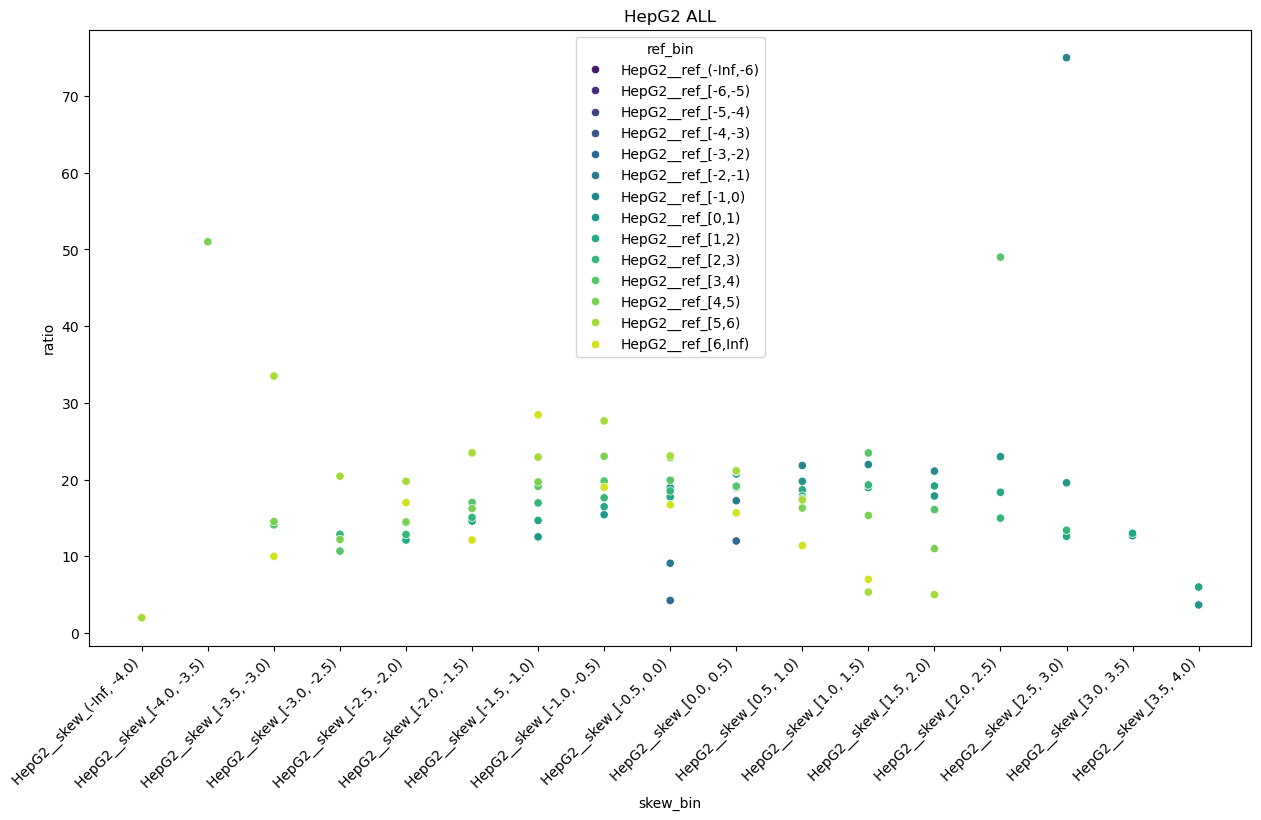

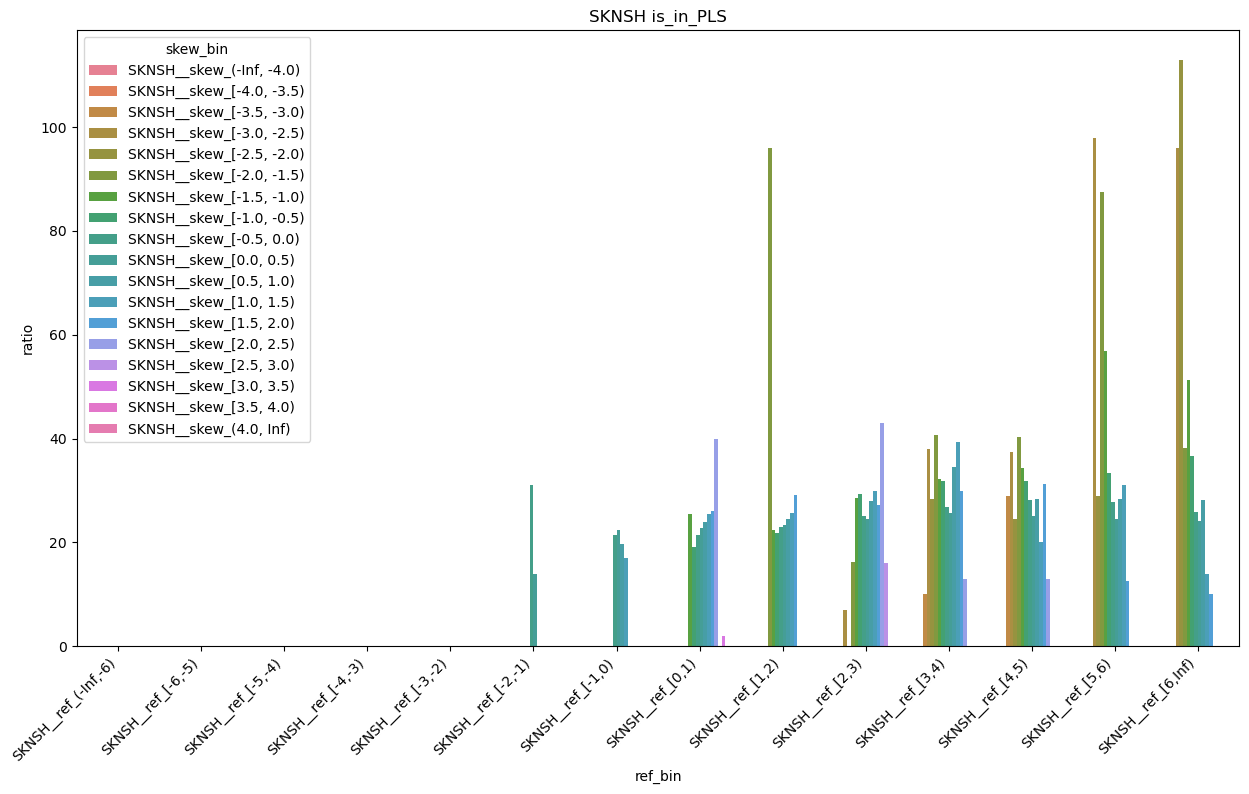

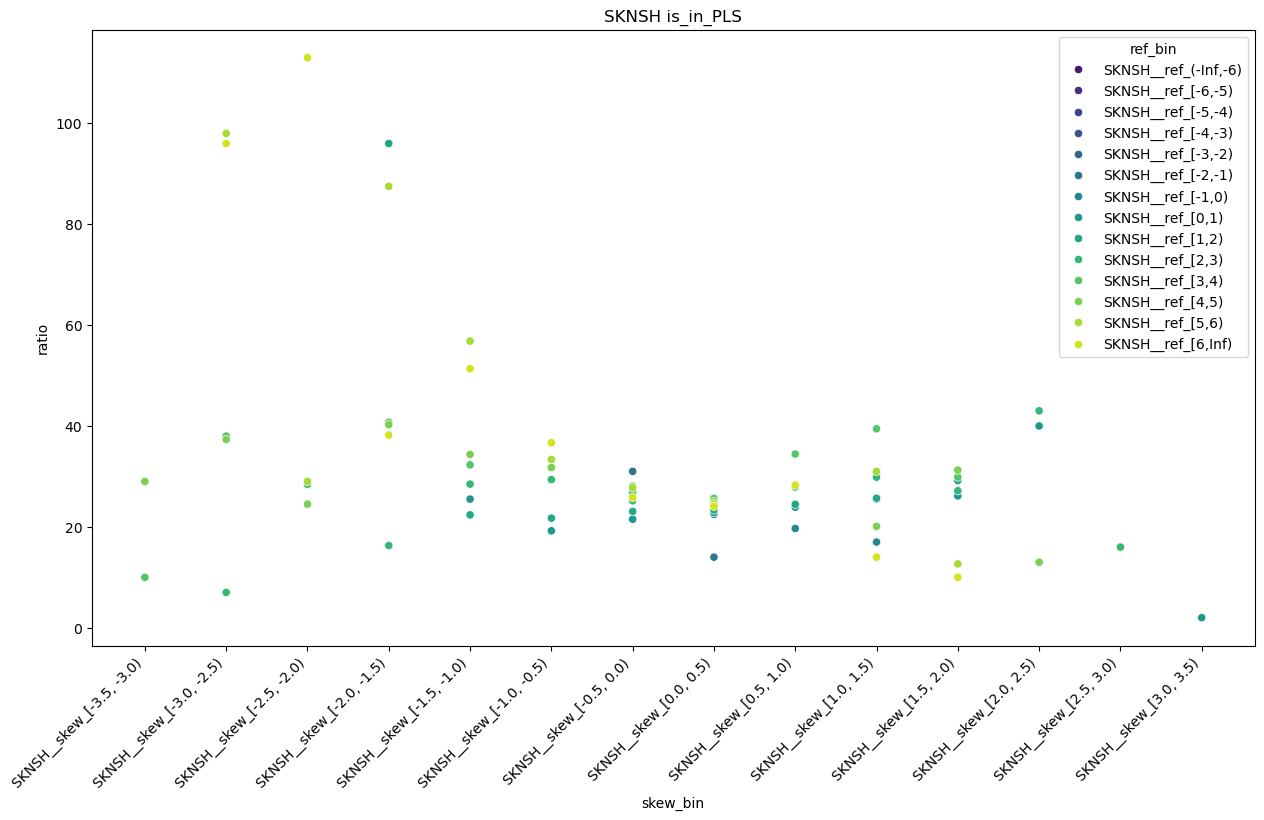

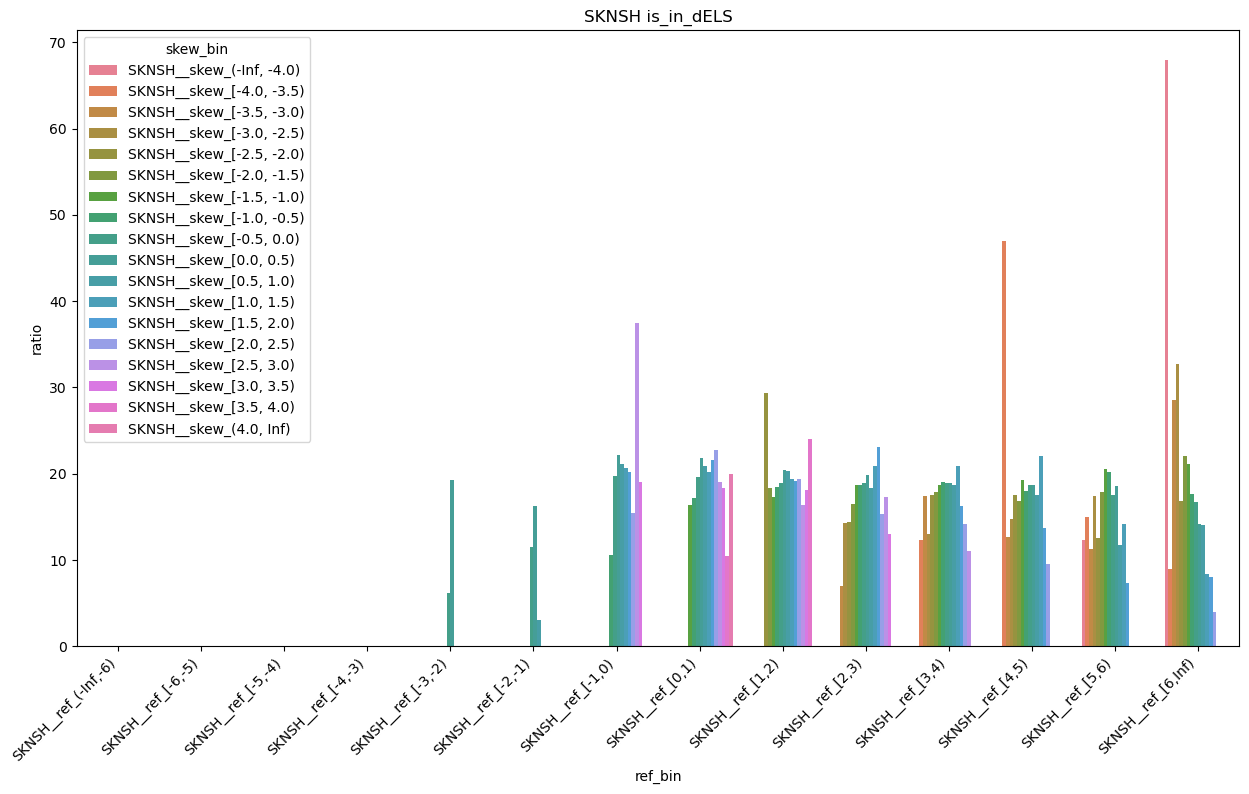

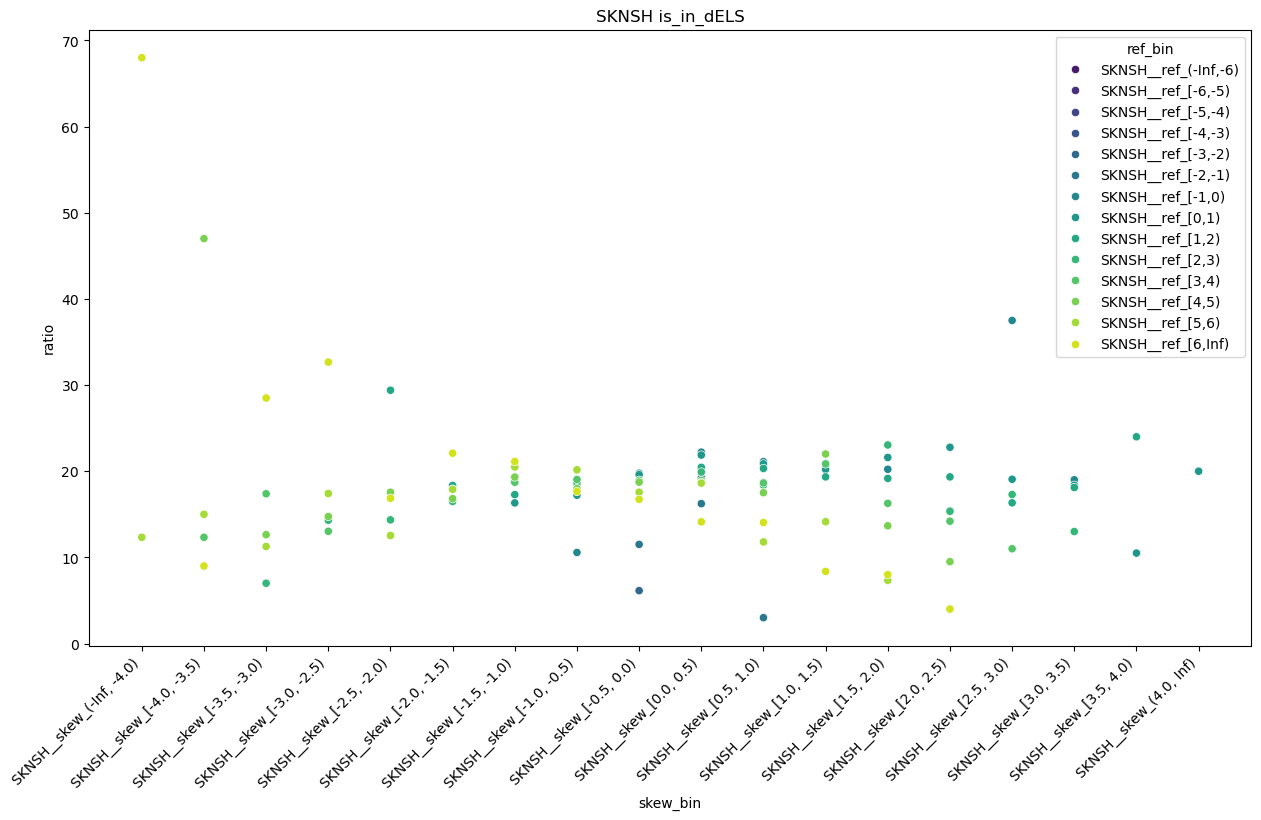

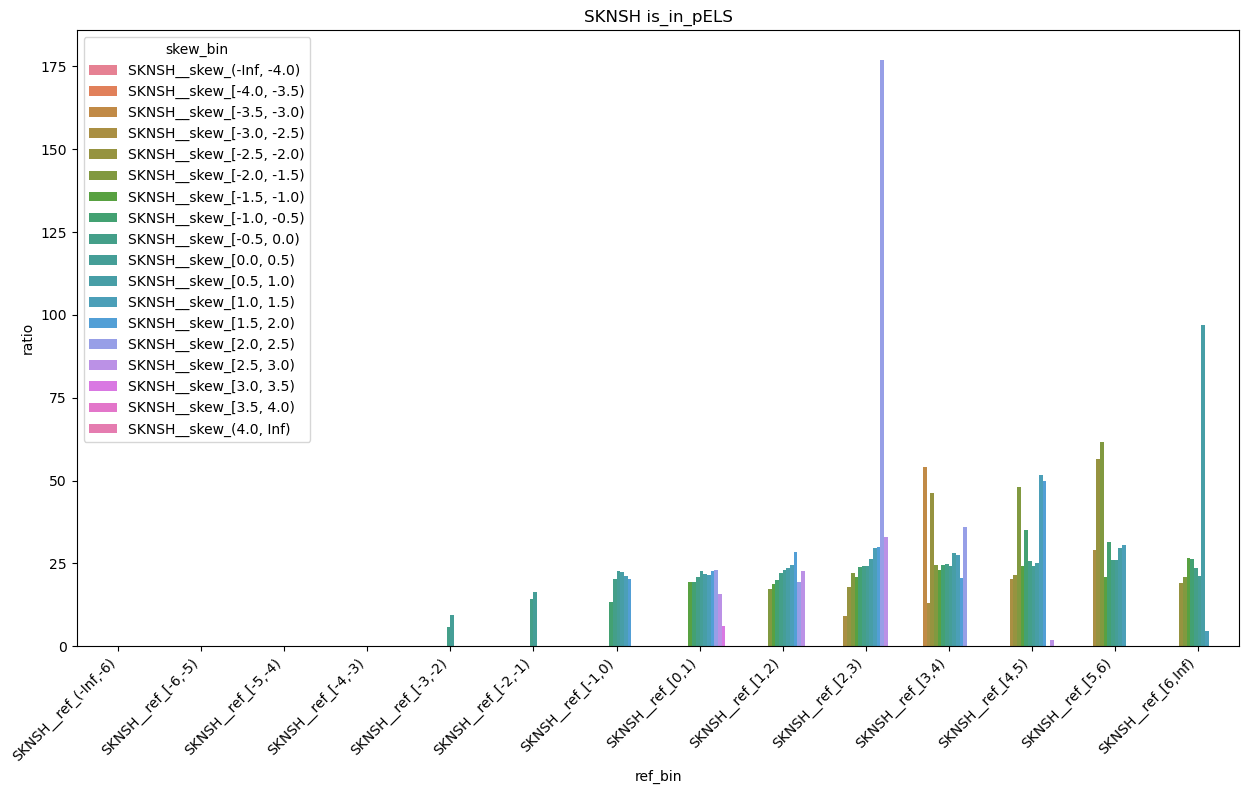

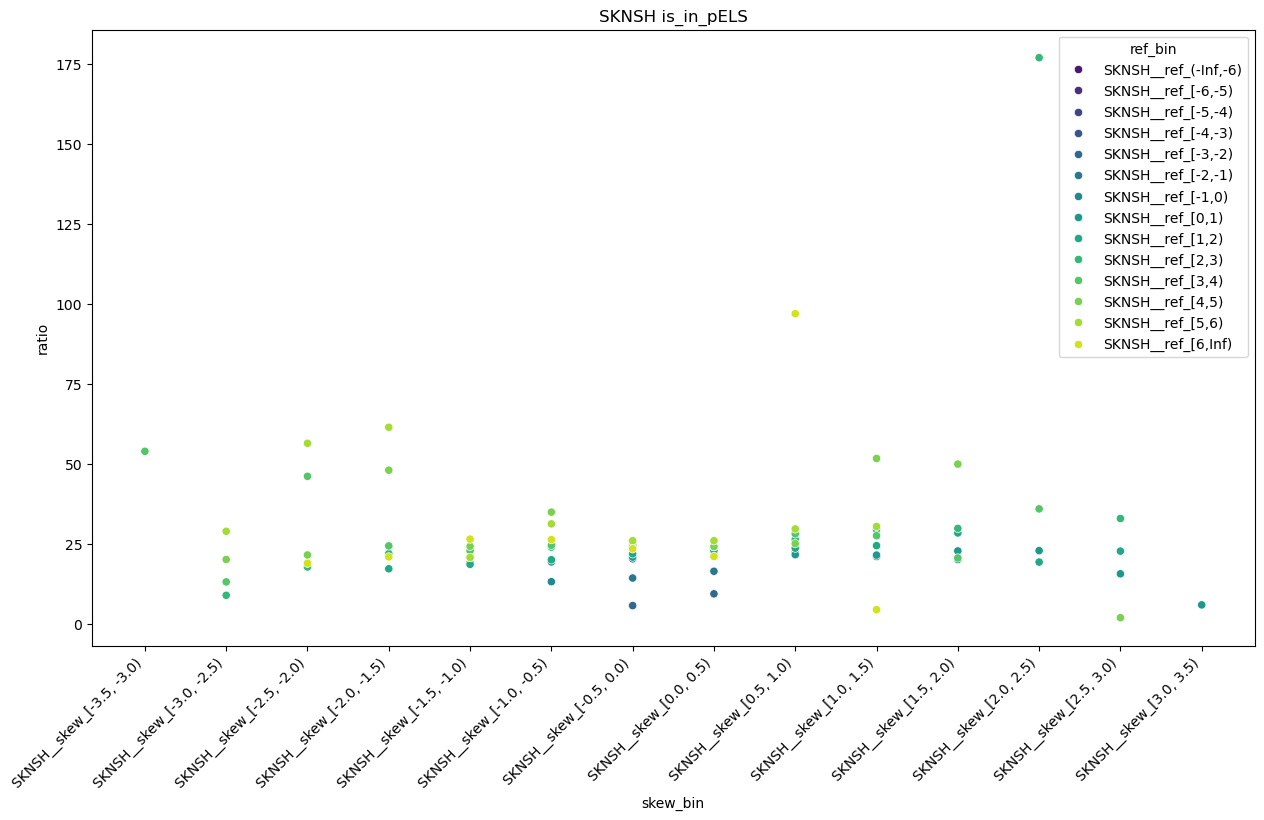

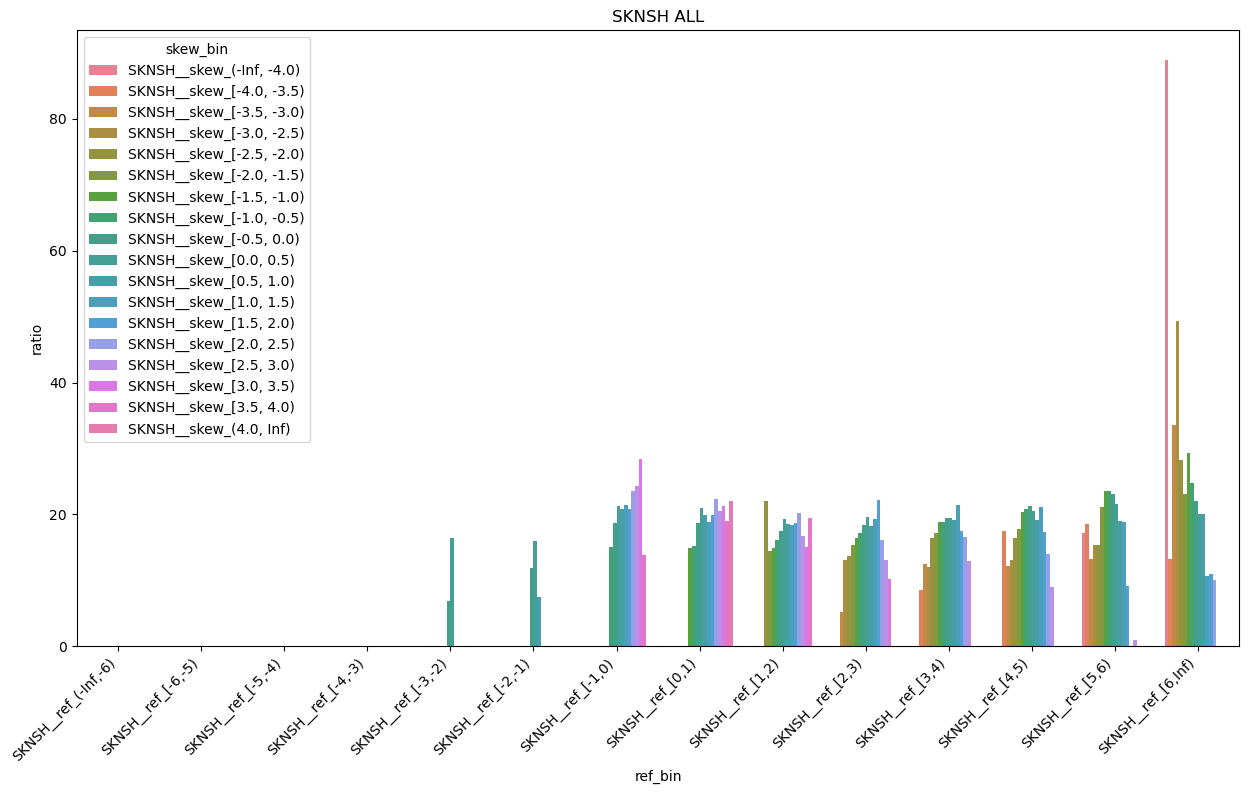

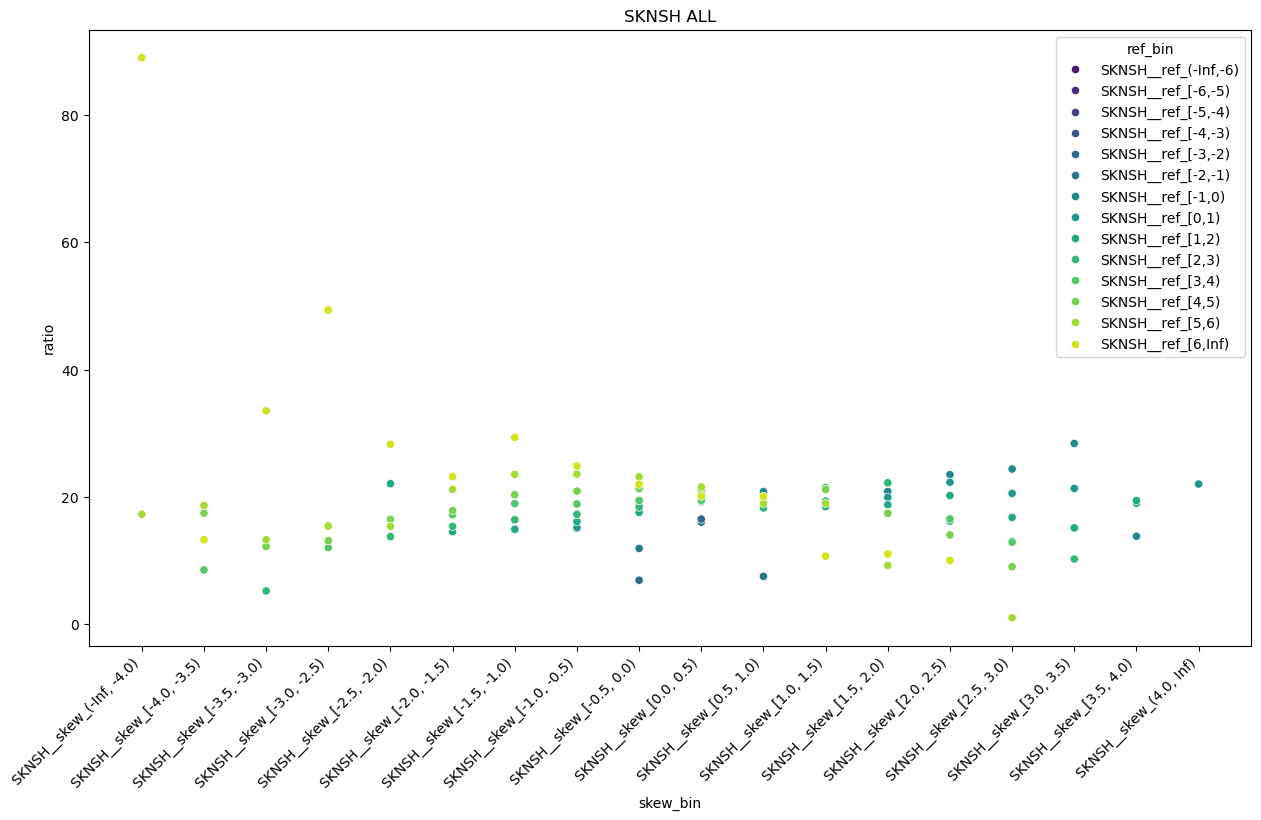

In [50]:
for cell_type in cell_types:
    current=data[cell_type]
    for region in GC.genome_regions:
        plot_2d_on_1d(df=current,cell_type=cell_type, genomic_region=region,x="skew_bin",y="ref_bin")
        plot_2d_on_1d(df=current,cell_type=cell_type, genomic_region=region,x="skew_bin",y="ref_bin",scatter=True)